In [54]:
import os
import shap
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lang2vec.lang2vec as l2v
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from joblib import Parallel, delayed
from scipy.stats import pearsonr, zscore
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score

In [55]:
language_map = {
    "same": "English",
    "avg": "Average",
    "af": "Afrikaans",
    "ar": "Arabic",
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "es": "Spanish",
    "fa": "Persian",
    "fi": "Finnish",
    "fr": "French",
    "he": "Hebrew",
    "hi": "Hindi",
    "hu": "Hungarian",
    "it": "Italian",
    "ja": "Japanese",
    "ko": "Korean",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "no": "Norwegian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "sv": "Swedish",
    "ta": "Tamil",
    "th": "Thai",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
    "zh": "Chinese",
    "sw": "Swahili",
    "ur": "Urdu",
    "en": "English"
}

In [56]:
method_names = {
    'baseline': 'Fine-tuning Only',
    'before_fastalign': 'Before FastAlign',
    'before_awesome': 'Before Awesome',
    'before_dico': 'Before Dict',
    'during_fastalign': 'During FastAlign',
    'during_awesome': 'During Awesome',
    'during_dico': 'During Dict',
    'freeze_realign_unfreeze_fastalign': 'Before - Front Freeze FastAlign',
    'freeze_realign_unfreeze_awesome': 'Before - Front Freeze Awesome',
    'freeze_realign_unfreeze_dico': 'Before - Front Freeze Dict',
    'freeze_realign_unfreeze_last_6_fastalign': 'Before - Back Freeze FastAlign',
    'freeze_realign_unfreeze_last_6_awesome': 'Before - Back Freeze Awesome',
    'freeze_realign_unfreeze_last_6_dico': 'Before - Back Freeze Dict',
    'during_partial_freeze_front_fastalign': 'During Front Freeze FastAlign',
    'during_partial_freeze_front_awesome': 'During Front Freeze Awesome',
    'during_partial_freeze_front_dico': 'During Front Freeze Dict',
    'during_partial_freeze_back_fastalign': 'During Back Freeze FastAlign',
    'during_partial_freeze_back_awesome': 'During Back Freeze Awesome',
    'during_partial_freeze_back_dico': 'During Back Freeze Dict',
}

In [57]:
lang2vec_mapping = {
    "English": "eng",
    "Afrikaans": "afr",
    "Arabic": "arb",
    "Bulgarian": "bul",
    "Catalan": "cat",
    "Czech": "ces",
    "Danish": "dan",
    "German": "deu",
    "Greek": "ell",
    "Spanish": "spa",
    "Persian": "fas",
    "Finnish": "fin",
    "French": "fra",
    "Hebrew": "heb",
    "Hindi": "hin",
    "Hungarian": "hun",
    "Italian": "ita",
    "Japanese": "jpn",
    "Korean": "kor",
    "Lithuanian": "lit",
    "Latvian": "lav",
    "Norwegian": "nob",
    "Polish": "pol",
    "Portuguese": "por",
    "Romanian": "ron",
    "Russian": "rus",
    "Slovak": "slk",
    "Slovenian": "slv",
    "Swedish": "swe",
    "Tamil": "tam",
    "Thai": "tha",
    "Turkish": "tur",
    "Ukrainian": "ukr",
    "Vietnamese": "vie",
    "Chinese": "cmn"
}

In [58]:
xlmr_token_data = {
    'Afrikaans': 242,
    'Arabic': 2869,
    'Bulgarian': 5487,
    'Catalan': 1752,
    'Czech': 2498,
    'Danish': 7823,
    'German': 10297,
    'Greek': 4285,
    'Spanish': 9374,
    'Persian': 13259,
    'Finnish': 6730,
    'French': 9780,
    'Hebrew': 3399,
    'Hindi': 1715,
    'Hungarian': 7807,
    'Italian': 4983,
    'Japanese': 530,
    'Korean': 5644,
    'Lithuanian': 1835,
    'Latvian': 1198,
    'Norwegian': 8494,
    'Polish': 6490,
    'Portuguese': 8405,
    'Romanian': 10354,
    'Russian': 23408,
    'Slovak': 3525,
    'Slovenian': 1669,
    'Swedish': 77.8,
    'Tamil': 595,
    'Thai': 1834,
    'Turkish': 2736,
    'Ukrainian': 6.5,
    'Vietnamese': 24757,
    'Chinese': 176
}


In [59]:
id_var_color_map = {
    'Method': 'blue',
    'Languages': 'green',
    'Model': 'purple',
    'QE Percentile': 'orange',
    'QE Threshold': 'red',
    'Distance': 'brown'
}

method_color_map = {
    'Fine-tuning Only': 'blue',
    'Before FastAlign': 'green',
    'Before Awesome': 'red',
    'Before Dict': 'purple',
    'During FastAlign': 'orange',
    'During Awesome': 'brown',
    'During Dict': 'pink',
    'Before - Front Freeze FastAlign': 'olive',
    'Before - Front Freeze Awesome': 'cyan',
    'Before - Front Freeze Dict': 'magenta',
    'Before - Back Freeze FastAlign': 'lime',
    'Before - Back Freeze Awesome': 'teal',
    'Before - Back Freeze Dict': 'lavender',
    'During Front Freeze FastAlign': 'darkgreen',
    'During Front Freeze Awesome': 'darkred',
    'During Front Freeze Dict': 'darkviolet',
    'During Back Freeze FastAlign': 'darkorange',
    'During Back Freeze Awesome': 'saddlebrown',
    'During Back Freeze Dict': 'mediumvioletred'
}

language_names = list(language_map.values())
num_languages = len(language_names)
colors = sns.color_palette("tab20", num_languages).as_hex()
language_color_map = dict(zip(language_names, colors))

distance_color_map = {
    'inventory': 'blue',
    'syntactic': 'green',
    'featural': 'red',
    'geographic': 'purple',
    'phonological': 'orange',
    'genetic': 'brown'
}

value_color_map = {
    '0.0': 'gray',
    '0.4': 'darkblue',
    '0.5': 'darkgreen',
    '0.6': 'darkred',
    '0.7': 'indigo',
    '0.8': 'darkorange',
    '25.0': 'lightgreen',
    '37.0': 'lightcoral',
    '62.0': 'violet',
    '75.0': 'lightblue',
    '50.0': 'lightyellow'
}

In [60]:
def get_lang_distances(lang1, lang2, mapping):
    if lang1 == 'English' and lang2 == 'English':
        return {'syntactic': 0, 'geographic': 0, 'phonological': 0, 'genetic': 0, 'inventory': 0, 'featural': 0}
    lang2_code = mapping.get(lang2)
    
    if not lang2_code:
        print(f"Error: {lang2} is not in the language mapping.")
        return {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    try:
        distances = {
            'syntactic': l2v.distance('syntactic', lang1, lang2_code),
            'geographic': l2v.distance('geographic', lang1, lang2_code),
            'phonological': l2v.distance('phonological', lang1, lang2_code),
            'genetic': l2v.distance('genetic', lang1, lang2_code),
            'inventory': l2v.distance('inventory', lang1, lang2_code),
            'featural': l2v.distance('featural', lang1, lang2_code),
        }
    except Exception as e:
        print(f"Error calculating distances between {lang1} and {lang2_code}: {e}")
        distances = {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    return distances

In [61]:
def add_language_distances_to_df(df, target_lang='eng', lang_col='language'):
    # Initialize distance columns
    distance_cols = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']
    for col in distance_cols:
        df[col] = np.nan

    for lang in df[lang_col].unique():
        distances = get_lang_distances(target_lang, lang, lang2vec_mapping)
        for col, value in distances.items():
            df.loc[df[lang_col] == lang, col] = value
    
    return df

In [62]:
api = wandb.Api()

workspace = "align_freeze"
projects = ['3nl_34langs_baseline_udpos',
            '3nl_34langs_before_fastalign_udpos',
            '3nl_34langs_before_awesome_udpos',
            '3nl_34langs_before_dico_udpos',
            '3nl_34langs_during_fastalign_udpos',
            '3nl_34langs_during_awesome_udpos',
            '3nl_34langs_during_dico_udpos',
            '3nl_34langs_freeze_realign_unfreeze_fastalign_udpos',
            '3nl_34langs_freeze_realign_unfreeze_awesome_udpos',
            '3nl_34langs_freeze_realign_unfreeze_dico_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_fastalign_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_awesome_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_dico_udpos',
            '3nl_34langs_during_partial_freeze_front_fastalign_udpos',
            '3nl_34langs_during_partial_freeze_front_awesome_udpos',
            '3nl_34langs_during_partial_freeze_front_dico_udpos',
            '3nl_34langs_during_partial_freeze_back_fastalign_udpos',
            '3nl_34langs_during_partial_freeze_back_awesome_udpos',
            '3nl_34langs_during_partial_freeze_back_dico_udpos']

langs = ["same", "avg", "af", "ar", "bg", "ca", "cs", "da", "de", "el", "es", "fa", "fi", "fr", "he", "hi",
         "hu", "it", "ja", "ko", "lt", 'lv', 'no', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'sv', 'ta', 'th', 'tr', 'uk',
         'vi', 'zh']

def fetch_and_process_runs(projects, _langs, model_name, username="felixgaschi"):
    records = []
    
    for project in projects:
        runs = api.runs(f"{workspace}/{project}")
        for run in runs:
            if run.user.username == username:
                method = run.config.get('method', 'unknown')
                seed = run.config.get('seed', 'unknown')
                for lang in _langs:
                    accuracy_key = f"eval_{lang}_accuracy"
                    accuracy = run.summary.get(accuracy_key)
                    record = {
                        'model': model_name,
                        'method': method_names.get(method, method),
                        'language': language_map.get(lang, lang),
                        'seed': seed,
                        'accuracy': accuracy if accuracy is not None else None
                    }
                    records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

# Fetching and processing the data for XLM-R
xlmr_df = fetch_and_process_runs(projects, langs, model_name='XLM-R')
xlmr_df

model                   method    language  seed  accuracy
0     XLM-R         Fine-tuning Only     English    17  0.966891
1     XLM-R         Fine-tuning Only     Average    17  0.807267
2     XLM-R         Fine-tuning Only   Afrikaans    17  0.882861
3     XLM-R         Fine-tuning Only      Arabic    17  0.622334
4     XLM-R         Fine-tuning Only   Bulgarian    17  0.887179
...     ...                      ...         ...   ...       ...
3595  XLM-R  During Back Freeze Dict        Thai    31  0.686990
3596  XLM-R  During Back Freeze Dict     Turkish    31  0.726260
3597  XLM-R  During Back Freeze Dict   Ukrainian    31  0.854369
3598  XLM-R  During Back Freeze Dict  Vietnamese    31  0.643915
3599  XLM-R  During Back Freeze Dict     Chinese    31  0.709731

[3600 rows x 5 columns]

In [63]:
csv_file_path = './distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv'

def read_and_process_csv(file_path, model_name):
    df = pd.read_csv(file_path)
    records = []
    
    for idx, row in df.iterrows():
        method = row['method']
        seed = row['seed']
        for lang in language_map.keys():
            accuracy_key = f'eval_{lang}_accuracy'
            if accuracy_key in df.columns:
                accuracy = row[accuracy_key]
                record = {
                    'model': model_name,
                    'method': method_names.get(method, method),
                    'language': language_map.get(lang, lang),
                    'seed': seed,
                    'accuracy': accuracy if not pd.isna(accuracy) else None
                }
                records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

distilmbert_df = read_and_process_csv(csv_file_path, model_name='distilMBERT')


In [64]:
# xlmr_csv_path = './xlmr_threshold_data/xlm-roberta-base__opus100.csv'

# xlmr_df = read_and_process_csv(xlmr_csv_path, model_name='XLM-R')

In [65]:
distilmbert_df['method'].value_counts()

method
Before FastAlign                               180
During Front Freeze Awesome                    180
freeze_realign_unfreeze_last_half_awesome      180
freeze_realign_unfreeze_last_half_fastalign    180
Fine-tuning Only                               180
During Back Freeze Dict                        180
During Back Freeze Awesome                     180
During Back Freeze FastAlign                   180
During Front Freeze Dict                       180
During Front Freeze FastAlign                  180
Before Awesome                                 180
Before - Front Freeze Dict                     180
Before - Front Freeze Awesome                  180
Before - Front Freeze FastAlign                180
During Dict                                    180
During Awesome                                 180
During FastAlign                               180
Before Dict                                    180
freeze_realign_unfreeze_last_half_dico         180
Name: count, dtype: int6

In [66]:
xlmr_df['method'].value_counts()

method
Before FastAlign                   360
Fine-tuning Only                   180
Before - Back Freeze FastAlign     180
During Back Freeze Awesome         180
During Back Freeze FastAlign       180
During Front Freeze Dict           180
During Front Freeze Awesome        180
During Front Freeze FastAlign      180
Before - Back Freeze Dict          180
Before - Back Freeze Awesome       180
Before - Front Freeze Dict         180
Before - Front Freeze Awesome      180
Before - Front Freeze FastAlign    180
During Dict                        180
During Awesome                     180
During FastAlign                   180
Before Dict                        180
Before Awesome                     180
During Back Freeze Dict            180
Name: count, dtype: int64

In [67]:
xlmr_df[(xlmr_df['method'] == 'Before FastAlign') & (xlmr_df['language'] == 'Chinese')]

model            method language  seed  accuracy
215  XLM-R  Before FastAlign  Chinese    17  0.709648
251  XLM-R  Before FastAlign  Chinese    23  0.707151
287  XLM-R  Before FastAlign  Chinese    66  0.707650
323  XLM-R  Before FastAlign  Chinese    42  0.699992
359  XLM-R  Before FastAlign  Chinese    31  0.700491
395  XLM-R  Before FastAlign  Chinese    31       NaN
431  XLM-R  Before FastAlign  Chinese    23       NaN
467  XLM-R  Before FastAlign  Chinese    66       NaN
503  XLM-R  Before FastAlign  Chinese    42       NaN
539  XLM-R  Before FastAlign  Chinese    31       NaN

In [68]:
xlmr_df = xlmr_df[~xlmr_df.isna().any(axis=1)]
xlmr_df

model                   method    language  seed  accuracy
0     XLM-R         Fine-tuning Only     English    17  0.966891
1     XLM-R         Fine-tuning Only     Average    17  0.807267
2     XLM-R         Fine-tuning Only   Afrikaans    17  0.882861
3     XLM-R         Fine-tuning Only      Arabic    17  0.622334
4     XLM-R         Fine-tuning Only   Bulgarian    17  0.887179
...     ...                      ...         ...   ...       ...
3595  XLM-R  During Back Freeze Dict        Thai    31  0.686990
3596  XLM-R  During Back Freeze Dict     Turkish    31  0.726260
3597  XLM-R  During Back Freeze Dict   Ukrainian    31  0.854369
3598  XLM-R  During Back Freeze Dict  Vietnamese    31  0.643915
3599  XLM-R  During Back Freeze Dict     Chinese    31  0.709731

[3420 rows x 5 columns]

In [69]:
xlmr_df['method'].value_counts()

method
Fine-tuning Only                   180
Before - Back Freeze FastAlign     180
During Back Freeze Awesome         180
During Back Freeze FastAlign       180
During Front Freeze Dict           180
During Front Freeze Awesome        180
During Front Freeze FastAlign      180
Before - Back Freeze Dict          180
Before - Back Freeze Awesome       180
Before - Front Freeze Dict         180
Before FastAlign                   180
Before - Front Freeze Awesome      180
Before - Front Freeze FastAlign    180
During Dict                        180
During Awesome                     180
During FastAlign                   180
Before Dict                        180
Before Awesome                     180
During Back Freeze Dict            180
Name: count, dtype: int64

In [70]:
assert len(xlmr_df) == len(distilmbert_df)

In [71]:
def calculate_delta_accuracy(group):
    baseline = group[group['method'] == 'Fine-tuning Only']
    methods = group[group['method'] != 'Fine-tuning Only']
    
    if len(baseline) > 0:
        baseline_accuracy = baseline['accuracy'].values
        
        for method in methods['method'].unique():
            method_indices = methods['method'] == method
            baseline_subset = baseline_accuracy[:sum(method_indices)]
            methods.loc[method_indices, 'delta_accuracy'] = methods.loc[method_indices, 'accuracy'].values - baseline_subset

    return pd.concat([baseline, methods])

def process_dataframe(df, group_by_columns):
    result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
    return result.reset_index(drop=True)

In [72]:
processed_distilmbert_df = process_dataframe(distilmbert_df, group_by_columns=['model', 'seed', 'language'])
processed_distilmbert_df

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


model                                       method    language  \
0     distilMBERT                             Fine-tuning Only   Afrikaans   
1     distilMBERT                             Before FastAlign   Afrikaans   
2     distilMBERT                               Before Awesome   Afrikaans   
3     distilMBERT                                  Before Dict   Afrikaans   
4     distilMBERT                             During FastAlign   Afrikaans   
...           ...                                          ...         ...   
3415  distilMBERT                   During Back Freeze Awesome  Vietnamese   
3416  distilMBERT                      During Back Freeze Dict  Vietnamese   
3417  distilMBERT  freeze_realign_unfreeze_last_half_fastalign  Vietnamese   
3418  distilMBERT    freeze_realign_unfreeze_last_half_awesome  Vietnamese   
3419  distilMBERT       freeze_realign_unfreeze_last_half_dico  Vietnamese   

      seed  accuracy  delta_accuracy  
0       17  0.852558             NaN  
1       17  0.866965        0.014406  
2       17  0.865176        0.012618  
3       17  0.854645        0.002086  
4       17  0.862394        0.009836  
...    ...       ...             ...  
3415    66  0.569218       -0.010874  
3416    66  0.586951        0.006859  
3417    66  0.570724       -0.009368  
3418    66  0.576746       -0.003346  
3419    66  0.580259        0.000167  

[3420 rows x 6 columns]

In [73]:
processed_distilmbert_df[(processed_distilmbert_df['language'] == 'Chinese') & (processed_distilmbert_df['seed'] == 17)]

model                                       method language  seed  \
95   distilMBERT                             Fine-tuning Only  Chinese    17   
96   distilMBERT                             Before FastAlign  Chinese    17   
97   distilMBERT                               Before Awesome  Chinese    17   
98   distilMBERT                                  Before Dict  Chinese    17   
99   distilMBERT                             During FastAlign  Chinese    17   
100  distilMBERT                               During Awesome  Chinese    17   
101  distilMBERT                                  During Dict  Chinese    17   
102  distilMBERT              Before - Front Freeze FastAlign  Chinese    17   
103  distilMBERT                Before - Front Freeze Awesome  Chinese    17   
104  distilMBERT                   Before - Front Freeze Dict  Chinese    17   
105  distilMBERT                During Front Freeze FastAlign  Chinese    17   
106  distilMBERT                  During Front Freeze Awesome  Chinese    17   
107  distilMBERT                     During Front Freeze Dict  Chinese    17   
108  distilMBERT                 During Back Freeze FastAlign  Chinese    17   
109  distilMBERT                   During Back Freeze Awesome  Chinese    17   
110  distilMBERT                      During Back Freeze Dict  Chinese    17   
111  distilMBERT  freeze_realign_unfreeze_last_half_fastalign  Chinese    17   
112  distilMBERT    freeze_realign_unfreeze_last_half_awesome  Chinese    17   
113  distilMBERT       freeze_realign_unfreeze_last_half_dico  Chinese    17   

     accuracy  delta_accuracy  
95   0.650433             NaN  
96   0.656011        0.005578  
97   0.658342        0.007909  
98   0.670163        0.019730  
99   0.646187       -0.004246  
100  0.651349        0.000916  
101  0.655678        0.005245  
102  0.663004        0.012571  
103  0.661755        0.011322  
104  0.666334        0.015901  
105  0.640276       -0.010157  
106  0.641192       -0.009241  
107  0.642940       -0.007493  
108  0.638944       -0.011489  
109  0.647353       -0.003080  
110  0.651765        0.001332  
111  0.670413        0.019980  
112  0.660007        0.009574  
113  0.665251        0.014819

In [74]:
processed_xlmr_df = process_dataframe(xlmr_df, group_by_columns=['model', 'seed', 'language'])
processed_xlmr_df

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


model                   method    language  seed  accuracy  \
0     XLM-R         Fine-tuning Only     English    17  0.966891   
1     XLM-R         Fine-tuning Only     Average    17  0.807267   
2     XLM-R         Fine-tuning Only   Afrikaans    17  0.882861   
3     XLM-R         Fine-tuning Only      Arabic    17  0.622334   
4     XLM-R         Fine-tuning Only   Bulgarian    17  0.887179   
...     ...                      ...         ...   ...       ...   
3415  XLM-R  During Back Freeze Dict        Thai    31  0.686990   
3416  XLM-R  During Back Freeze Dict     Turkish    31  0.726260   
3417  XLM-R  During Back Freeze Dict   Ukrainian    31  0.854369   
3418  XLM-R  During Back Freeze Dict  Vietnamese    31  0.643915   
3419  XLM-R  During Back Freeze Dict     Chinese    31  0.709731   

      delta_accuracy  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
3415       -0.005779  
3416        0.008068  
3417       -0.004256  
3418       -0.004517  
3419       -0.005994  

[3420 rows x 6 columns]

In [75]:
processed_xlmr_df[(processed_xlmr_df['language'] == 'Vietnamese') & (processed_xlmr_df['seed'] == 17)]

model                           method    language  seed  accuracy  \
34    XLM-R                 Fine-tuning Only  Vietnamese    17  0.640652   
214   XLM-R                 Before FastAlign  Vietnamese    17  0.641907   
394   XLM-R                   Before Awesome  Vietnamese    17  0.643998   
574   XLM-R                      Before Dict  Vietnamese    17  0.642074   
754   XLM-R                 During FastAlign  Vietnamese    17  0.639063   
934   XLM-R                   During Awesome  Vietnamese    17  0.637892   
1114  XLM-R                      During Dict  Vietnamese    17  0.646340   
1294  XLM-R  Before - Front Freeze FastAlign  Vietnamese    17  0.647679   
1474  XLM-R    Before - Front Freeze Awesome  Vietnamese    17  0.648097   
1654  XLM-R       Before - Front Freeze Dict  Vietnamese    17  0.651777   
1834  XLM-R   Before - Back Freeze FastAlign  Vietnamese    17  0.638729   
2014  XLM-R     Before - Back Freeze Awesome  Vietnamese    17  0.642074   
2194  XLM-R        Before - Back Freeze Dict  Vietnamese    17  0.643664   
2374  XLM-R    During Front Freeze FastAlign  Vietnamese    17  0.644668   
2554  XLM-R      During Front Freeze Awesome  Vietnamese    17  0.640987   
2734  XLM-R         During Front Freeze Dict  Vietnamese    17  0.649937   
2914  XLM-R     During Back Freeze FastAlign  Vietnamese    17  0.634128   
3094  XLM-R       During Back Freeze Awesome  Vietnamese    17  0.633292   
3274  XLM-R          During Back Freeze Dict  Vietnamese    17  0.639398   

      delta_accuracy  
34               NaN  
214         0.001255  
394         0.003346  
574         0.001422  
754        -0.001589  
934        -0.002760  
1114        0.005688  
1294        0.007026  
1474        0.007445  
1654        0.011125  
1834       -0.001924  
2014        0.001422  
2194        0.003011  
2374        0.004015  
2554        0.000335  
2734        0.009285  
2914       -0.006524  
3094       -0.007361  
3274       -0.001255

In [76]:
0.579256 - 0.578084

0.0011719999999999509

In [77]:
# Combine the two DataFrames
combined_df = pd.concat([processed_xlmr_df, processed_distilmbert_df], ignore_index=True)

# Drop rows with NaNs in 'accuracy' column
combined_df.dropna(subset=['accuracy'], inplace=True)

# Drop rows with NaNs in 'delta_accuracy' column (if applicable)
combined_df.dropna(subset=['delta_accuracy'], inplace=True)

combined_df

model                                       method    language  \
180         XLM-R                             Before FastAlign     English   
181         XLM-R                             Before FastAlign     Average   
182         XLM-R                             Before FastAlign   Afrikaans   
183         XLM-R                             Before FastAlign      Arabic   
184         XLM-R                             Before FastAlign   Bulgarian   
...           ...                                          ...         ...   
6835  distilMBERT                   During Back Freeze Awesome  Vietnamese   
6836  distilMBERT                      During Back Freeze Dict  Vietnamese   
6837  distilMBERT  freeze_realign_unfreeze_last_half_fastalign  Vietnamese   
6838  distilMBERT    freeze_realign_unfreeze_last_half_awesome  Vietnamese   
6839  distilMBERT       freeze_realign_unfreeze_last_half_dico  Vietnamese   

      seed  accuracy  delta_accuracy  
180     17  0.968070        0.001180  
181     17  0.807816        0.000549  
182     17  0.885544        0.002683  
183     17  0.667102        0.044768  
184     17  0.891694        0.004515  
...    ...       ...             ...  
6835    66  0.569218       -0.010874  
6836    66  0.586951        0.006859  
6837    66  0.570724       -0.009368  
6838    66  0.576746       -0.003346  
6839    66  0.580259        0.000167  

[6480 rows x 6 columns]

In [78]:
# # Calculate average and standard error of delta accuracy grouped by method and model
# average_delta_accuracy = combined_df.groupby(['model', 'method'])['delta_accuracy'].agg(['mean', 'sem']).reset_index()

# # Set up the plot
# fig, ax = plt.subplots(figsize=(12, 6))

# # Define colors for each model
# model_colors = {'XLM-R': '#1f77b4', 'distilMBERT': '#ff7f0e'}

# # Create a multi-level index for the x-axis
# x = list(average_delta_accuracy['method'].unique())
# num_methods = len(x)
# num_models = len(average_delta_accuracy['model'].unique())
# x_pos = np.arange(num_methods)
# width = 0.35

# # Plot bars for each model
# for i, model in enumerate(average_delta_accuracy['model'].unique()):
#     model_data = average_delta_accuracy[average_delta_accuracy['model'] == model]
#     ax.bar(x_pos + i * width, model_data['mean'], width, yerr=model_data['sem'], label=model, color=model_colors[model])

# # Set the x-axis tick positions and labels
# ax.set_xticks(x_pos + width / 2)
# ax.set_xticklabels([method.replace('_', ' ') for method in x], rotation=45, ha='right')

# # Set the plot title and labels
# ax.set_title('Average Delta Accuracy by Method and Model for PoS Tagging')
# ax.set_xlabel('Method')
# ax.set_ylabel('Average Delta Accuracy')

# # Add a legend
# ax.legend(title='Model')

# # Add grid lines
# ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Improve the layout
# plt.tight_layout()

# # Show the plot
# plt.show()

In [79]:
from sklearn.model_selection import train_test_split

def split_train_val_test(combined_data, use_standard_split=False, exclude_languages=False, test_size=0.2, val_size=0.1, random_state=42):
    combined_data = combined_data.drop(columns=['accuracy'])

    if use_standard_split:
        if exclude_languages:
            # Get a list of unique languages
            languages = combined_data['language'].unique()
            # Randomly choose languages to exclude from the training set
            val_test_languages = np.random.choice(languages, size=int(len(languages) * (val_size + test_size)), replace=False)
            val_languages = val_test_languages[:int(len(val_test_languages) * (val_size / (val_size + test_size)))]
            test_languages = val_test_languages[int(len(val_test_languages) * (val_size / (val_size + test_size))):]
            
            # Split data accordingly
            train_data = combined_data[~combined_data['language'].isin(val_test_languages)]
            val_data = combined_data[combined_data['language'].isin(val_languages)]
            test_data = combined_data[combined_data['language'].isin(test_languages)]
        else:
            # Perform a standard train-validation-test split
            train_data, temp_data = train_test_split(combined_data, test_size=(test_size + val_size), random_state=random_state)
            val_data, test_data = train_test_split(temp_data, test_size=(test_size / (test_size + val_size)), random_state=random_state)
    else:
        # Perform the split based on seeds
        seeds = combined_data['seed'].unique()
        if len(seeds) < 5:
            raise ValueError("There should be at least 5 unique seeds in the data.")
        
        train_seeds = seeds[:3]
        val_seed = seeds[3]
        test_seed = seeds[4]
        
        train_data = combined_data[combined_data['seed'].isin(train_seeds)]
        val_data = combined_data[combined_data['seed'] == val_seed]
        test_data = combined_data[combined_data['seed'] == test_seed]
    
    train_data = train_data.drop(columns=['seed'])
    val_data = val_data.drop(columns=['seed'])
    test_data = test_data.drop(columns=['seed'])
    
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

train_data, val_data, test_data = split_train_val_test(combined_df, use_standard_split=True, exclude_languages=True)

train_data


model                                       method   language  \
0           XLM-R                             Before FastAlign     Arabic   
1           XLM-R                             Before FastAlign  Bulgarian   
2           XLM-R                             Before FastAlign    Catalan   
3           XLM-R                             Before FastAlign      Czech   
4           XLM-R                             Before FastAlign     Danish   
...           ...                                          ...        ...   
4675  distilMBERT                   During Back Freeze Awesome  Ukrainian   
4676  distilMBERT                      During Back Freeze Dict  Ukrainian   
4677  distilMBERT  freeze_realign_unfreeze_last_half_fastalign  Ukrainian   
4678  distilMBERT    freeze_realign_unfreeze_last_half_awesome  Ukrainian   
4679  distilMBERT       freeze_realign_unfreeze_last_half_dico  Ukrainian   

      delta_accuracy  
0           0.044768  
1           0.004515  
2           0.000534  
3           0.016238  
4          -0.001197  
...              ...  
4675        0.019702  
4676        0.031651  
4677        0.034682  
4678        0.033166  
4679        0.039986  

[4680 rows x 4 columns]

In [80]:
val_data

model                                       method   language  \
0          XLM-R                             Before FastAlign    English   
1          XLM-R                             Before FastAlign    Average   
2          XLM-R                             Before FastAlign  Afrikaans   
3          XLM-R                             Before FastAlign    English   
4          XLM-R                             Before FastAlign    Average   
..           ...                                          ...        ...   
535  distilMBERT                   During Back Freeze Awesome    English   
536  distilMBERT                      During Back Freeze Dict    English   
537  distilMBERT  freeze_realign_unfreeze_last_half_fastalign    English   
538  distilMBERT    freeze_realign_unfreeze_last_half_awesome    English   
539  distilMBERT       freeze_realign_unfreeze_last_half_dico    English   

     delta_accuracy  
0          0.001180  
1          0.000549  
2          0.002683  
3         -0.001101  
4         -0.000577  
..              ...  
535       -0.001219  
536       -0.001416  
537       -0.001534  
538       -0.000590  
539       -0.001966  

[540 rows x 4 columns]

In [81]:
test_data

model                                       method    language  \
0           XLM-R                             Before FastAlign     Persian   
1           XLM-R                             Before FastAlign     Italian   
2           XLM-R                             Before FastAlign    Japanese   
3           XLM-R                             Before FastAlign  Portuguese   
4           XLM-R                             Before FastAlign      Slovak   
...           ...                                          ...         ...   
1255  distilMBERT                   During Back Freeze Awesome  Vietnamese   
1256  distilMBERT                      During Back Freeze Dict  Vietnamese   
1257  distilMBERT  freeze_realign_unfreeze_last_half_fastalign  Vietnamese   
1258  distilMBERT    freeze_realign_unfreeze_last_half_awesome  Vietnamese   
1259  distilMBERT       freeze_realign_unfreeze_last_half_dico  Vietnamese   

      delta_accuracy  
0          -0.021532  
1          -0.001614  
2          -0.031993  
3           0.000089  
4           0.007899  
...              ...  
1255       -0.010874  
1256        0.006859  
1257       -0.009368  
1258       -0.003346  
1259        0.000167  

[1260 rows x 4 columns]

In [82]:
def plot_loss_curve(errors, save_path=None, start=1, end=None, title=""):
    if end is None:
        end = len(errors)
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end + 1), errors[start - 1:end], marker='o')
    plt.title(f'Model Loss Over Time - {title}')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    if save_path:
        plt.savefig(os.path.join(save_path, f'loss_curve_{title.replace(" ", "_")}.png'))
    else:
        plt.show()
    plt.close()

In [83]:
def calculate_shap_values(explainer, X, approximate=False):
    return explainer.shap_values(X, approximate=approximate)

In [84]:
def plot_shap_summary(model, X, save_path=None, title="", use_linear_regressor=False):
    if use_linear_regressor:
        explainer = shap.LinearExplainer(model, X, feature_perturbation="correlation_dependent")
        shap_values = explainer.shap_values(X)
    else:
        explainer = shap.TreeExplainer(model)
        # Use Parallel processing to speed up SHAP value calculation
        n_jobs = -1  # Use all available CPU cores
        shap_values = Parallel(n_jobs=n_jobs, backend='loky')(
            delayed(calculate_shap_values)(explainer, X.iloc[i:i+1], approximate=False)
            for i in tqdm(range(X.shape[0]), desc="Calculating SHAP values")
        )
        shap_values = np.vstack(shap_values)
    
    # Rename columns for better readability
    X_renamed = X.copy()
    X_renamed.columns = [
        col.replace('_', ' ').title()
        if col.startswith("language") else
        f"Distance {col.replace('_', ' ').title()}"
        if col in ["inventory", "featural", "syntactic", "geographic", "phonological", "genetic"] else
        f"Method {method_names.get(col.removeprefix('method_'), col.removeprefix('method_')).replace('_', ' ').title()}"
        if col.startswith("method_") else
        col.replace('_', ' ').title()
        for col in X.columns
    ]
    
    plt.figure()
    shap.summary_plot(shap_values, X_renamed, show=False)
    if save_path:
        plt.savefig(os.path.join(save_path, 'shap_summary.png'))
    else:
        plt.show()
    plt.close()

In [85]:
def plot_feature_importances(coefficients, encoded_columns, group_by_distance=False, title=""):
    # Helper function to remove prefix from text
    def remove_prefix(text, prefixes):
        for prefix in prefixes:
            if text.startswith(prefix):
                return text[len(prefix):]
        return text

    def titleize(text):
        return text.title()

    # Create a DataFrame from coefficients and encoded columns
    importances_df = pd.DataFrame({'Feature': encoded_columns, 'Importance': coefficients})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    
    prefixes = ['Families_', 'method_', 'language_', 'model_']
    
    importances_df['Group'] = importances_df['Feature'].apply(
        lambda x: 'Distance' if x == 'Distance'
        else ('Family' if 'Families' in x 
        else ('Method' if 'method' in x 
        else ('Language' if 'language' in x 
        else 'Model')))
    )
    
    plt.figure(figsize=(12, 10))
    sns.set(style="whitegrid")
    ax = sns.barplot(x='Importance', y='Feature', hue='Group', data=importances_df, dodge=False)
    
    # Update y-axis labels to remove prefixes and titleize distances
    new_labels = [titleize(remove_prefix(label.get_text(), prefixes)) for label in ax.get_yticklabels()]
    ax.set_yticklabels(new_labels)
    
    plt.title(f'Feature Importances - {title}', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.legend(title='Group', loc='upper right', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [86]:
def plot_actual_vs_predicted(y_true, y_pred, title=""):
    # Calculate R2 score and MSE
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted vs Actual')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values {title}')
    
    # Move the legend to the lower right
    plt.legend(loc='lower right')
    
    # Place the R2 and MSE scores in the top left corner of the plot
    plt.text(0.05, 0.95, f'R²: {r2:.4f}\nMSE: {mse:.4f}', 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='white'))
    
    plt.grid(True)
    plt.show()

In [87]:
def perform_regression(train_data, val_data, test_data, use_linear_regressor=False, n_estimators=30, save_path=None, title=""):
    # Encode categorical variables
    encoded_train_df = pd.get_dummies(train_data, drop_first=False)
    encoded_val_df = pd.get_dummies(val_data, drop_first=False)
    encoded_test_df = pd.get_dummies(test_data, drop_first=False)
    
    # Ensure the encoded validation and test sets have the same columns as the training set
    encoded_val_df = encoded_val_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    encoded_test_df = encoded_test_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    
    X_train = encoded_train_df.drop('delta_accuracy', axis=1)
    y_train = encoded_train_df['delta_accuracy']
    X_val = encoded_val_df.drop('delta_accuracy', axis=1)
    y_val = encoded_val_df['delta_accuracy']
    X_test = encoded_test_df.drop('delta_accuracy', axis=1)
    y_test = encoded_test_df['delta_accuracy']
    
    if use_linear_regressor:
        regression_model = LinearRegression()
        regression_model.fit(X_train, y_train)
        y_pred = regression_model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_pred)
        print(f"\nValidation MSE for {title} (Linear Regression): {val_mse}")
        
        importances = regression_model.coef_
        coefficients = pd.Series(importances, index=X_train.columns)
        
        # Perform final evaluation on the test set
        y_test_pred = regression_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        print(f"\nFinal Test MSE for {title} (Linear Regression): {test_mse}")
        
        # Calculate and plot SHAP values
        plot_shap_summary(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=True)
    else:
        regression_model = RandomForestRegressor(n_estimators=1, warm_start=True, random_state=42)
        errors = []
        
        for i in tqdm(range(1, n_estimators + 30)):
            regression_model.n_estimators = i
            regression_model.fit(X_train, y_train)
            y_pred = regression_model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            errors.append(mse)
        
        importances = regression_model.feature_importances_
        coefficients = pd.Series(importances, index=X_train.columns)
        
        # Perform final evaluation on the test set
        y_test_pred = regression_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        print(f"\nFinal Test MSE for {title} (Random Forest): {test_mse}")
        
        # Plot the loss curve
        plot_loss_curve(errors, save_path, title=title)
        
        # Calculate and plot SHAP values
        plot_shap_summary(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=False)
    
    plot_feature_importances(coefficients, X_train.columns, title=title)
    
    # Plot actual vs. predicted values
    plot_actual_vs_predicted(y_test, y_test_pred, title=title)
    
    return coefficients, X_train.columns

100%|██████████| 59/59 [00:00<00:00, 96.67it/s] 



Final Test MSE for  (Random Forest): 0.000425976556658619


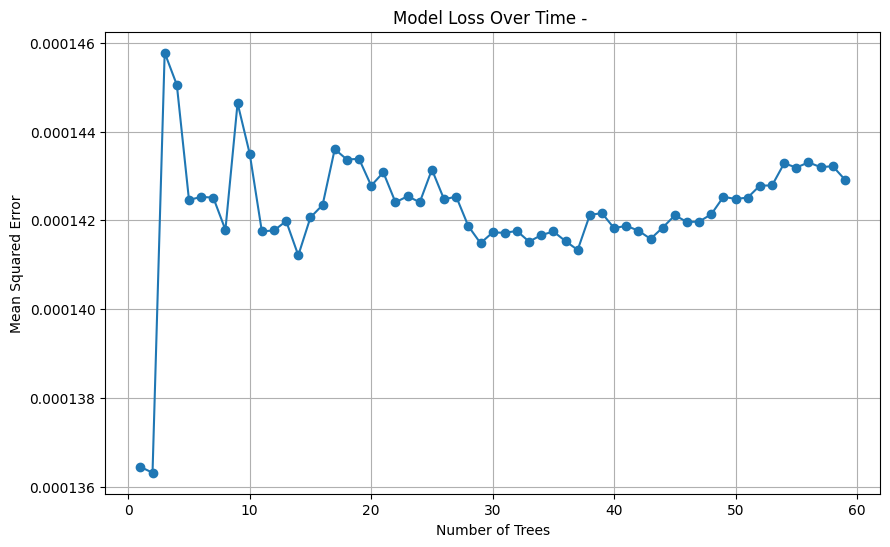

Calculating SHAP values: 100%|██████████| 4680/4680 [01:18<00:00, 59.75it/s]


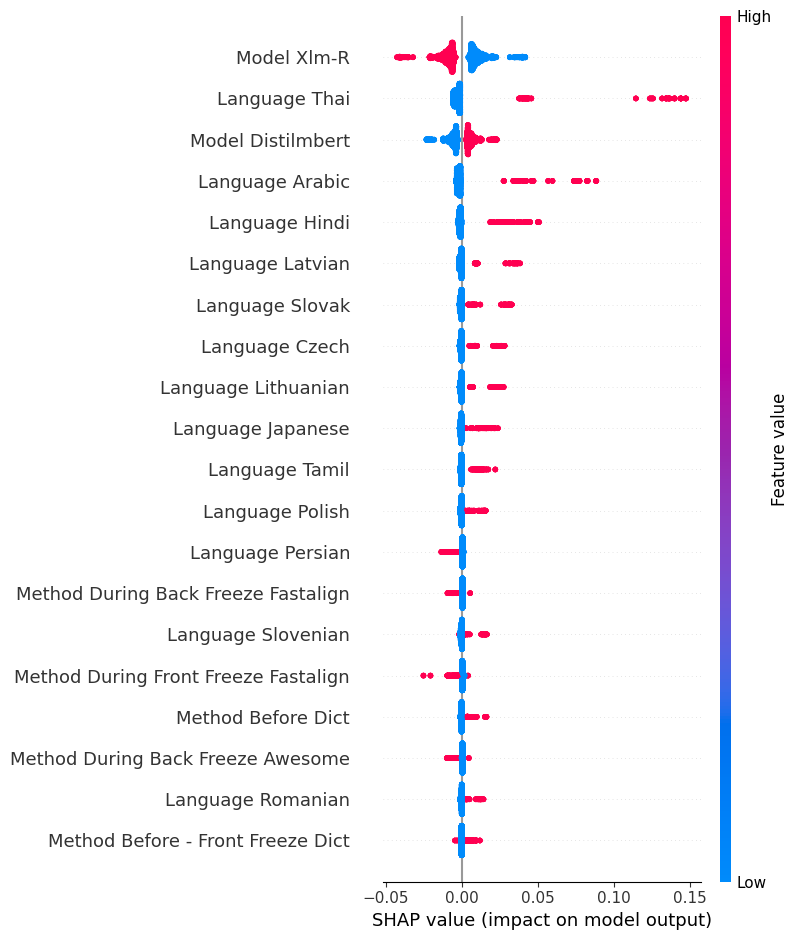

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


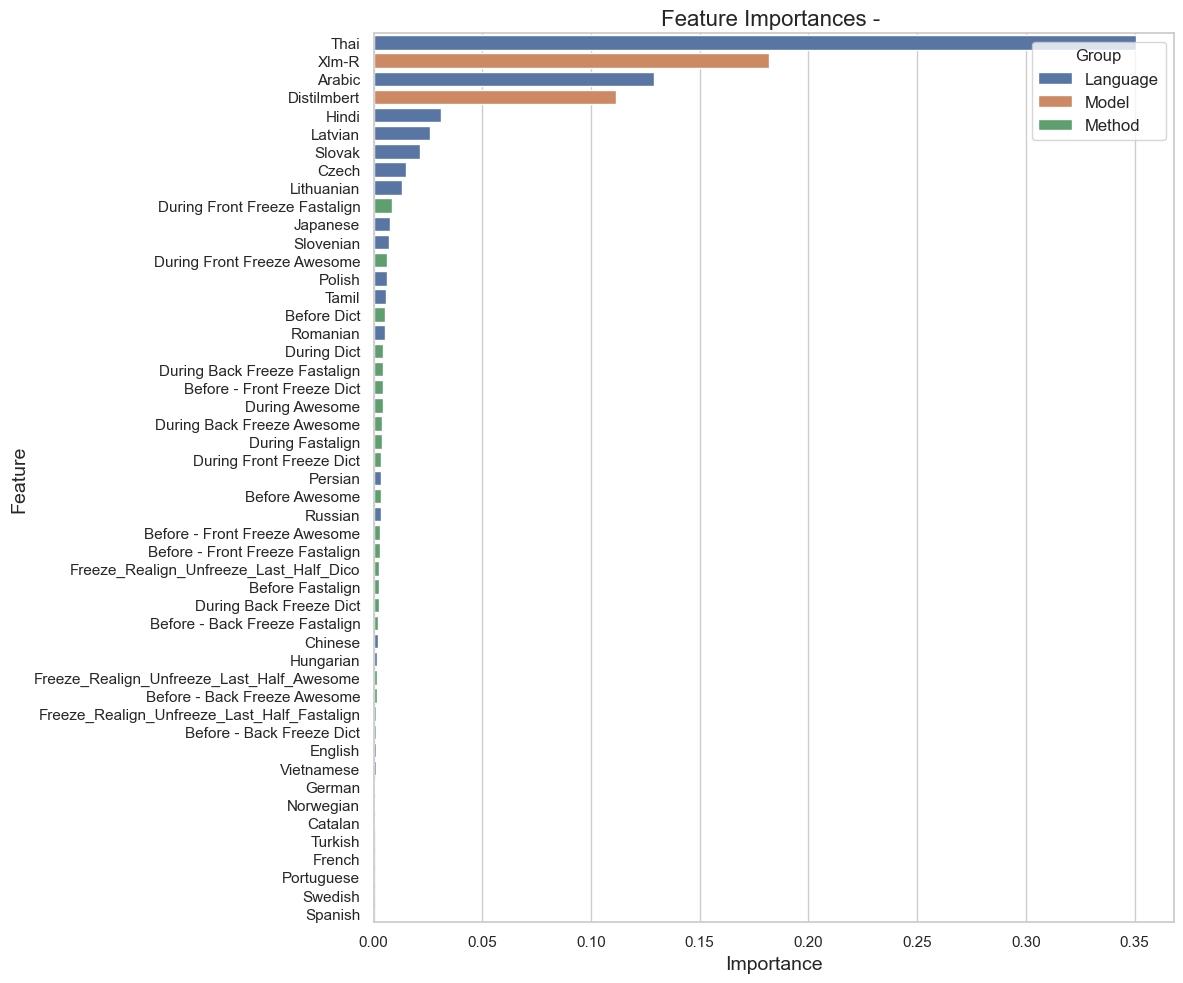

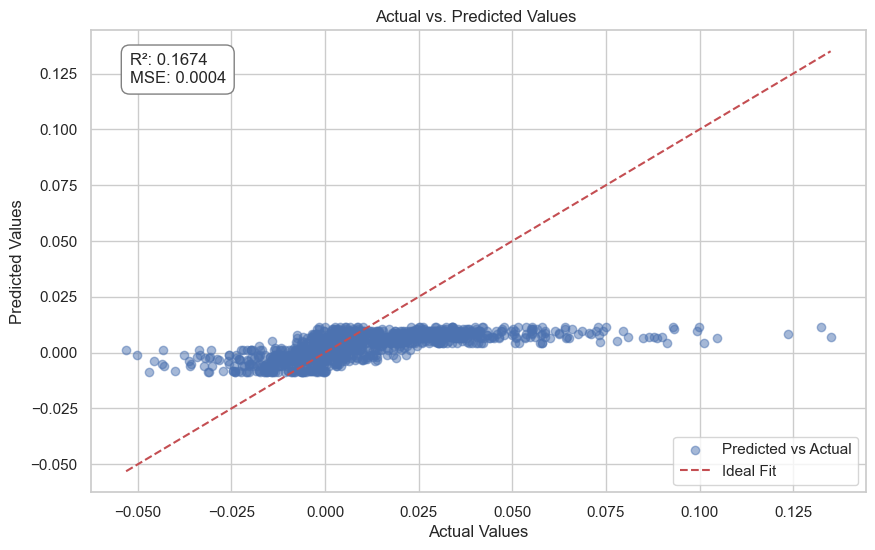

Feature Importances:
model_XLM-R                                           0.181942
model_distilMBERT                                     0.111650
method_Before - Back Freeze Awesome                   0.001538
method_Before - Back Freeze Dict                      0.001035
method_Before - Back Freeze FastAlign                 0.001986
method_Before - Front Freeze Awesome                  0.003172
method_Before - Front Freeze Dict                     0.004314
method_Before - Front Freeze FastAlign                0.002764
method_Before Awesome                                 0.003341
method_Before Dict                                    0.005491
method_Before FastAlign                               0.002671
method_During Awesome                                 0.004173
method_During Back Freeze Awesome                     0.003946
method_During Back Freeze Dict                        0.002347
method_During Back Freeze FastAlign                   0.004360
method_During Dict                

In [35]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, use_linear_regressor=False)

print("Feature Importances:")
print(coefficients)

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


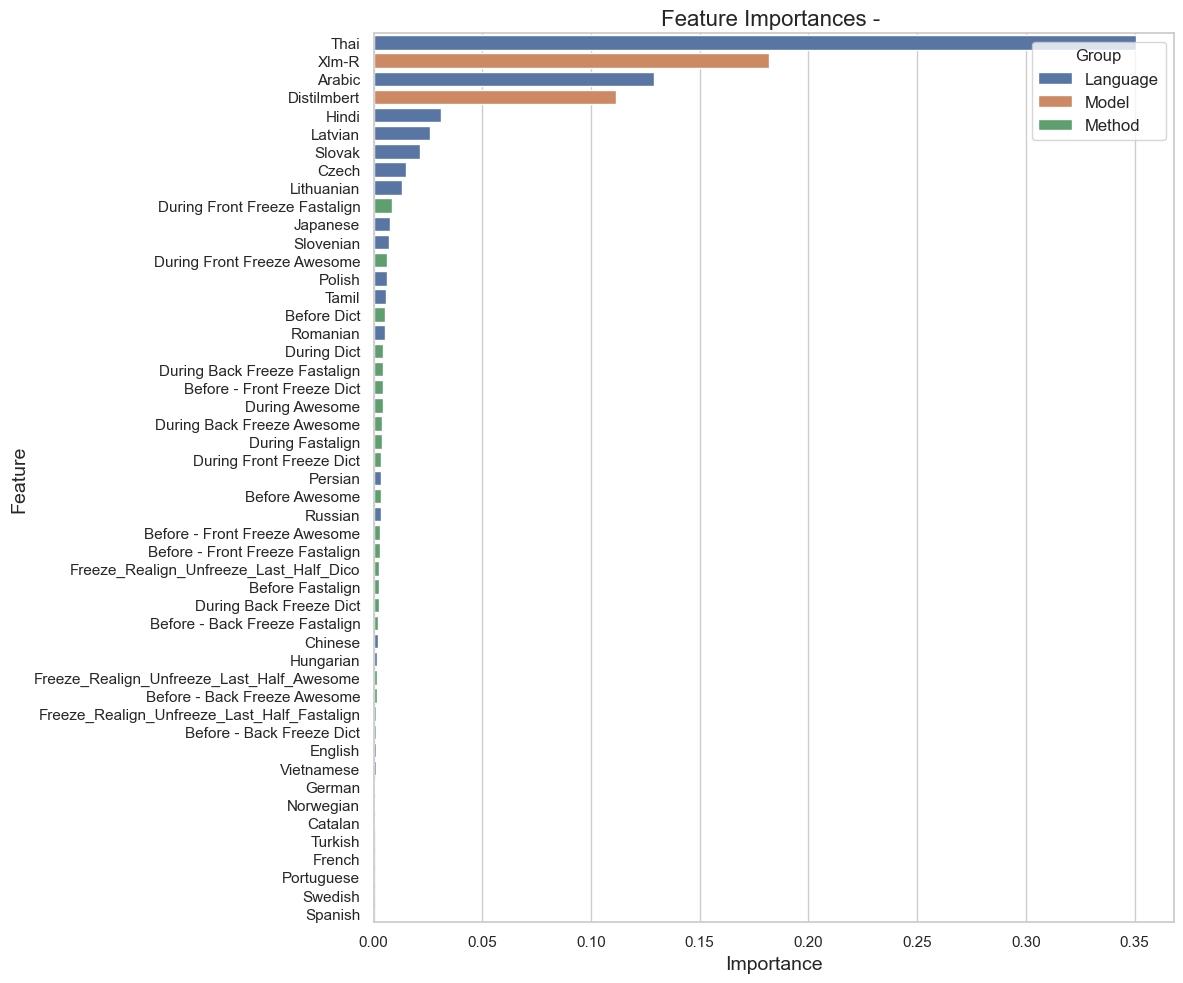

In [36]:
plot_feature_importances(coefficients, encoded_columns)

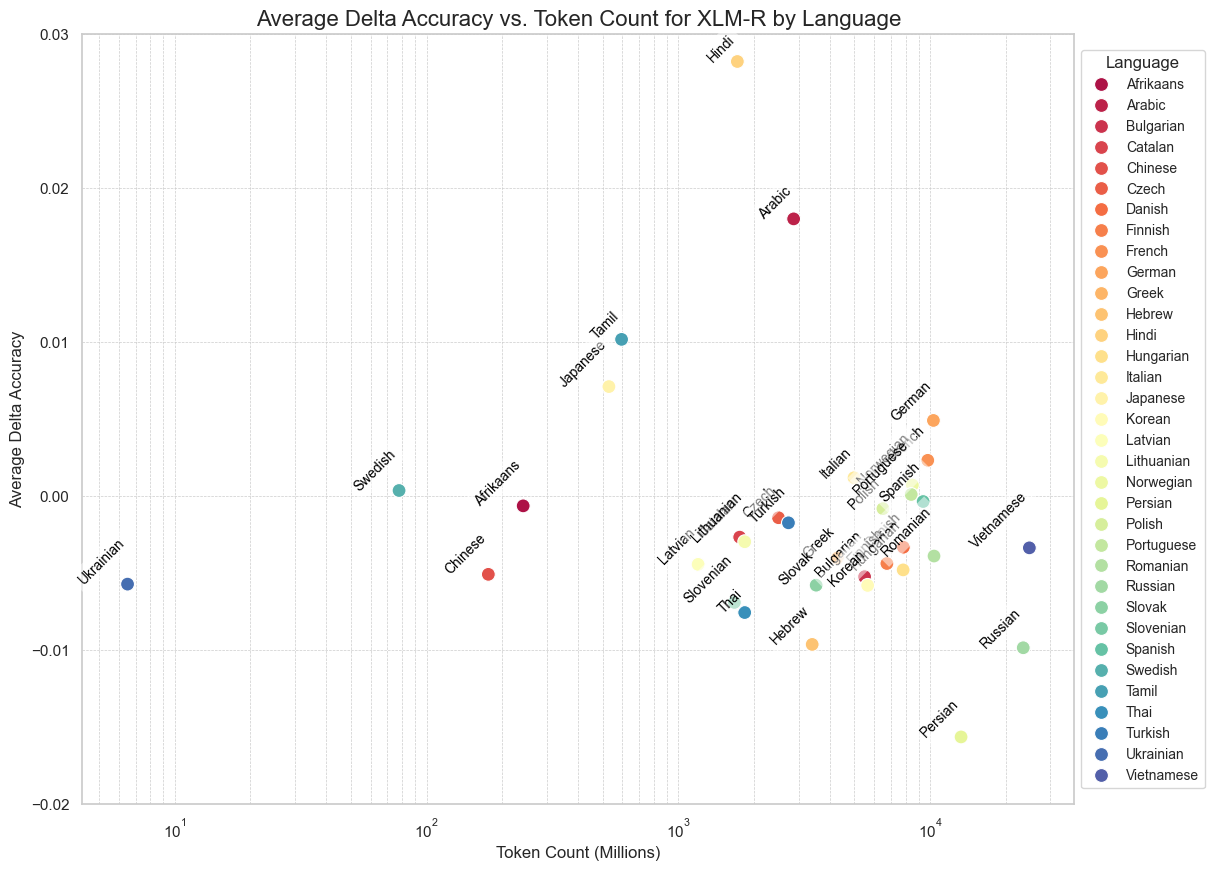

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert token data to DataFrame
token_df = pd.DataFrame(list(xlmr_token_data.items()), columns=['language', 'tokens_millions'])

# Merge token data with xlmr_df_tokens
xlmr_df_tokens = combined_df[combined_df['model'] == 'XLM-R']
merged_df = xlmr_df_tokens.merge(token_df, on='language')

# Calculate the average delta accuracy for each language
average_delta_accuracy = merged_df.groupby('language')['delta_accuracy'].mean().reset_index()

# Merge average delta accuracy with token data
final_df = average_delta_accuracy.merge(token_df, on='language')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(16, 10))

# Plot the data
sns.scatterplot(data=final_df, x='tokens_millions', y='delta_accuracy', hue='language', palette='Spectral', s=100, ax=ax)

# Set the y-axis limits to focus on the range of delta accuracy values
ax.set_ylim(-0.02, 0.03)

# Add annotations for each language with rotation and better placement
for i in range(final_df.shape[0]):
    ax.text(x=final_df.tokens_millions[i], 
            y=final_df.delta_accuracy[i], 
            s=final_df.language[i], 
            fontdict=dict(color='black', size=10),
            rotation=45,
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

ax.set_title('Average Delta Accuracy vs. Token Count for XLM-R by Language', fontsize=16)
ax.set_xlabel('Token Count (Millions)', fontsize=12)
ax.set_ylabel('Average Delta Accuracy', fontsize=12)
ax.set_xscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Shrink the plot to make room for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put the legend outside the plot on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Language', fontsize=10)

plt.show()

In [38]:
import pandas as pd

# Load and transpose the dataset
uri_data = pd.read_csv('./Raw URIEL Language Data.csv').transpose()

# Reset the index and set the first row as the header
uri_data.reset_index(inplace=True)
uri_data.columns = uri_data.iloc[0]
uri_data = uri_data.drop(uri_data.index[0])

# Clean up column names
uri_data.columns = uri_data.columns.str.replace('\n', '', regex=True).str.replace('↓', '', regex=True).str.strip()

# Drop unnecessary columns
columns_to_drop = ['ISO 639-3 Code', 'Features']
uri_data.drop(columns=[col for col in columns_to_drop if col in uri_data.columns], inplace=True)

# Replace placeholder text with NaN in the 'S_SVO' column
uri_data['S_SVO'] = uri_data['S_SVO'].replace('NO INFORMATION FOR ANY FEATURE', pd.NA)

# Drop the 'S_SVO' column if it only contains NaN (i.e., if it is no longer useful)
if uri_data['S_SVO'].isna().all():
    uri_data.drop(columns=['S_SVO'], inplace=True)

# Drop columns with any NaN values
uri_data.dropna(axis=1, inplace=True)

# Clean up the 'Families' column
if 'Families' in uri_data.columns:
    uri_data['Families'] = uri_data['Families'].str.replace(r'[\n\r]+', ', ', regex=True)
    uri_data['Families'] = uri_data['Families'].str.replace('F_', '')
    uri_data['Families'] = uri_data['Families'].str.replace(', ,', ', ')
    # Keep only the first family listed
    uri_data['Families'] = uri_data['Families'].apply(lambda x: x.split(',')[0] if pd.notna(x) else x)

# Specifically, find the row for Norwegian and update its family
norwegian_index = uri_data[uri_data['Languages'] == 'Norwegian'].index
if not norwegian_index.empty:
    uri_data.at[norwegian_index[0], 'Families'] = "Indo-European"


# uri_data.to_csv('./cleaned_uri_data.csv')


In [98]:
# Specify the columns containing geographic coordinates
gc_columns = [col for col in uri_data.columns if col.startswith('GC_')]
uri_data[gc_columns] = uri_data[gc_columns].apply(pd.to_numeric, errors='coerce')

def extract_coordinates(column_name):
    """Extract latitude and longitude from the column name."""
    _, lat, lon = column_name.split('_')
    return float(lat), float(lon)

def find_closest_coordinates(uri_data, gc_columns):
    closest_coordinates = {}
    for i, row in uri_data.iterrows():
        language = row['Languages']
        closest_column = row[gc_columns].idxmin()  # Find the column with the minimum value
        closest_coordinates[language] = closest_column  # Store the column name
    return closest_coordinates

def calculate_geographic_distances(language_of_interest, uri_data, closest_coordinates):
    # Ensure the language of interest exists in the dataset
    if language_of_interest not in closest_coordinates:
        raise ValueError(f"Language '{language_of_interest}' not found in the dataset.")
    
    # Extract the geographic coordinate column for the language of interest
    target_coord_column = closest_coordinates[language_of_interest]
    target_lat, target_lon = extract_coordinates(target_coord_column)
    
    # Calculate the Euclidean distance from the target language to each other language
    distance_results = []
    for language, coord_column in closest_coordinates.items():
        if language != language_of_interest:
            lat, lon = extract_coordinates(coord_column)
            distance = np.linalg.norm([target_lat - lat, target_lon - lon])  # Euclidean distance
            distance_results.append({
                'language': language,
                'Distance': distance,
                'Nearest_Coordinate_Column': coord_column,
                'Latitude': lat,
                'Longitude': lon
            })
    
    # Convert the results to a DataFrame for easy viewing
    distance_df = pd.DataFrame(distance_results)
    return distance_df

def find_nearest_neighbors(language_of_interest, uri_data, n_neighbors=5):
    # Find the closest coordinates for each language
    closest_coordinates = find_closest_coordinates(uri_data, gc_columns)
    
    # Calculate geographic distances for the language of interest
    distance_df = calculate_geographic_distances(language_of_interest, uri_data, closest_coordinates)
    
    # Sort the distances and get the top N nearest neighbors
    nearest_neighbors_df = distance_df.sort_values(by='Distance').head(n_neighbors)
    
    return nearest_neighbors_df

In [40]:
# Find the closest coordinates for each language
closest_coordinates = find_closest_coordinates(uri_data, gc_columns)

distances = calculate_geographic_distances('English', uri_data, closest_coordinates)

distances.rename(columns={'Language': 'language'}, inplace=True)
distances

language    Distance Nearest_Coordinate_Column  Latitude  Longitude
0    Afrikaans   79.479557                 GC_-20_24     -20.0       24.0
1       Arabic   43.829214                  GC_29_31      29.0       31.0
2    Bulgarian   32.249031                  GC_38_23      38.0       23.0
3      Catalan   14.422205                   GC_42_3      42.0        3.0
4      Chinese  113.991228                 GC_39_108      39.0      108.0
5        Czech   20.615528                  GC_49_15      49.0       15.0
6       Danish   20.615528                  GC_49_15      49.0       15.0
7      Finnish   33.241540                  GC_58_28      58.0       28.0
8       French   14.422205                   GC_42_3      42.0        3.0
9       German   20.615528                  GC_49_15      49.0       15.0
10       Greek   32.249031                  GC_38_23      38.0       23.0
11      Hebrew   43.829214                  GC_29_31      29.0       31.0
12       Hindi   92.048900                  GC_27_83      27.0       83.0
13   Hungarian   20.615528                  GC_49_15      49.0       15.0
14     Italian   20.615528                  GC_49_15      49.0       15.0
15    Japanese  134.350288                 GC_35_128      35.0      128.0
16      Korean  134.350288                 GC_35_128      35.0      128.0
17     Latvian   33.241540                  GC_58_28      58.0       28.0
18  Lithuanian   33.241540                  GC_58_28      58.0       28.0
19   Norwegian   16.401219                   GC_64_8      64.0        8.0
20     Persian   71.784399                  GC_31_63      31.0       63.0
21   Portugese   14.422205                   GC_42_3      42.0        3.0
22    Romanian   20.615528                  GC_49_15      49.0       15.0
23     Russian   85.023526                  GC_56_80      56.0       80.0
24      Slovak   20.615528                  GC_49_15      49.0       15.0
25   Slovenian   20.615528                  GC_49_15      49.0       15.0
26     Spanish   14.422205                   GC_42_3      42.0        3.0
27     Swedish   33.241540                  GC_58_28      58.0       28.0
28       Tamil   93.471921                  GC_13_79      13.0       79.0
29        Thai  112.924754                  GC_10_99      10.0       99.0
30     Turkish   41.976184                  GC_45_36      45.0       36.0
31    Ukranian   20.615528                  GC_49_15      49.0       15.0
32  Vietnamese  122.380554                 GC_15_111      15.0      111.0

In [41]:
# Merge the distances DataFrame with the combined DataFrame on the 'language' column
combined_df_with_distances = combined_df.merge(distances, on='language', how='left')

# Add the Families column from uri_data
uri_data_subset = uri_data[['Languages', 'Families']]
uri_data_subset.rename(columns={'Languages': 'language'}, inplace=True)

# Merge Families into combined_df
combined_df_with_distances = combined_df_with_distances.merge(uri_data_subset, on='language', how='left')

# Drop duplicate Distance columns if present
if 'Distance_x' in combined_df_with_distances.columns and 'Distance_y' in combined_df_with_distances.columns:
    combined_df_with_distances.drop(columns=['Distance_x'], inplace=True)
    combined_df_with_distances.rename(columns={'Distance_y': 'Distance'}, inplace=True)

# Drop duplicate Families columns if present
if 'Families_x' in combined_df_with_distances.columns and 'Families_y' in combined_df_with_distances.columns:
    combined_df_with_distances.drop(columns=['Families_x'], inplace=True)
    combined_df_with_distances.rename(columns={'Families_y': 'Families'}, inplace=True)

# Drop rows where 'Distance' is NaN
combined_df_with_distances.dropna(subset=['Distance'], inplace=True)

# Drop rows where 'language' is 'Average'
combined_df_with_distances = combined_df_with_distances[combined_df_with_distances['language'] != 'Average']

# Drop unnecessary columns
columns_to_drop = ['Nearest_Coordinate_Column', 'Nearest_Coordinate_Value', 'Latitude', 'Longitude']
combined_df_with_distances.drop(columns=[col for col in columns_to_drop if col in combined_df_with_distances.columns], inplace=True)

combined_df_with_distances.head()  # Display the head of the combined DataFrame to verify the changes


C:\Users\alith\AppData\Local\Temp\ipykernel_97092\3150713915.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uri_data_subset.rename(columns={'Languages': 'language'}, inplace=True)


model            method   language  seed  accuracy  delta_accuracy  \
2  XLM-R  Before FastAlign  Afrikaans    17  0.885544        0.002683   
3  XLM-R  Before FastAlign     Arabic    17  0.667102        0.044768   
4  XLM-R  Before FastAlign  Bulgarian    17  0.891694        0.004515   
5  XLM-R  Before FastAlign    Catalan    17  0.894724        0.000534   
6  XLM-R  Before FastAlign      Czech    17  0.871849        0.016238   

    Distance       Families  
2  79.479557  Indo-European  
3  43.829214   Afro-Asiatic  
4  32.249031  Indo-European  
5  14.422205  Indo-European  
6  20.615528  Indo-European

In [42]:
combined_df_with_distances

model                                       method    language  \
2           XLM-R                             Before FastAlign   Afrikaans   
3           XLM-R                             Before FastAlign      Arabic   
4           XLM-R                             Before FastAlign   Bulgarian   
5           XLM-R                             Before FastAlign     Catalan   
6           XLM-R                             Before FastAlign       Czech   
...           ...                                          ...         ...   
6475  distilMBERT                   During Back Freeze Awesome  Vietnamese   
6476  distilMBERT                      During Back Freeze Dict  Vietnamese   
6477  distilMBERT  freeze_realign_unfreeze_last_half_fastalign  Vietnamese   
6478  distilMBERT    freeze_realign_unfreeze_last_half_awesome  Vietnamese   
6479  distilMBERT       freeze_realign_unfreeze_last_half_dico  Vietnamese   

      seed  accuracy  delta_accuracy    Distance       Families  
2       17  0.885544        0.002683   79.479557  Indo-European  
3       17  0.667102        0.044768   43.829214   Afro-Asiatic  
4       17  0.891694        0.004515   32.249031  Indo-European  
5       17  0.894724        0.000534   14.422205  Indo-European  
6       17  0.871849        0.016238   20.615528  Indo-European  
...    ...       ...             ...         ...            ...  
6475    66  0.569218       -0.010874  122.380554  Austroasiatic  
6476    66  0.586951        0.006859  122.380554  Austroasiatic  
6477    66  0.570724       -0.009368  122.380554  Austroasiatic  
6478    66  0.576746       -0.003346  122.380554  Austroasiatic  
6479    66  0.580259        0.000167  122.380554  Austroasiatic  

[5580 rows x 8 columns]

In [43]:
# combined_df_with_distances = add_language_distances_to_df(combined_df)

In [44]:
# combined_df_with_distances = combined_df_with_distances[~combined_df_with_distances.isna().any(axis=1)]

# combined_df_with_distances = combined_df

In [45]:
train_dist_data, val_dist_data, test_dist_data = split_train_val_test(combined_df_with_distances, use_standard_split=True)

In [46]:
train_dist_data

model                           method   language  delta_accuracy  \
0           XLM-R                   During Awesome    Chinese       -0.009240   
1     distilMBERT                 During FastAlign  Afrikaans        0.000894   
2           XLM-R                   During Awesome      Tamil        0.003207   
3     distilMBERT                 During FastAlign       Thai        0.203706   
4     distilMBERT     During Back Freeze FastAlign  Afrikaans        0.002881   
...           ...                              ...        ...             ...   
3900  distilMBERT      During Front Freeze Awesome     Slovak        0.038650   
3901  distilMBERT    Before - Front Freeze Awesome     German        0.004531   
3902  distilMBERT  Before - Front Freeze FastAlign     Hebrew        0.040544   
3903  distilMBERT       Before - Front Freeze Dict    Persian        0.023538   
3904        XLM-R                      During Dict     Slovak       -0.018482   

        Distance       Families  
0     113.991228   Sino-Tibetan  
1      79.479557  Indo-European  
2      93.471921      Dravidian  
3     112.924754      Tai-Kadai  
4      79.479557  Indo-European  
...          ...            ...  
3900   20.615528  Indo-European  
3901   20.615528  Indo-European  
3902   43.829214   Afro-Asiatic  
3903   71.784399  Indo-European  
3904   20.615528  Indo-European  

[3905 rows x 6 columns]

In [47]:
val_dist_data

model                                  method  language  \
0          XLM-R          Before - Back Freeze FastAlign    Korean   
1    distilMBERT  freeze_realign_unfreeze_last_half_dico   Persian   
2          XLM-R                During Front Freeze Dict     Hindi   
3    distilMBERT             During Front Freeze Awesome      Thai   
4    distilMBERT                        Before FastAlign     Hindi   
..           ...                                     ...       ...   
553  distilMBERT                          During Awesome  Japanese   
554        XLM-R          Before - Back Freeze FastAlign   Swedish   
555        XLM-R                        During FastAlign   Catalan   
556  distilMBERT  freeze_realign_unfreeze_last_half_dico    German   
557  distilMBERT                        During FastAlign   Latvian   

     delta_accuracy    Distance       Families  
0         -0.030915  134.350288       Koreanic  
1         -0.022310   71.784399  Indo-European  
2          0.031866   92.048900  Indo-European  
3          0.144756  112.924754      Tai-Kadai  
4          0.070223   92.048900  Indo-European  
..              ...         ...            ...  
553        0.081626  134.350288        Japonic  
554        0.000629   33.241540  Indo-European  
555       -0.006446   14.422205  Indo-European  
556        0.010911   20.615528  Indo-European  
557        0.062366   33.241540  Indo-European  

[558 rows x 6 columns]

In [48]:
test_dist_data

model                           method    language  \
0           XLM-R   Before - Back Freeze FastAlign     Finnish   
1           XLM-R  Before - Front Freeze FastAlign       Czech   
2     distilMBERT                      Before Dict     Persian   
3           XLM-R                   Before Awesome   Afrikaans   
4           XLM-R     Before - Back Freeze Awesome     Persian   
...           ...                              ...         ...   
1112  distilMBERT       During Back Freeze Awesome  Lithuanian   
1113  distilMBERT    During Front Freeze FastAlign      Arabic   
1114  distilMBERT                   Before Awesome   Slovenian   
1115        XLM-R     Before - Back Freeze Awesome   Hungarian   
1116        XLM-R          During Back Freeze Dict     Swedish   

      delta_accuracy   Distance       Families  
0          -0.010175  33.241540         Uralic  
1           0.009615  20.615528  Indo-European  
2          -0.013795  71.784399  Indo-European  
3           0.005663  79.479557  Indo-European  
4          -0.010397  71.784399  Indo-European  
...              ...        ...            ...  
1112        0.068584  33.241540  Indo-European  
1113        0.062071  43.829214   Afro-Asiatic  
1114        0.039991  20.615528  Indo-European  
1115       -0.013207  20.615528         Uralic  
1116        0.005135  33.241540  Indo-European  

[1117 rows x 6 columns]

100%|██████████| 59/59 [00:00<00:00, 86.48it/s]


Final Test MSE for  (Random Forest): 0.00023250995772650476


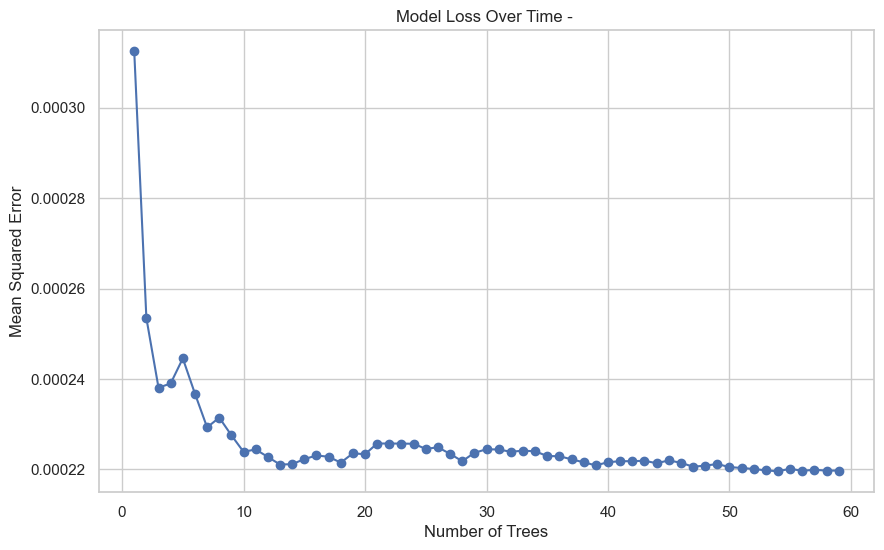

Calculating SHAP values: 100%|██████████| 3905/3905 [00:35<00:00, 110.13it/s]


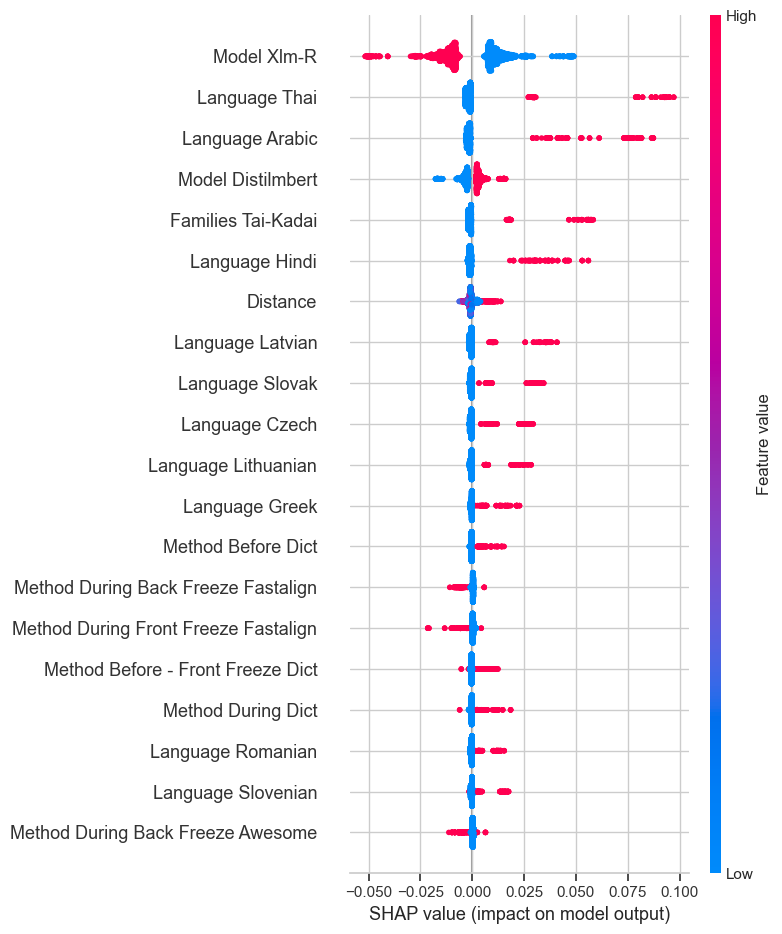

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


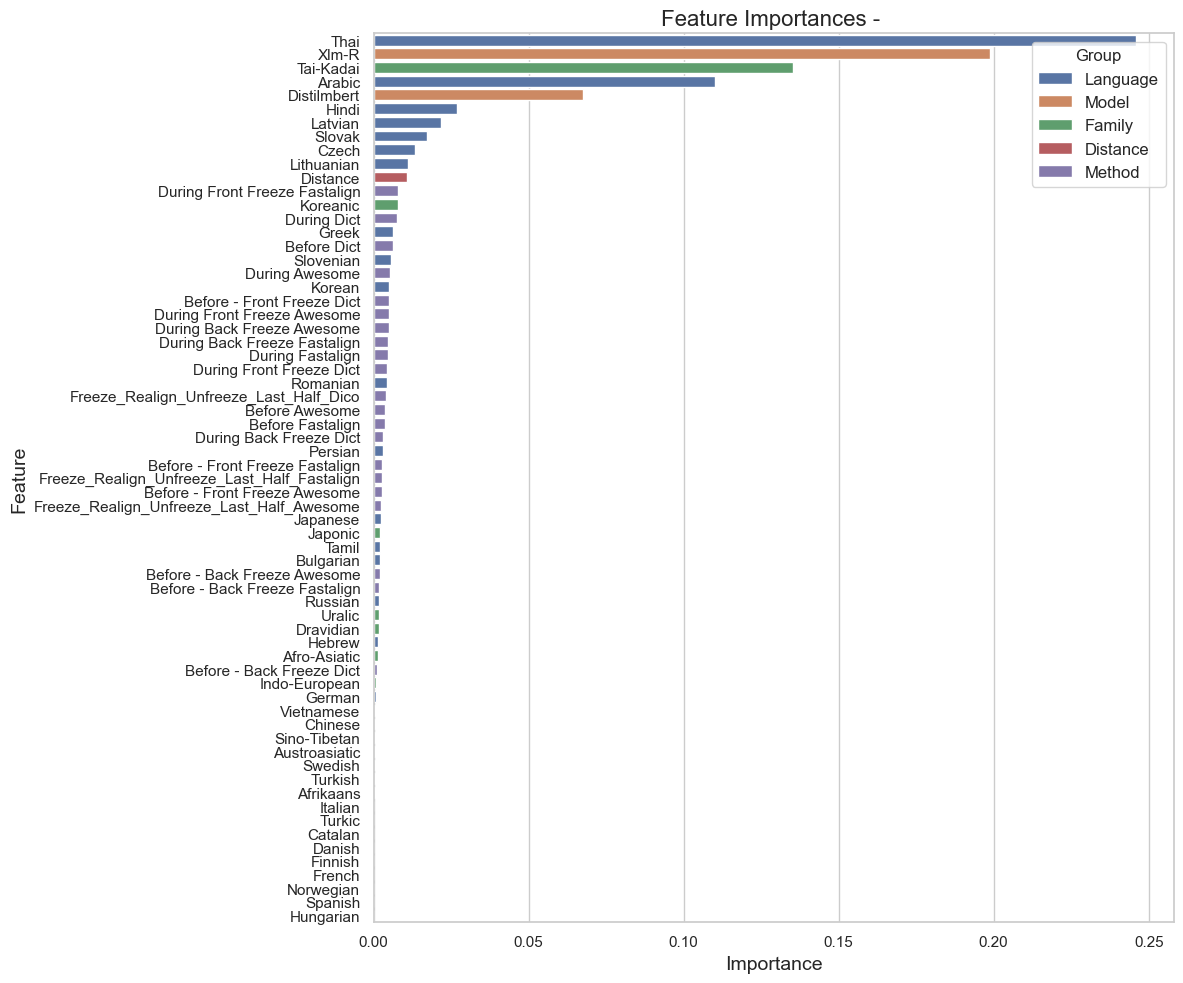

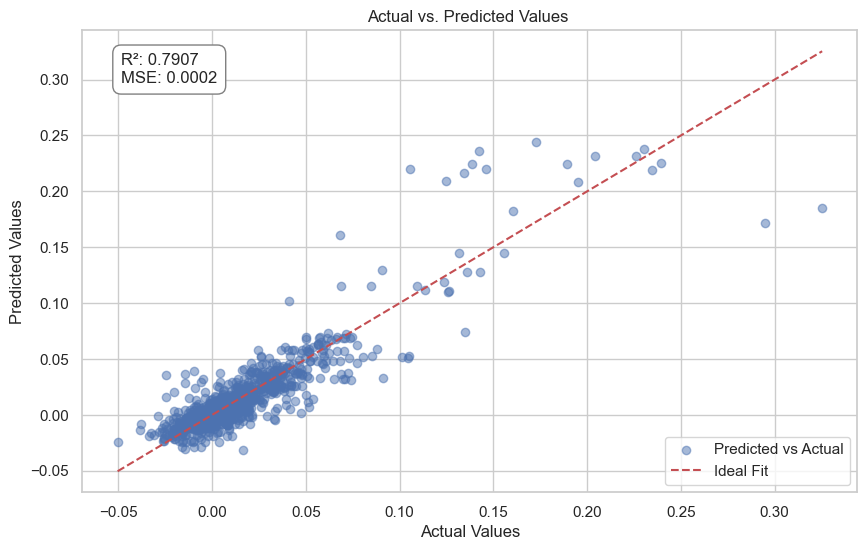

Feature Importances:
Distance                               0.010645
model_XLM-R                            0.198894
model_distilMBERT                      0.067457
method_Before - Back Freeze Awesome    0.002007
method_Before - Back Freeze Dict       0.001146
                                         ...   
Families_Koreanic                      0.007846
Families_Sino-Tibetan                  0.000487
Families_Tai-Kadai                     0.135207
Families_Turkic                        0.000254
Families_Uralic                        0.001790
Length: 65, dtype: float64


In [49]:
dist_coefficients, dist_encoded_columns = perform_regression(train_dist_data, val_dist_data, test_dist_data)

print("Feature Importances:")
print(dist_coefficients)

In [50]:
dist_encoded_columns

Index(['Distance', 'model_XLM-R', 'model_distilMBERT',
       'method_Before - Back Freeze Awesome',
       'method_Before - Back Freeze Dict',
       'method_Before - Back Freeze FastAlign',
       'method_Before - Front Freeze Awesome',
       'method_Before - Front Freeze Dict',
       'method_Before - Front Freeze FastAlign', 'method_Before Awesome',
       'method_Before Dict', 'method_Before FastAlign',
       'method_During Awesome', 'method_During Back Freeze Awesome',
       'method_During Back Freeze Dict', 'method_During Back Freeze FastAlign',
       'method_During Dict', 'method_During FastAlign',
       'method_During Front Freeze Awesome', 'method_During Front Freeze Dict',
       'method_During Front Freeze FastAlign',
       'method_freeze_realign_unfreeze_last_half_awesome',
       'method_freeze_realign_unfreeze_last_half_dico',
       'method_freeze_realign_unfreeze_last_half_fastalign',
       'language_Afrikaans', 'language_Arabic', 'language_Bulgarian',
       'l

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


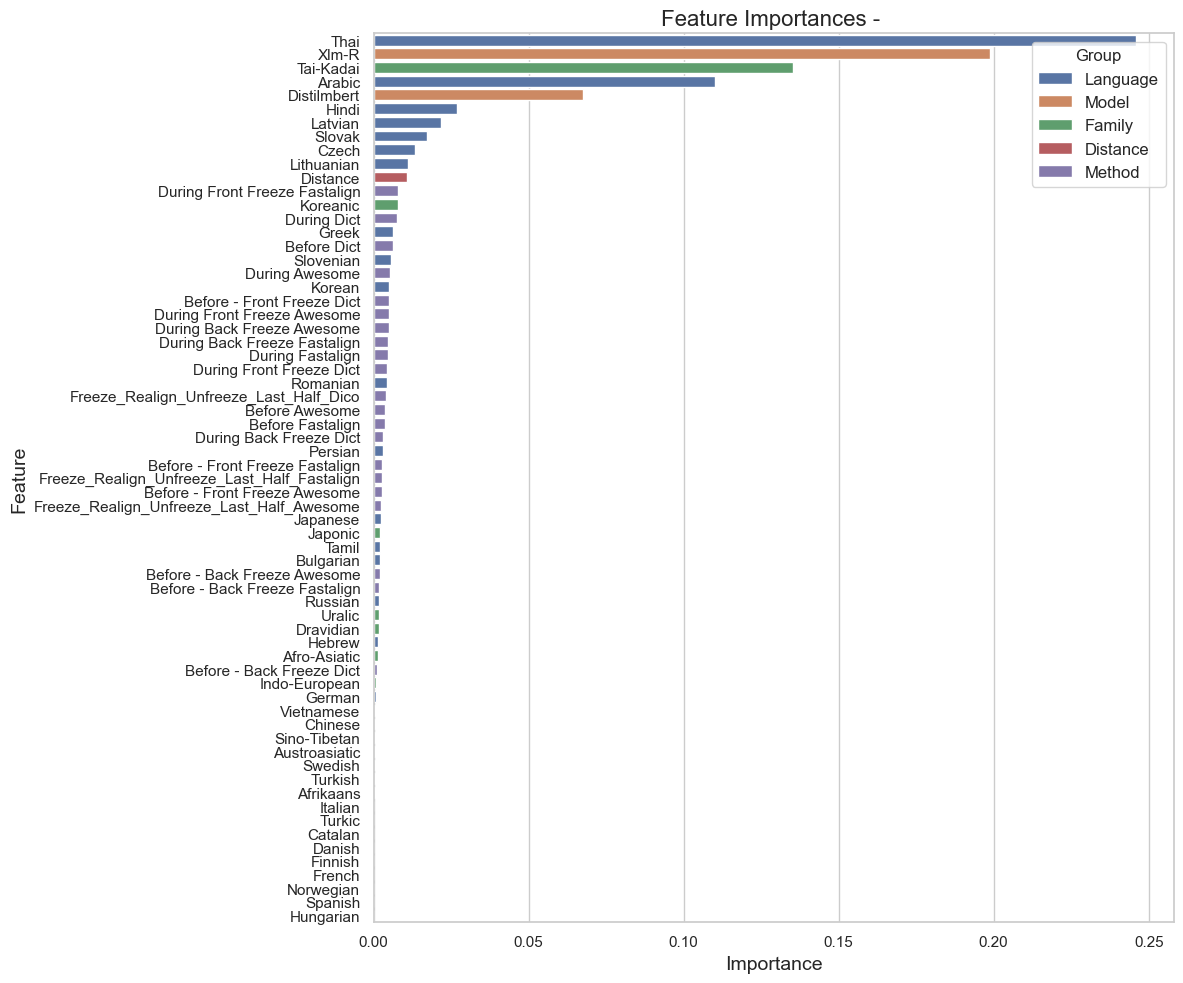

In [51]:
plot_feature_importances(dist_coefficients, dist_encoded_columns, group_by_distance=True)

In [88]:
def flag_freeze_methods(df, method_col='method'):
    df['method_type'] = df[method_col].apply(lambda x: 'freeze' if 'freeze' in x.lower() else 'vanilla')
    return df

In [53]:
combined_df_with_flags = flag_freeze_methods(combined_df_with_distances)
combined_df_with_flags = combined_df_with_flags[~combined_df_with_flags.isna().any(axis=1)]

In [89]:
combined_df_with_flags

model                                       method    language  \
2           XLM-R                             Before FastAlign   Afrikaans   
3           XLM-R                             Before FastAlign      Arabic   
4           XLM-R                             Before FastAlign   Bulgarian   
5           XLM-R                             Before FastAlign     Catalan   
6           XLM-R                             Before FastAlign       Czech   
...           ...                                          ...         ...   
6475  distilMBERT                   During Back Freeze Awesome  Vietnamese   
6476  distilMBERT                      During Back Freeze Dict  Vietnamese   
6477  distilMBERT  freeze_realign_unfreeze_last_half_fastalign  Vietnamese   
6478  distilMBERT    freeze_realign_unfreeze_last_half_awesome  Vietnamese   
6479  distilMBERT       freeze_realign_unfreeze_last_half_dico  Vietnamese   

      seed  accuracy  delta_accuracy    Distance       Families method_type  
2       17  0.885544        0.002683   79.479557  Indo-European     vanilla  
3       17  0.667102        0.044768   43.829214   Afro-Asiatic     vanilla  
4       17  0.891694        0.004515   32.249031  Indo-European     vanilla  
5       17  0.894724        0.000534   14.422205  Indo-European     vanilla  
6       17  0.871849        0.016238   20.615528  Indo-European     vanilla  
...    ...       ...             ...         ...            ...         ...  
6475    66  0.569218       -0.010874  122.380554  Austroasiatic      freeze  
6476    66  0.586951        0.006859  122.380554  Austroasiatic      freeze  
6477    66  0.570724       -0.009368  122.380554  Austroasiatic      freeze  
6478    66  0.576746       -0.003346  122.380554  Austroasiatic      freeze  
6479    66  0.580259        0.000167  122.380554  Austroasiatic      freeze  

[5580 rows x 9 columns]

Using all data



100%|██████████| 59/59 [00:00<00:00, 82.41it/s]



Final Test MSE for Using all data (Random Forest): 0.00023250995772650476


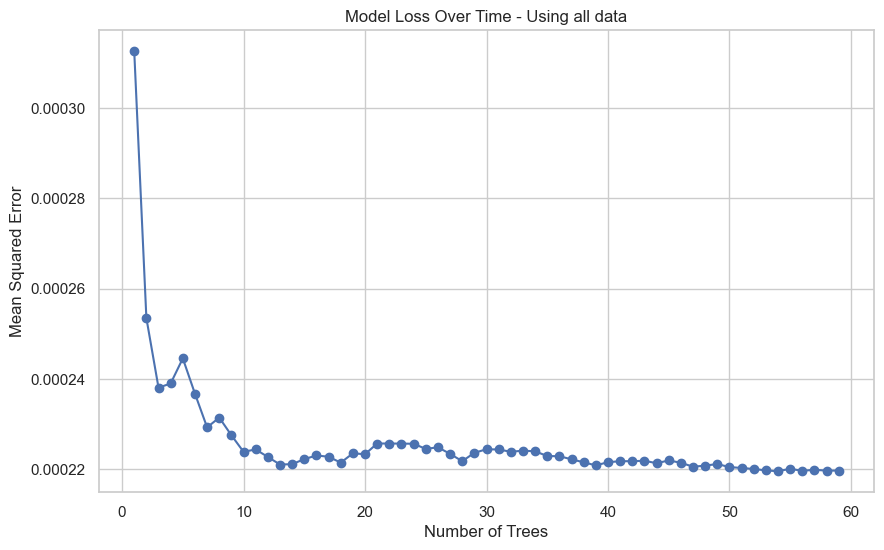

Calculating SHAP values: 100%|██████████| 3905/3905 [00:35<00:00, 111.25it/s]


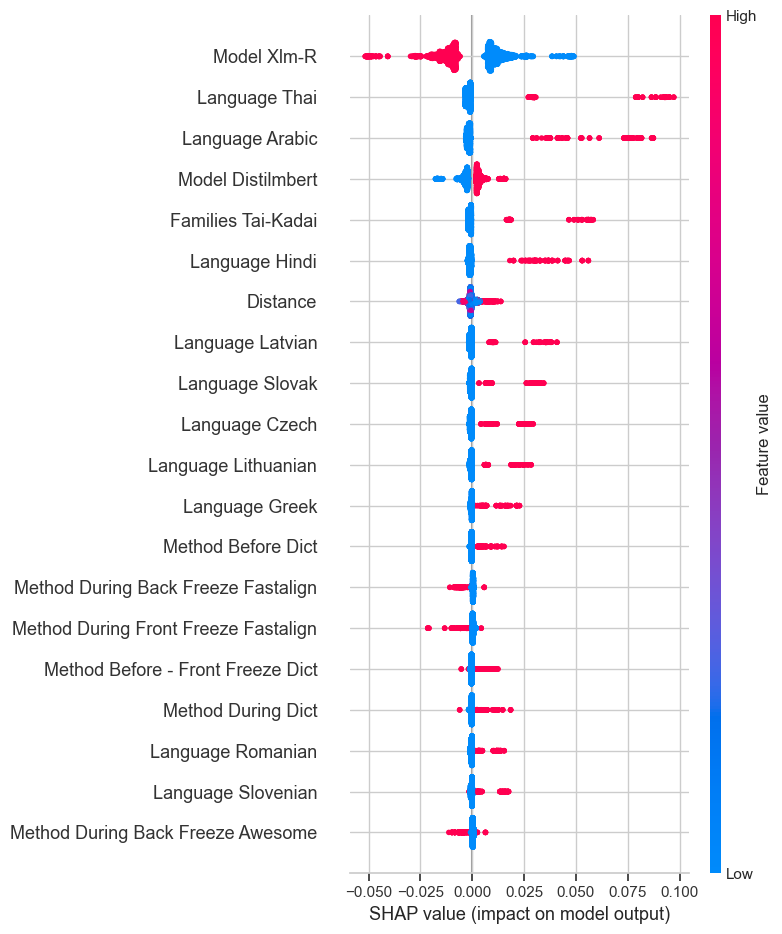

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


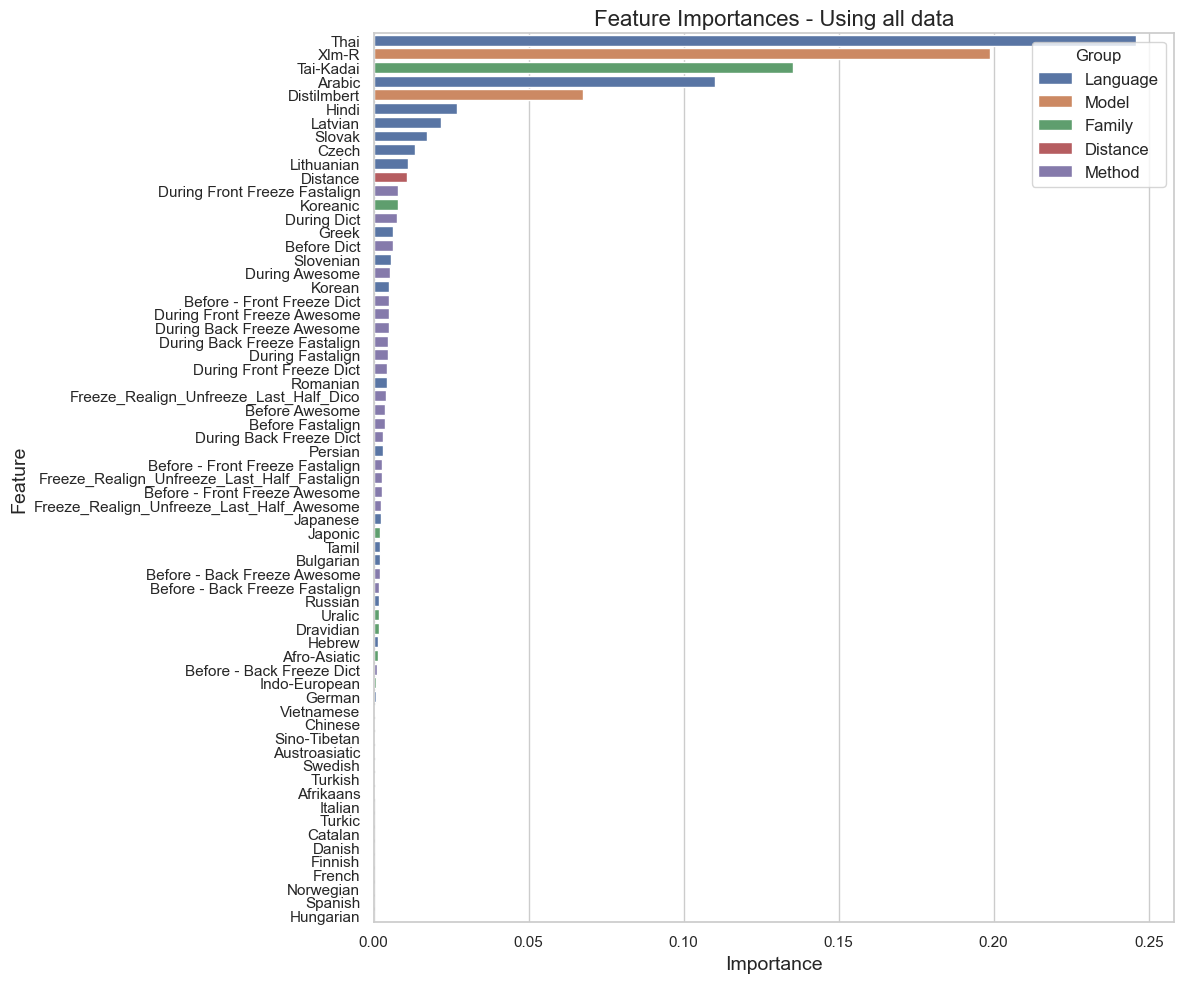

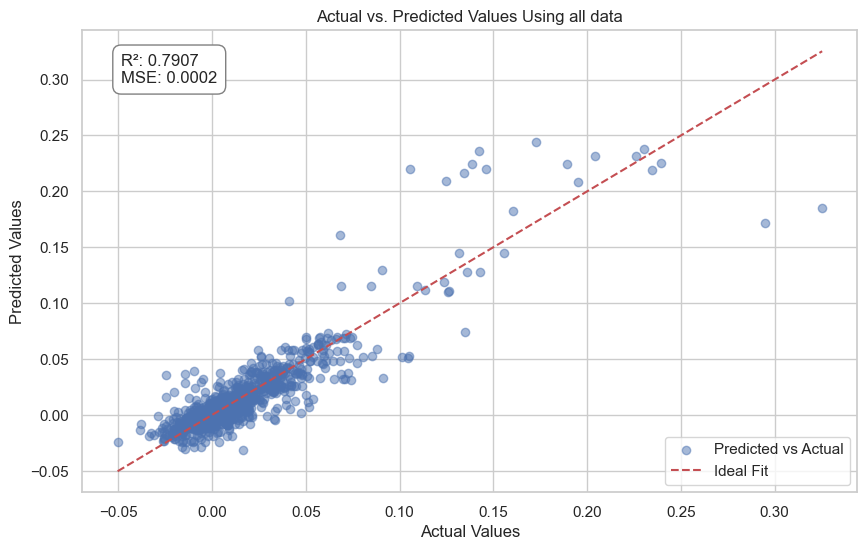

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


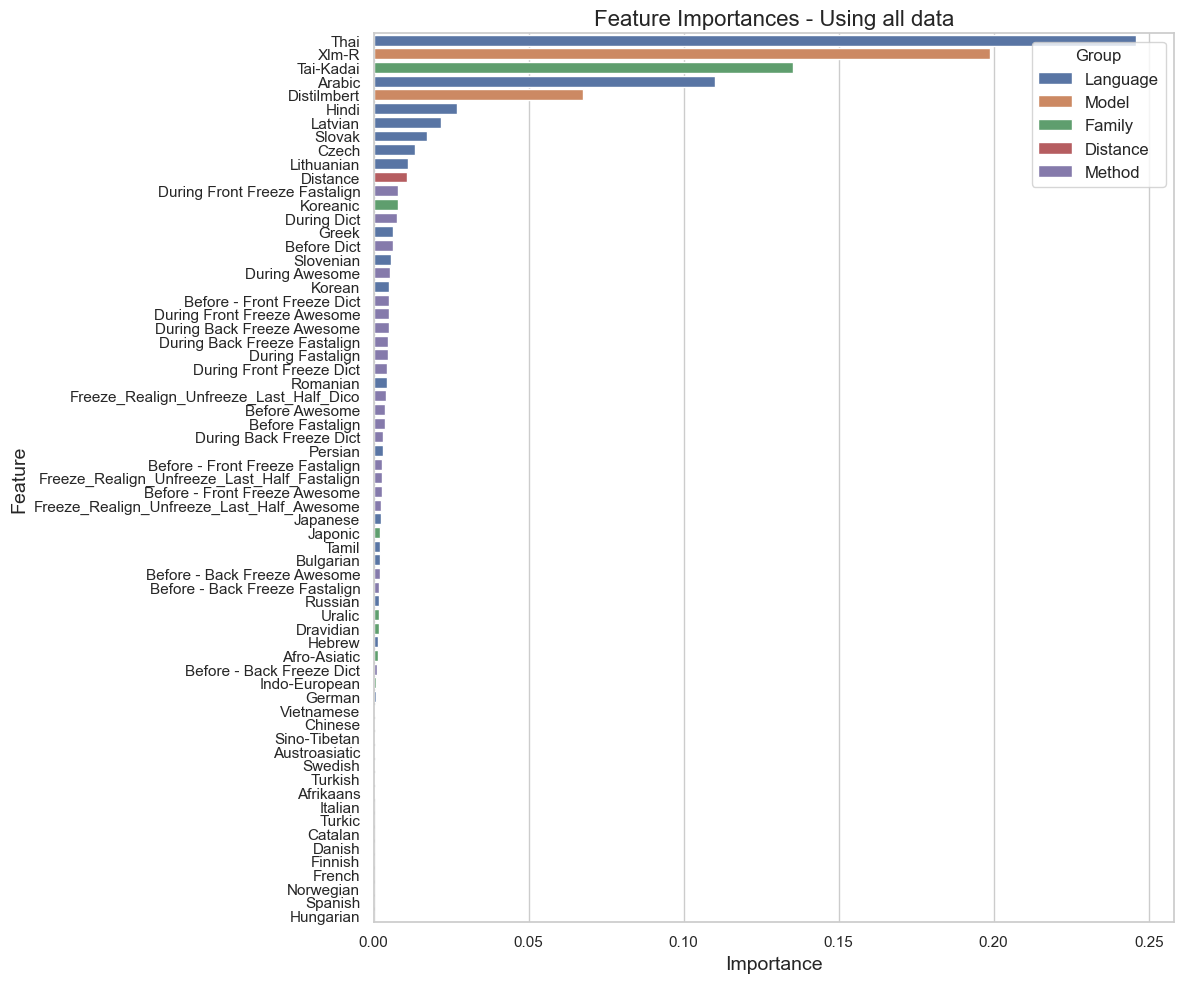

Using freeze methods only



100%|██████████| 59/59 [00:00<00:00, 127.14it/s]



Final Test MSE for Using freeze methods only (Random Forest): 0.000209482670709836


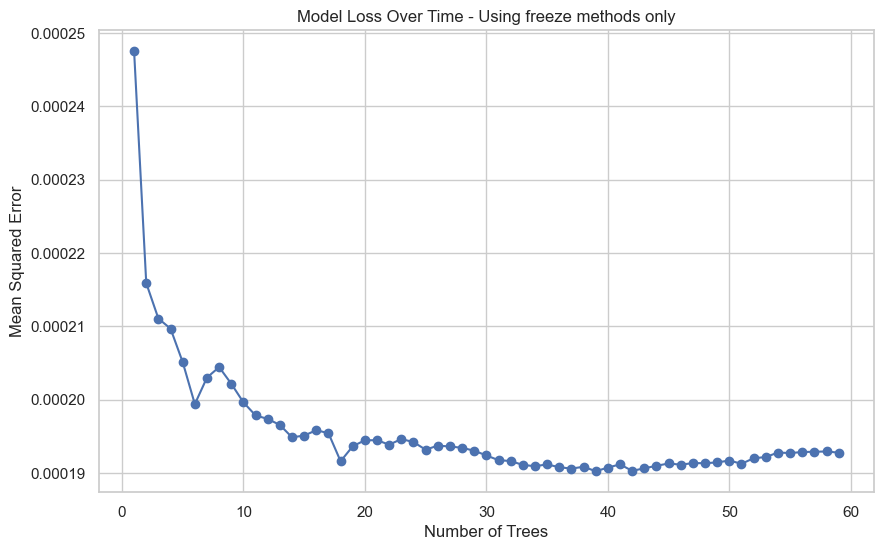

Calculating SHAP values: 100%|██████████| 2603/2603 [00:13<00:00, 187.05it/s]


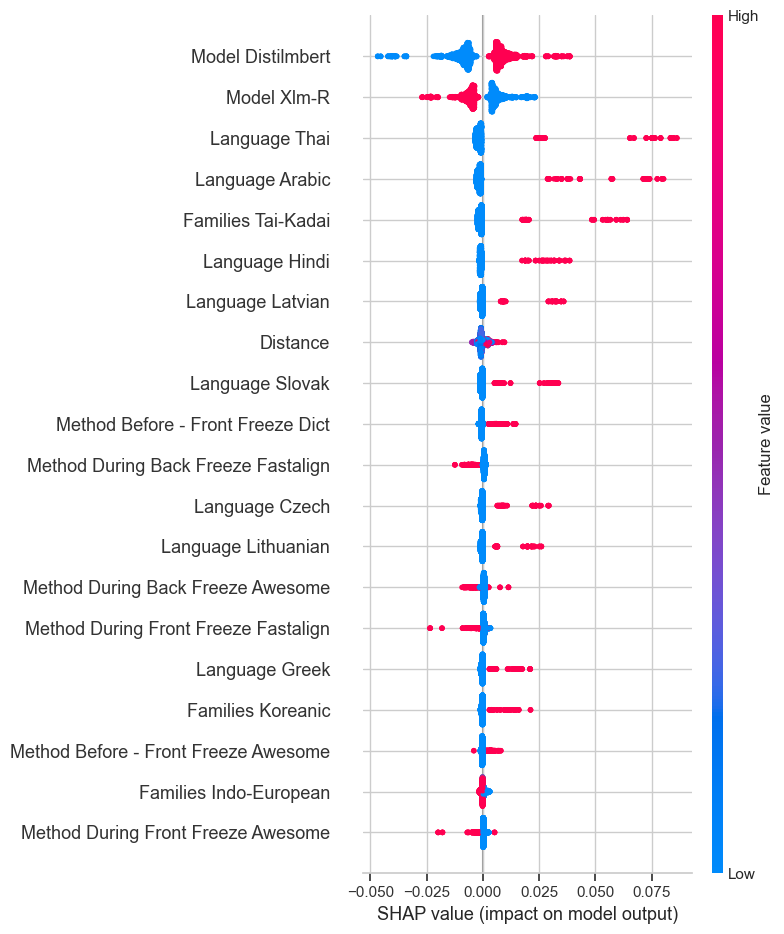

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


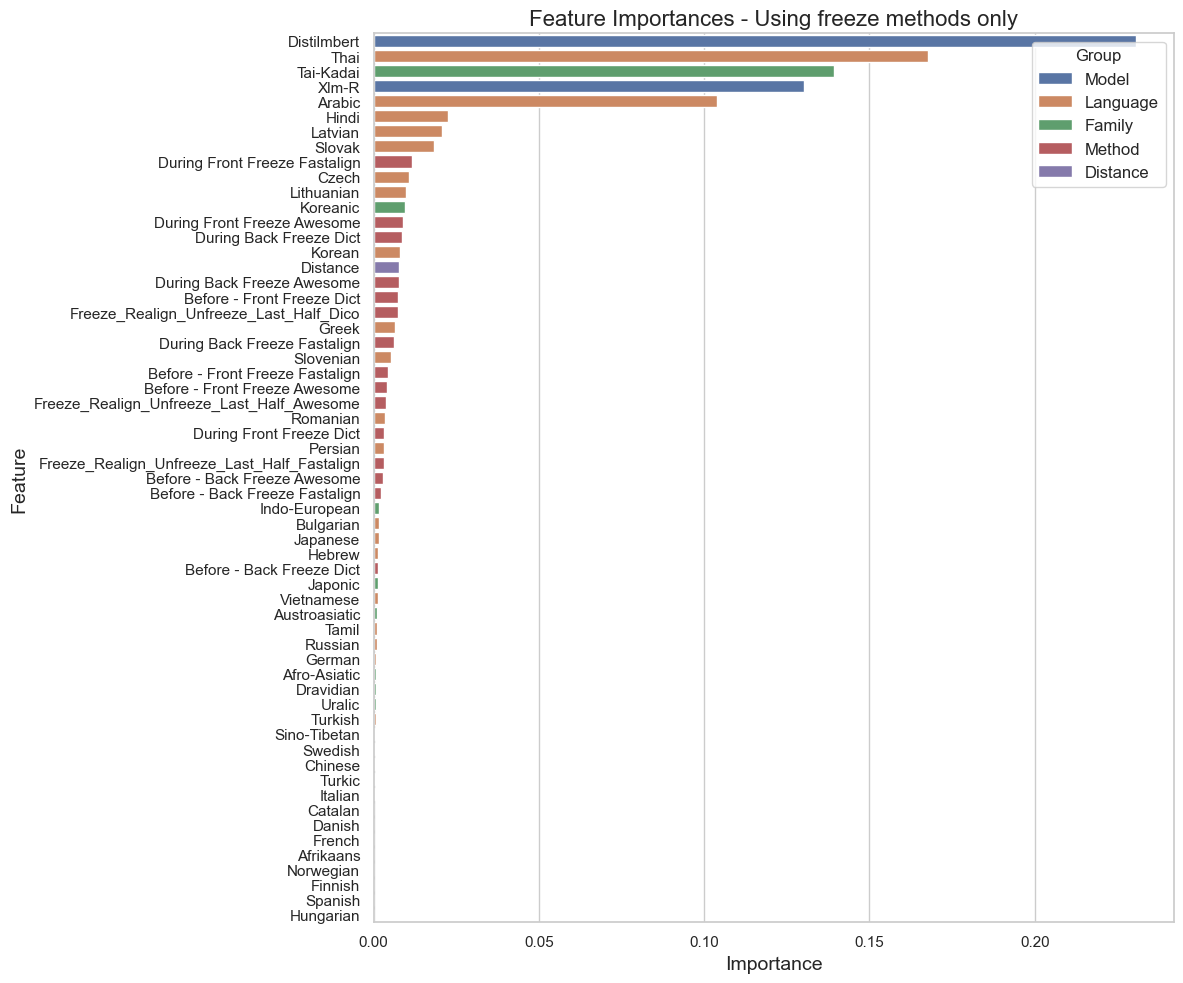

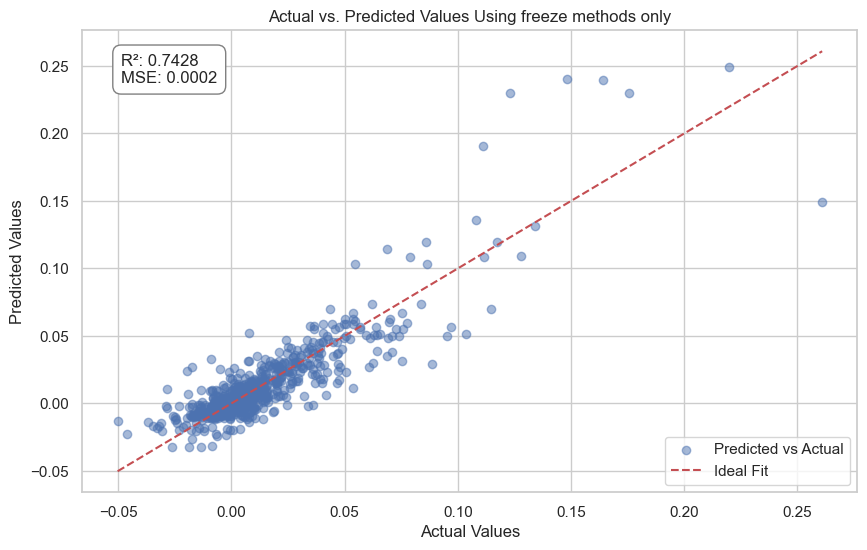

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


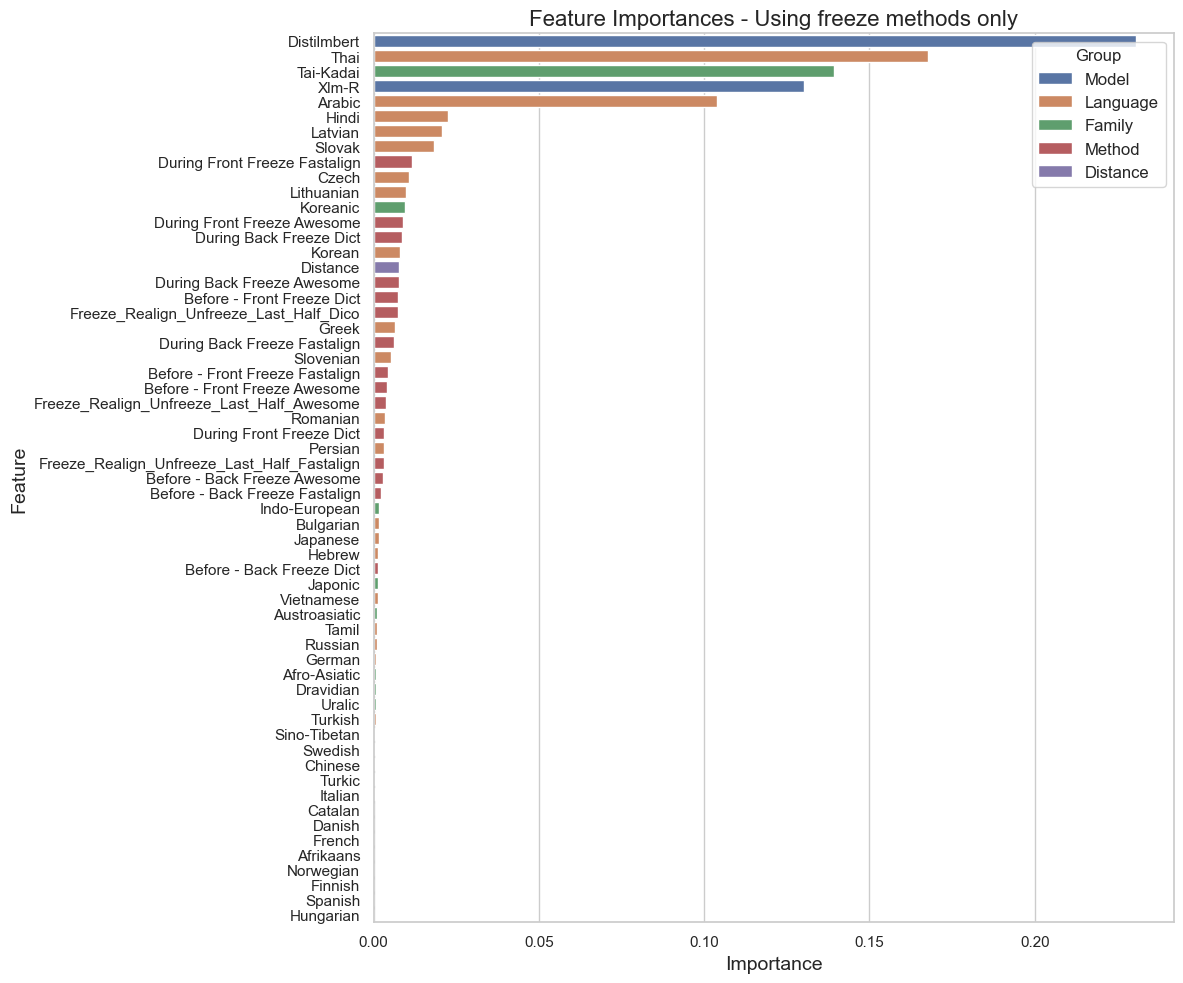

Using vanilla methods only



100%|██████████| 59/59 [00:00<00:00, 196.21it/s]


Final Test MSE for Using vanilla methods only (Random Forest): 0.0002610503650611364


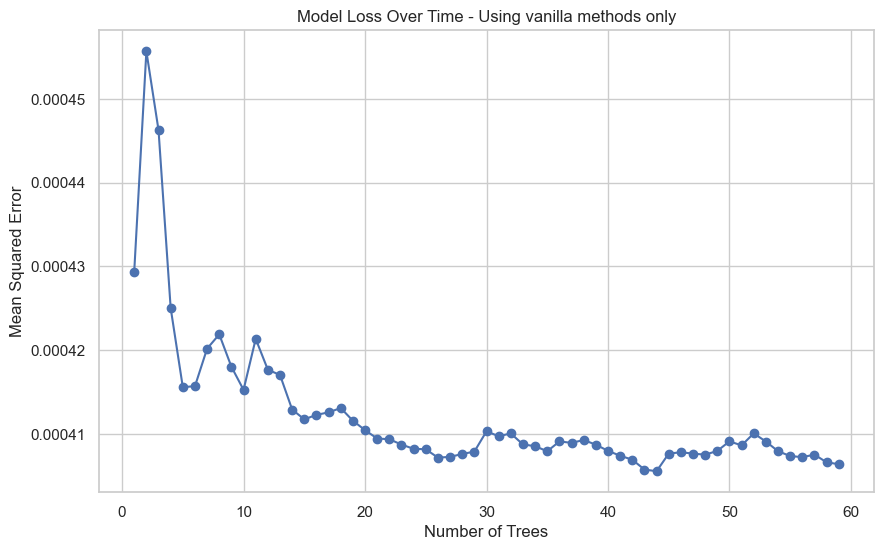

Calculating SHAP values: 100%|██████████| 1301/1301 [00:04<00:00, 306.62it/s]


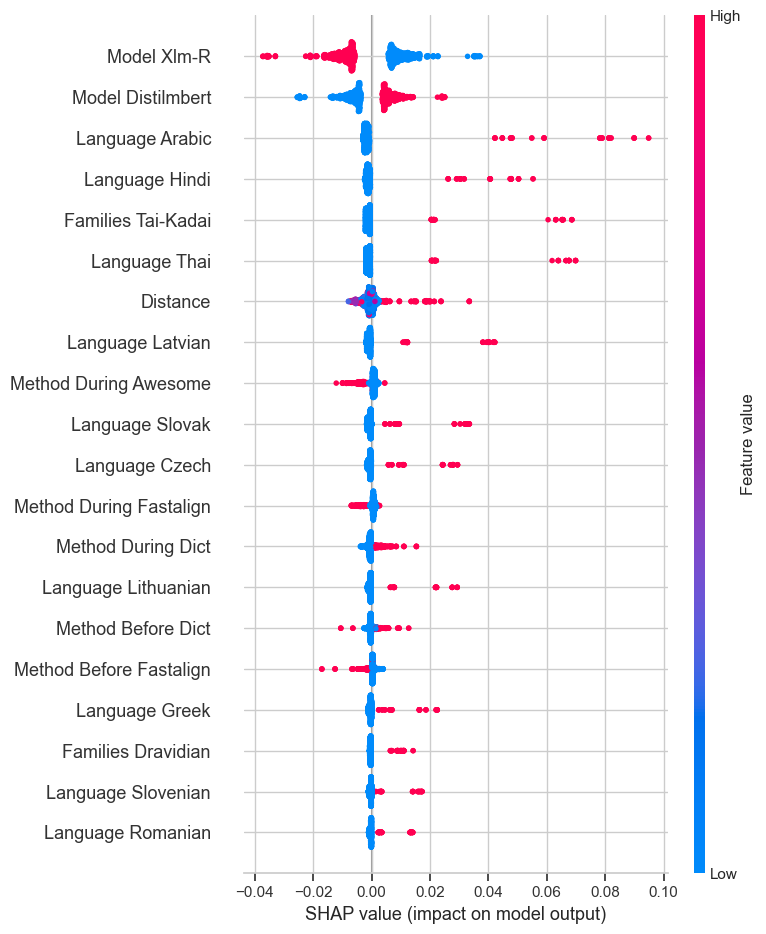

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


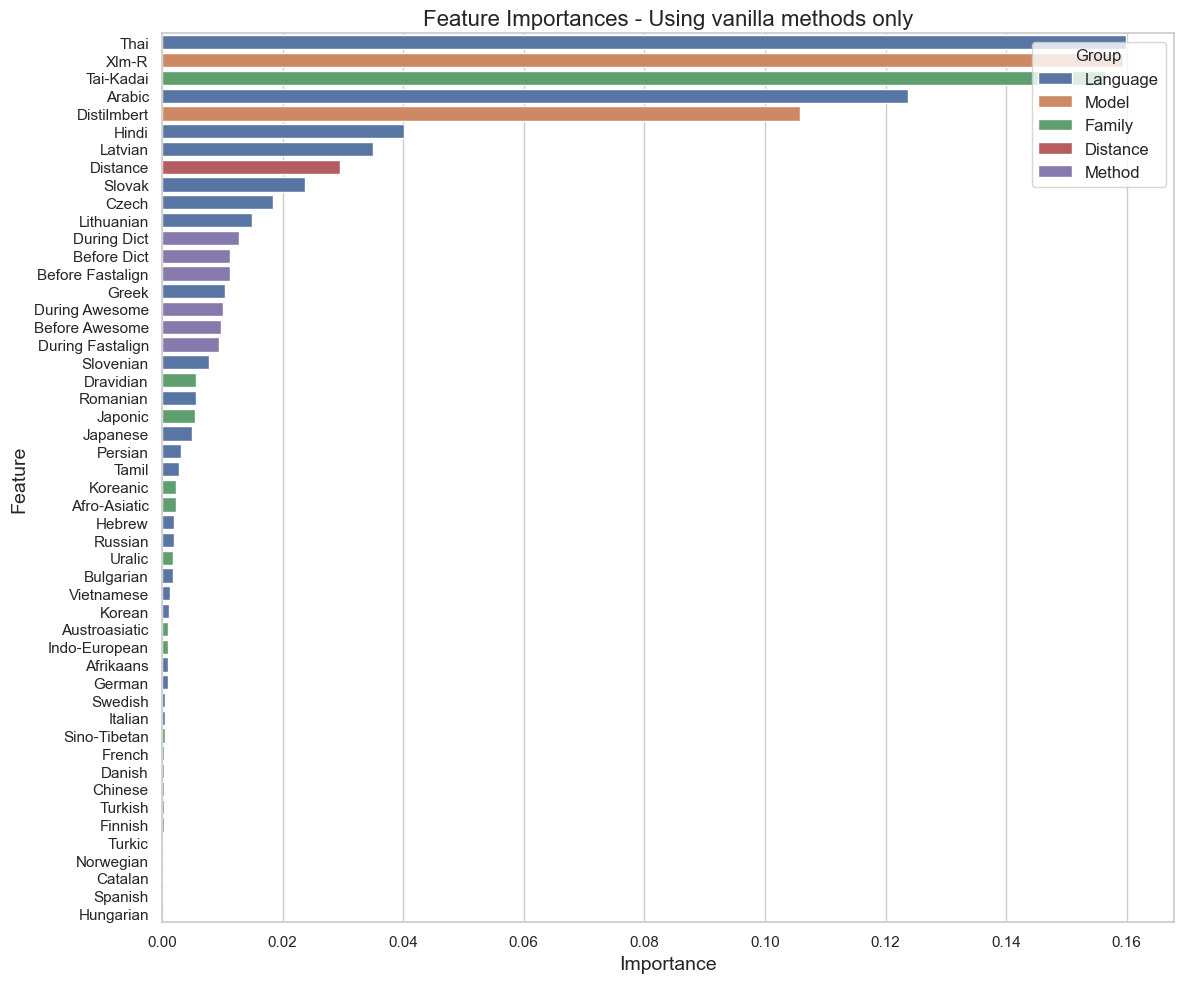

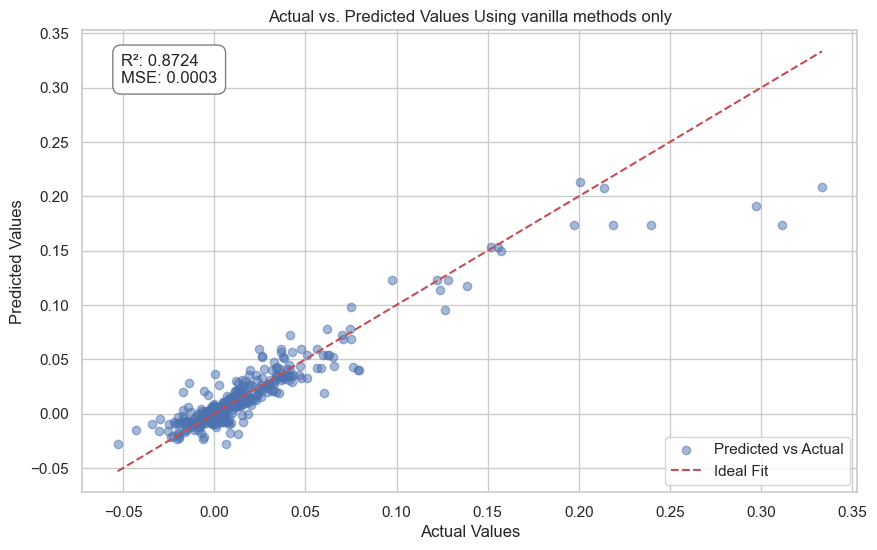

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


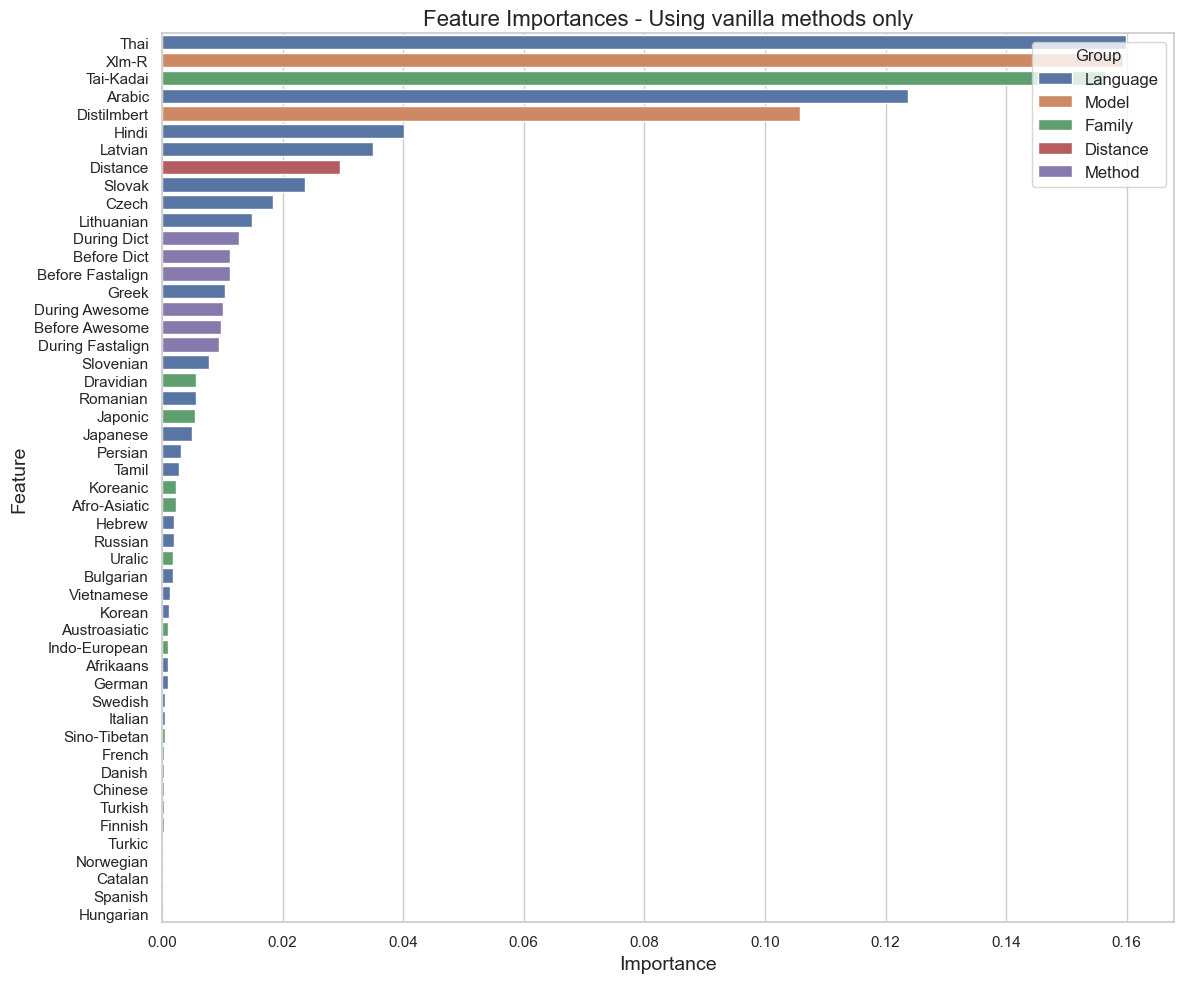

Using XLM-R only



100%|██████████| 59/59 [00:00<00:00, 143.35it/s]


Final Test MSE for Using XLM-R only (Random Forest): 0.0001258376466852725


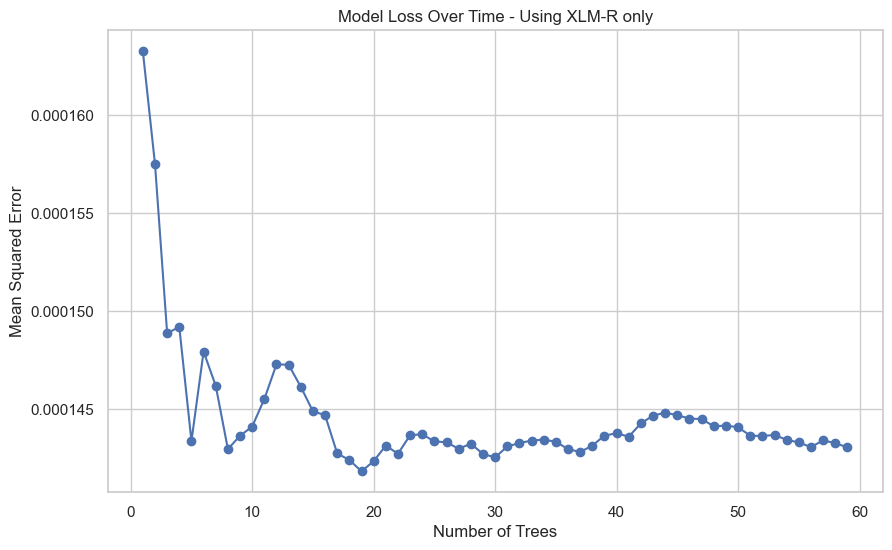

Calculating SHAP values: 100%|██████████| 1952/1952 [00:08<00:00, 226.92it/s]


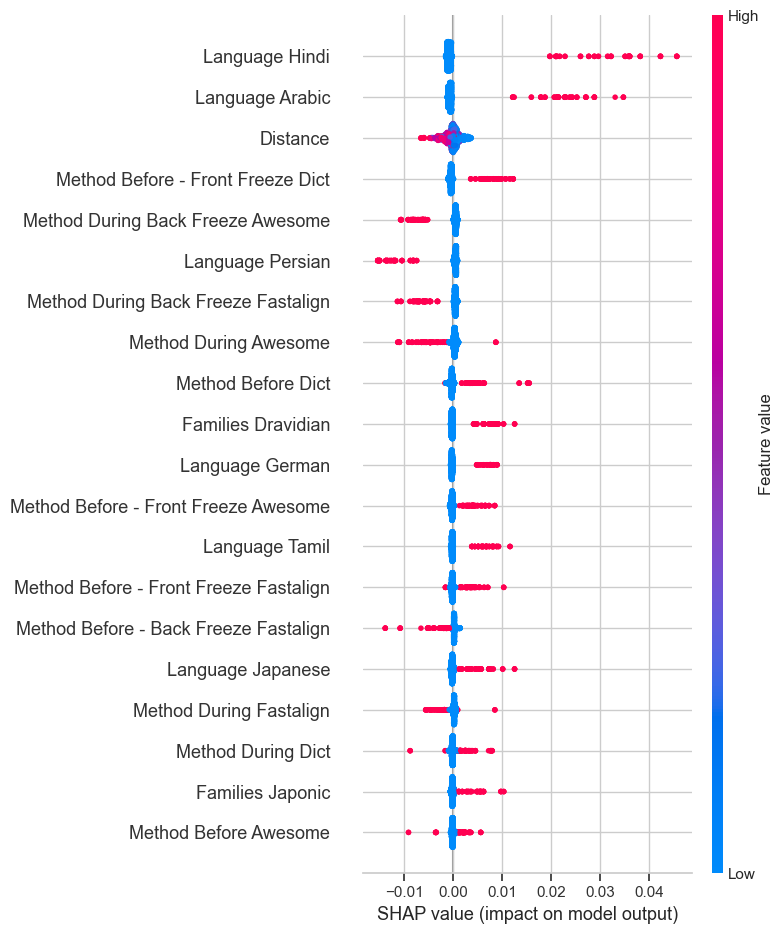

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


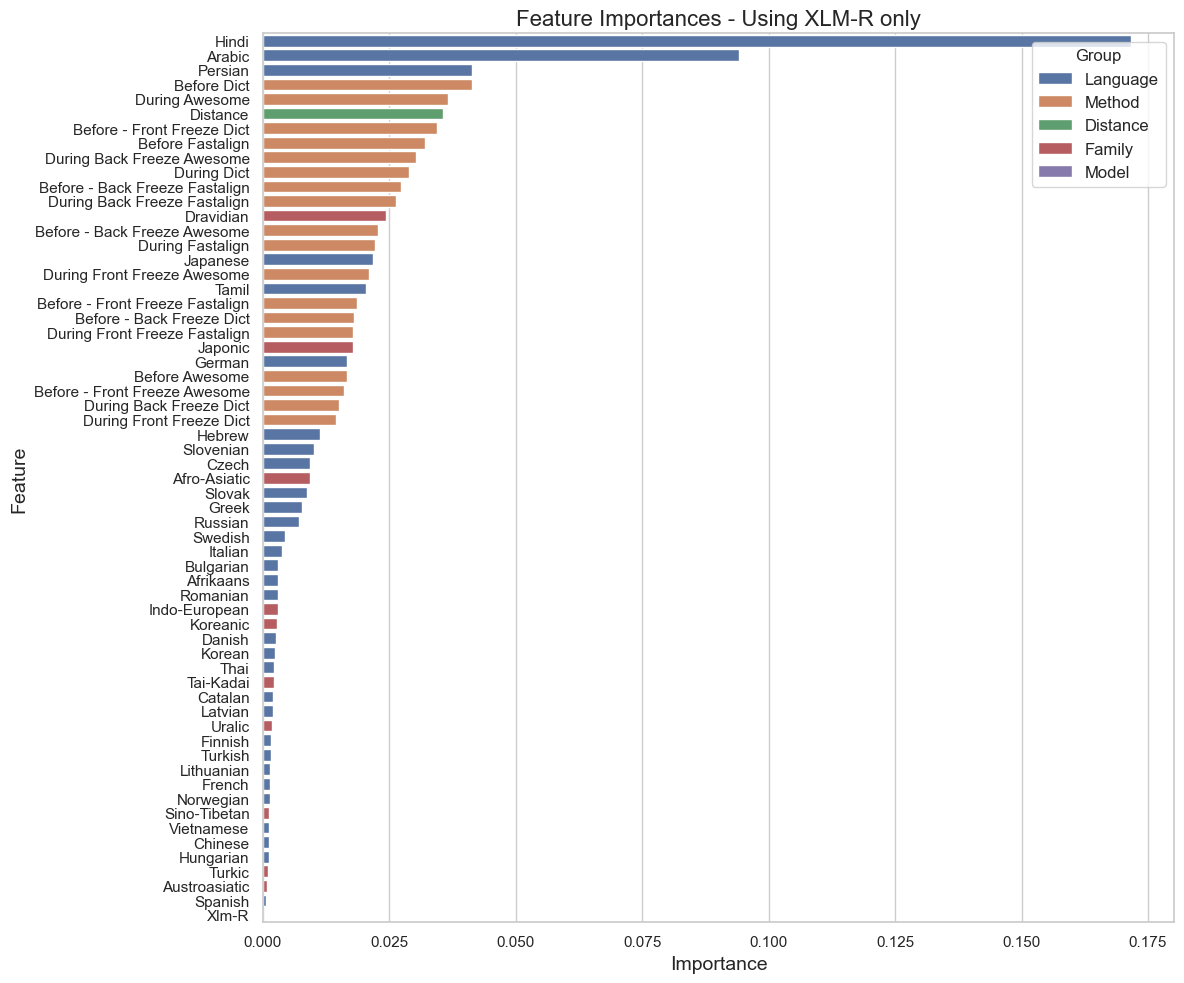

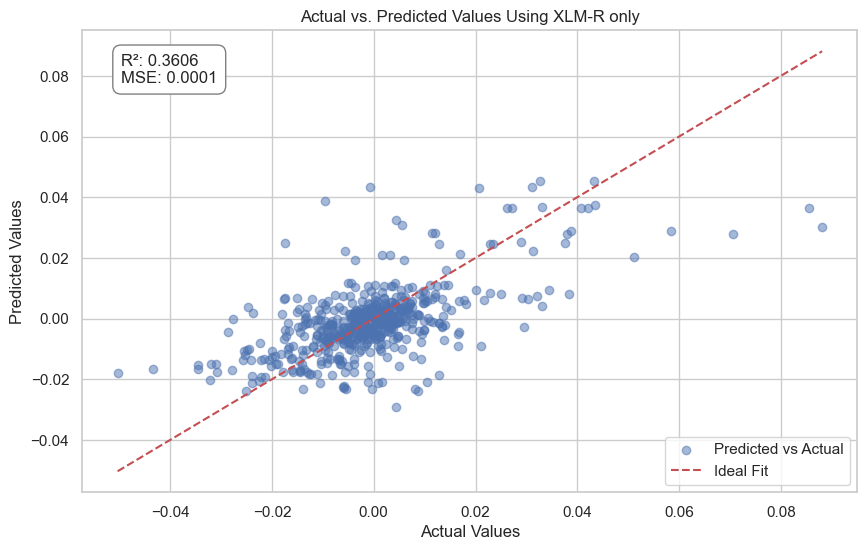

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


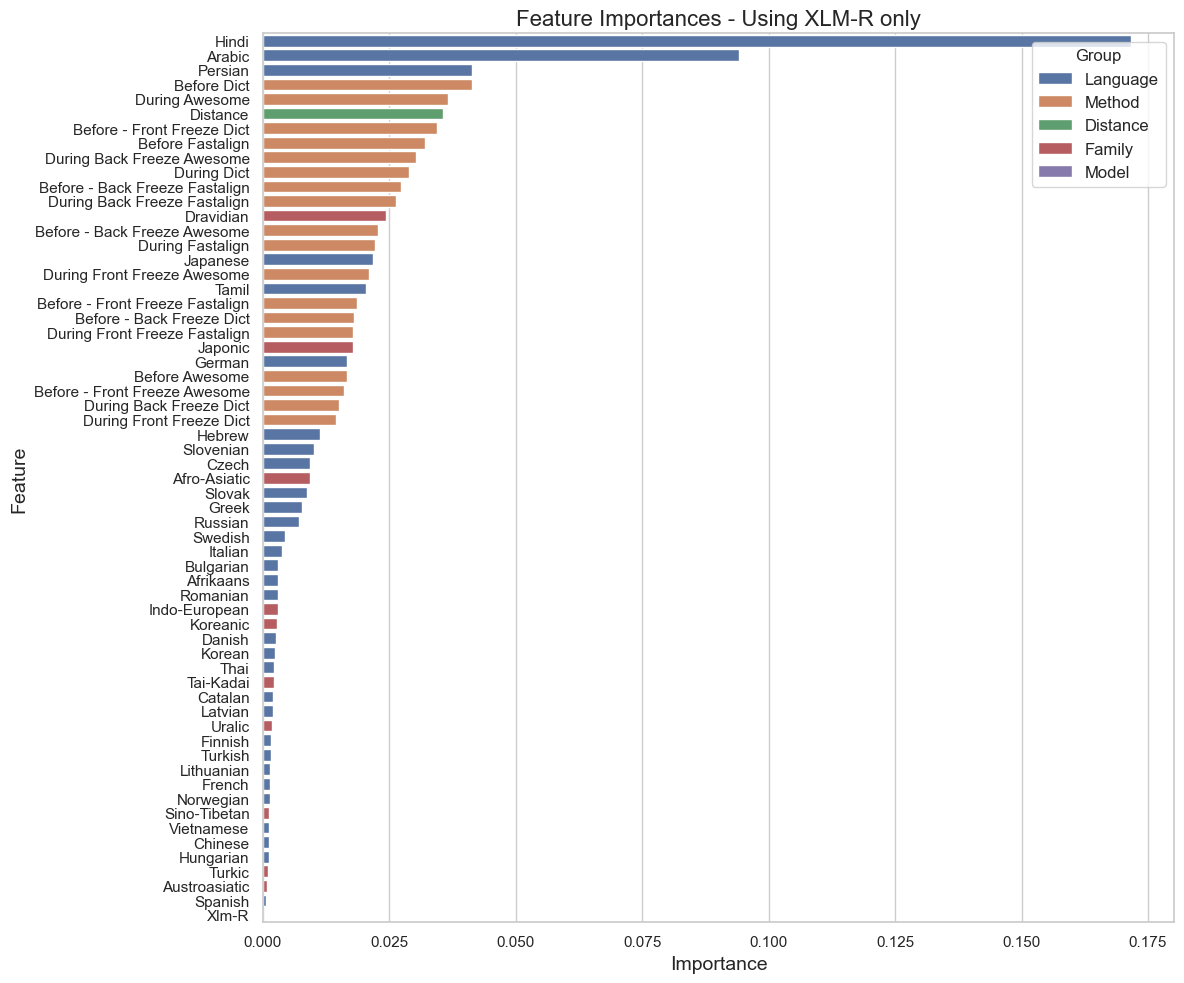

Using XLM-R freeze methods only



100%|██████████| 59/59 [00:00<00:00, 185.71it/s]



Final Test MSE for Using XLM-R freeze methods only (Random Forest): 0.00010460948508213985


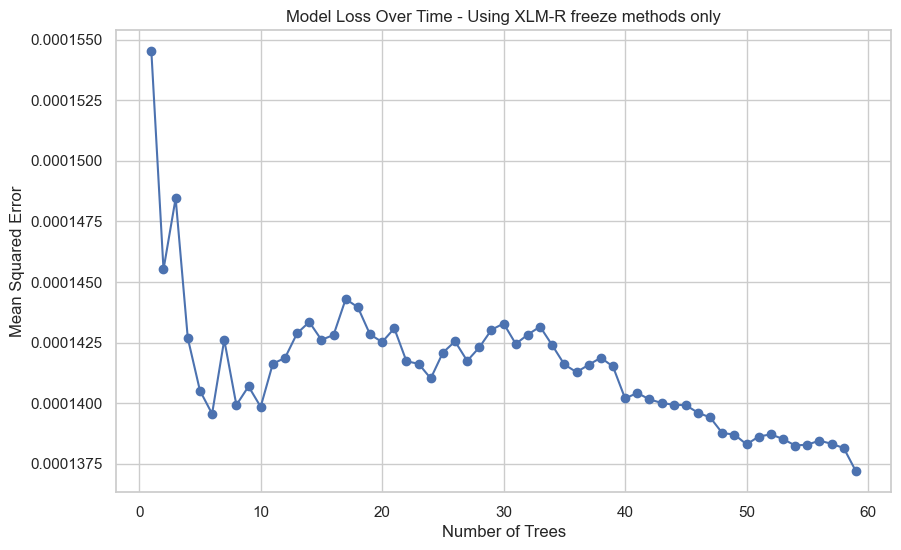

Calculating SHAP values: 100%|██████████| 1301/1301 [00:04<00:00, 304.88it/s]


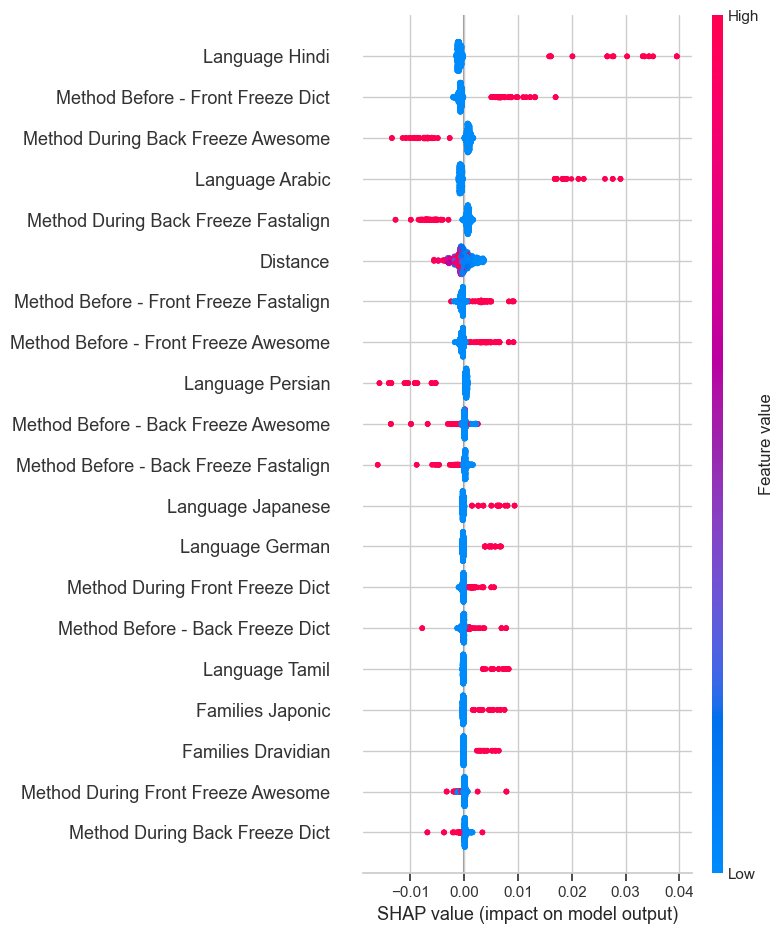

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


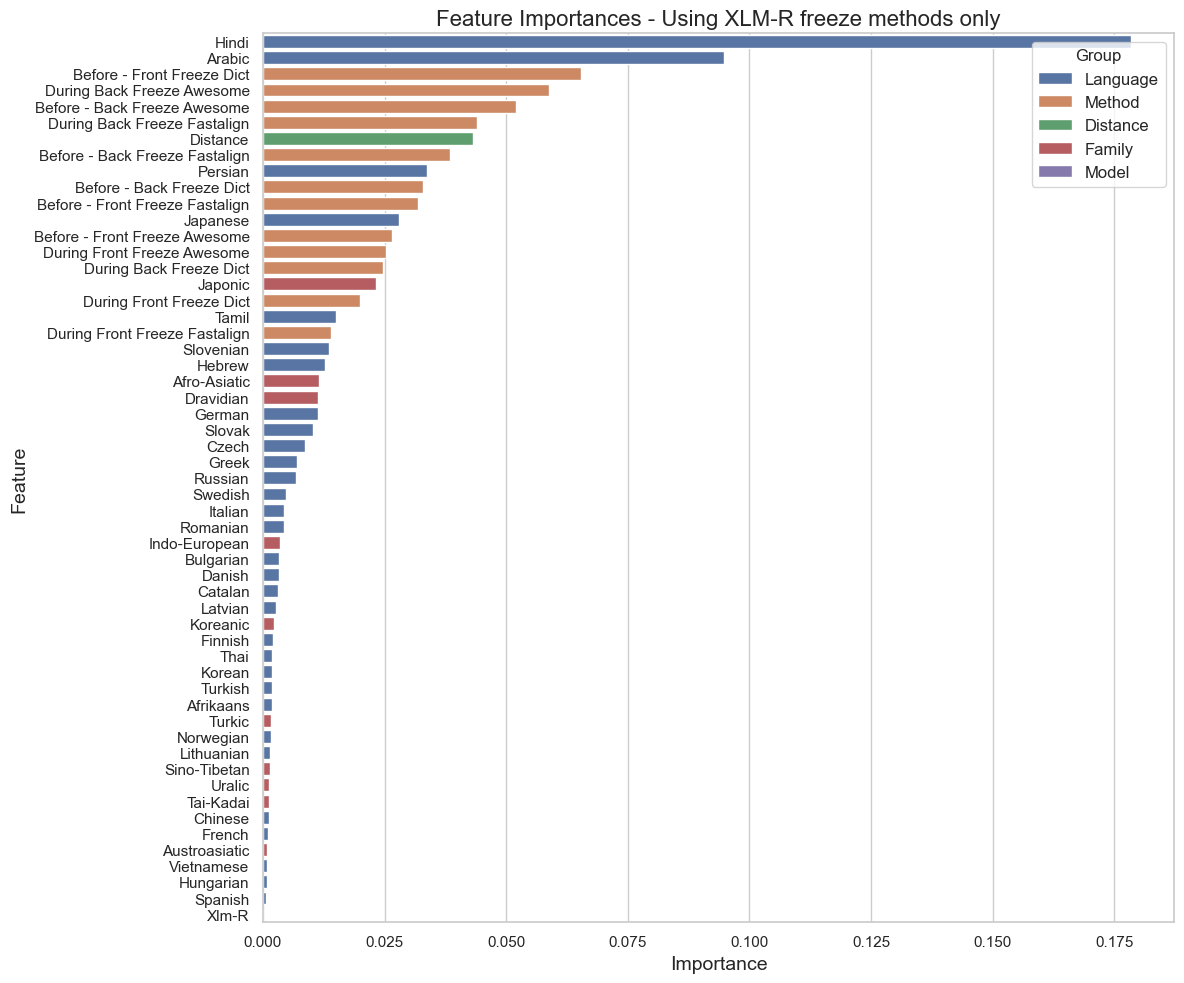

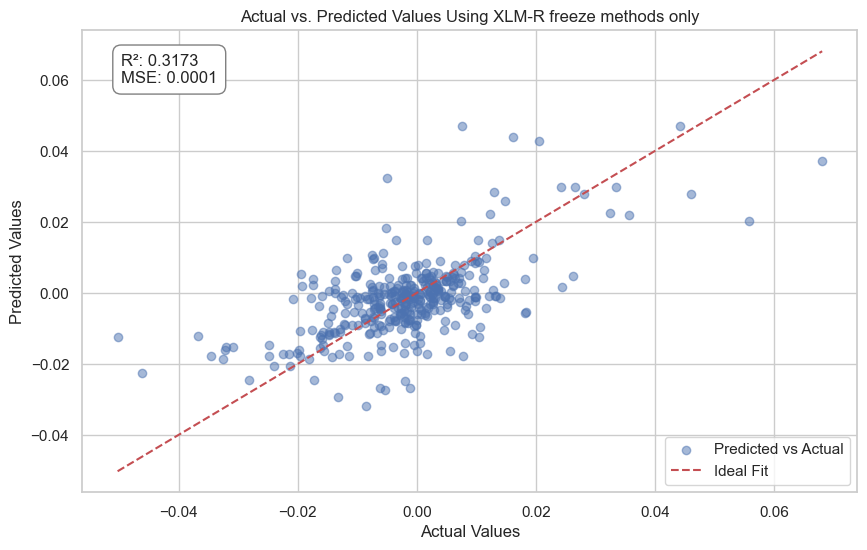

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


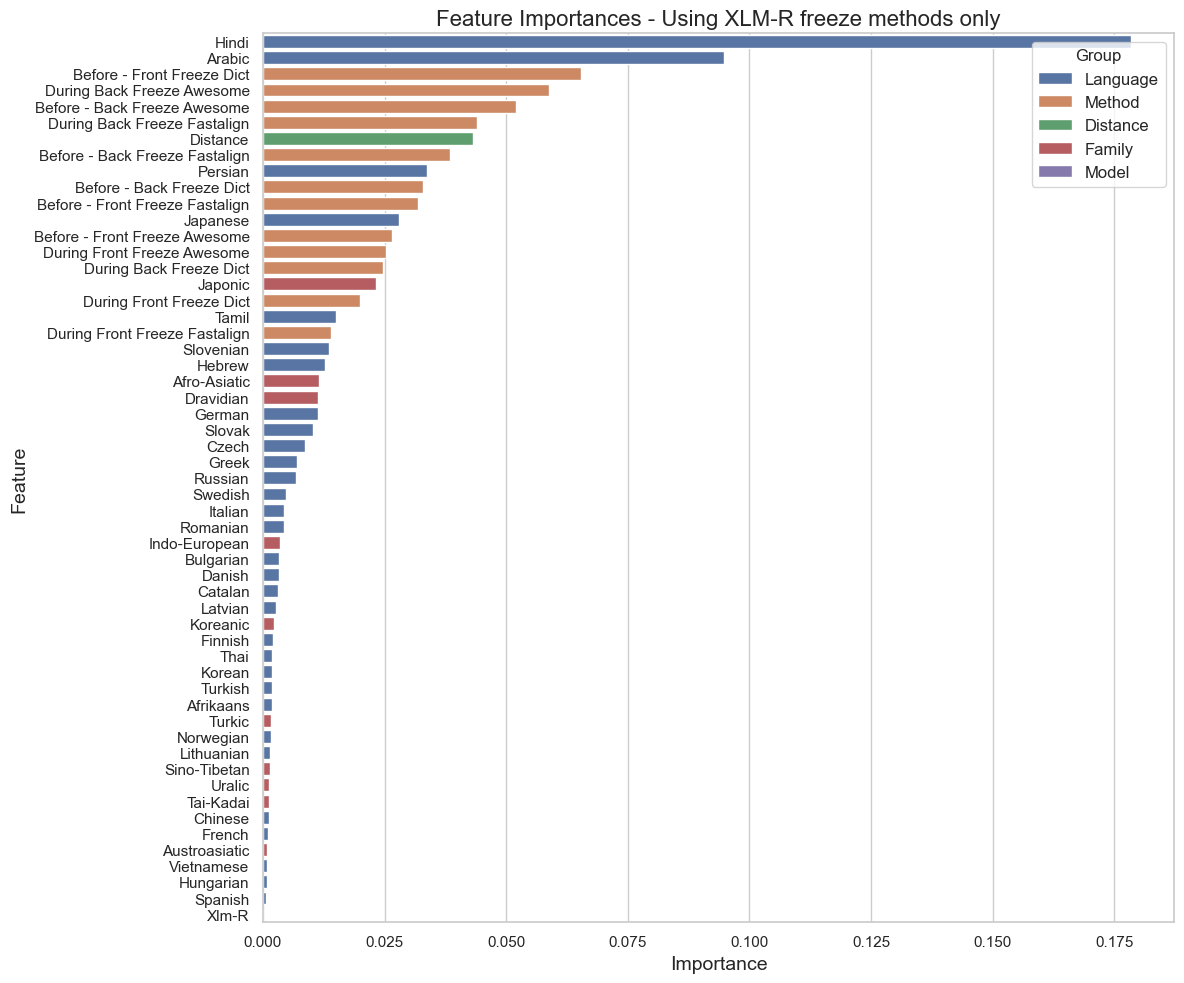

Using XLM-R vanilla methods only



100%|██████████| 59/59 [00:00<00:00, 307.77it/s]


Final Test MSE for Using XLM-R vanilla methods only (Random Forest): 0.00016055464042884026


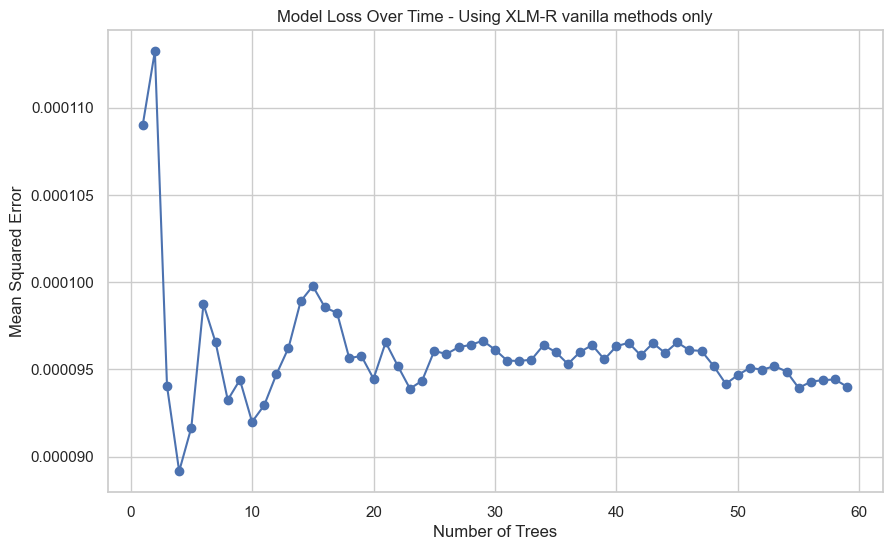

Calculating SHAP values: 100%|██████████| 650/650 [00:01<00:00, 485.91it/s]


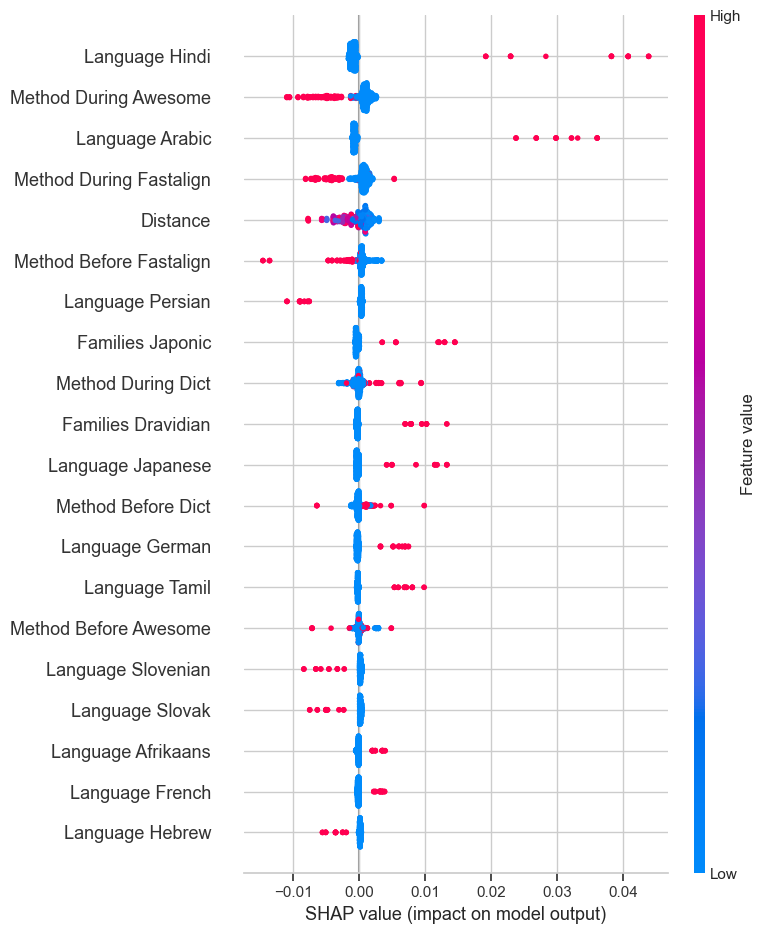

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


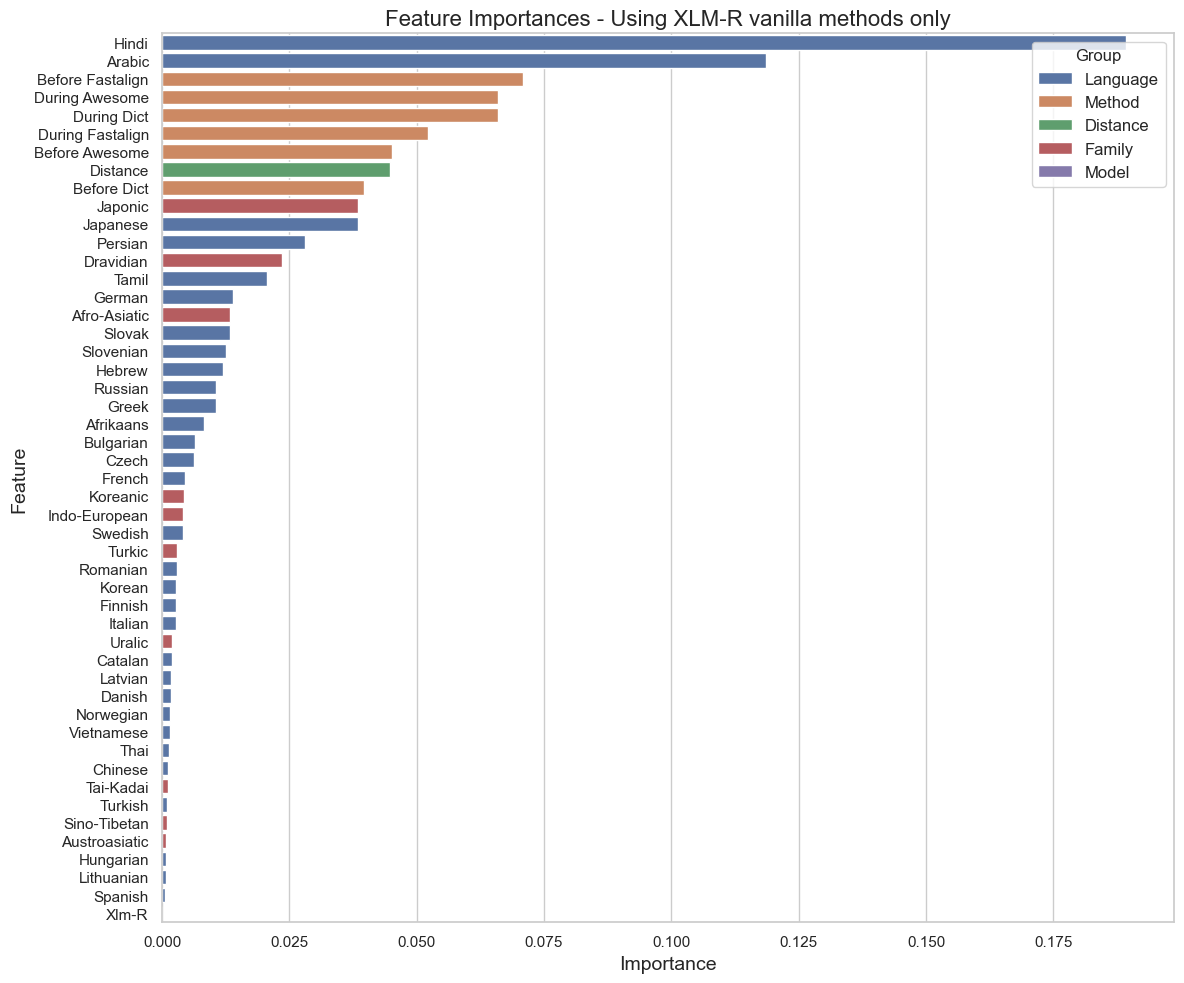

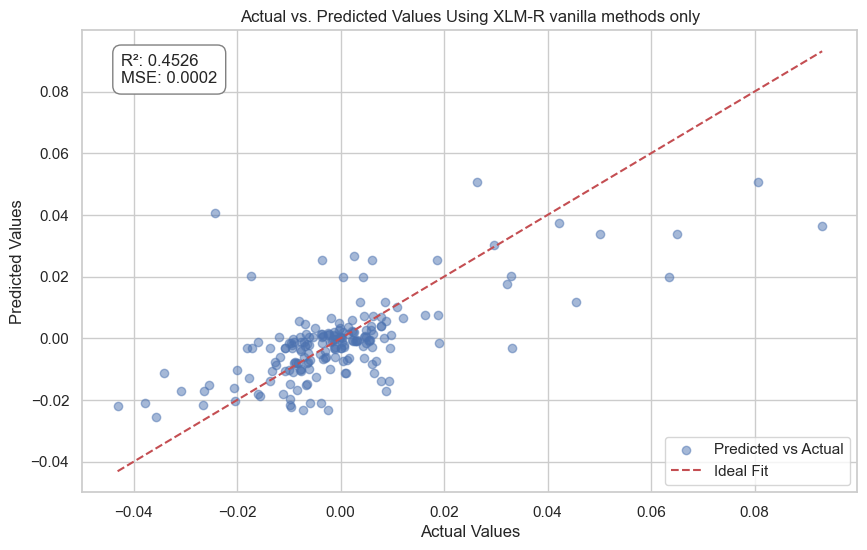

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


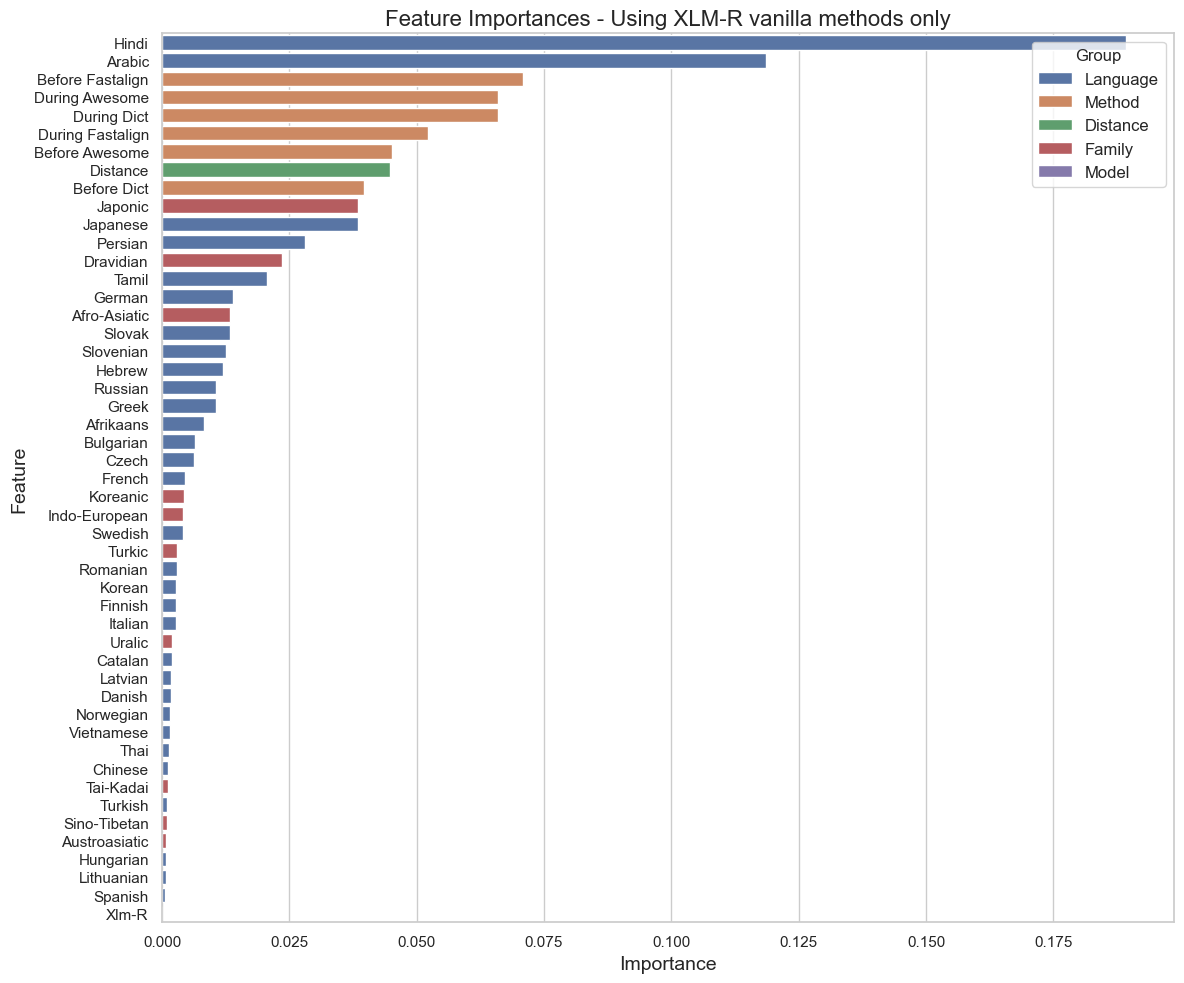

Using distilMBERT only



100%|██████████| 59/59 [00:00<00:00, 147.01it/s]


Final Test MSE for Using distilMBERT only (Random Forest): 0.0003635642450998399


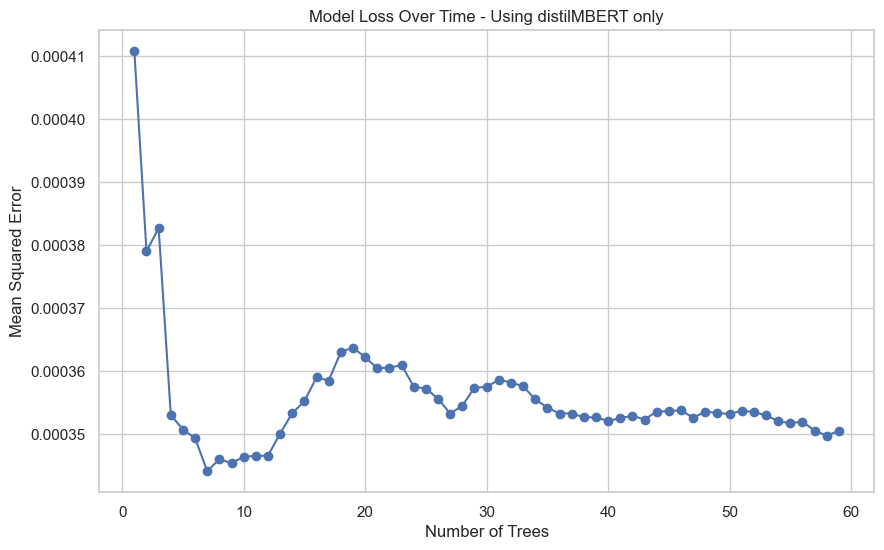

Calculating SHAP values: 100%|██████████| 1952/1952 [00:08<00:00, 222.88it/s]


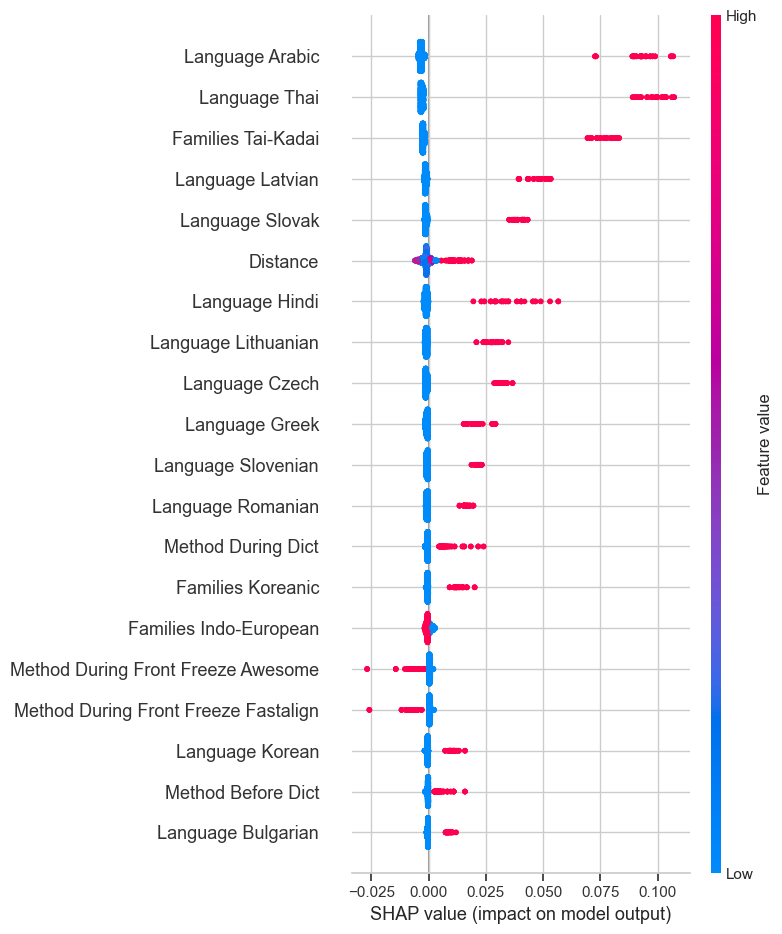

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


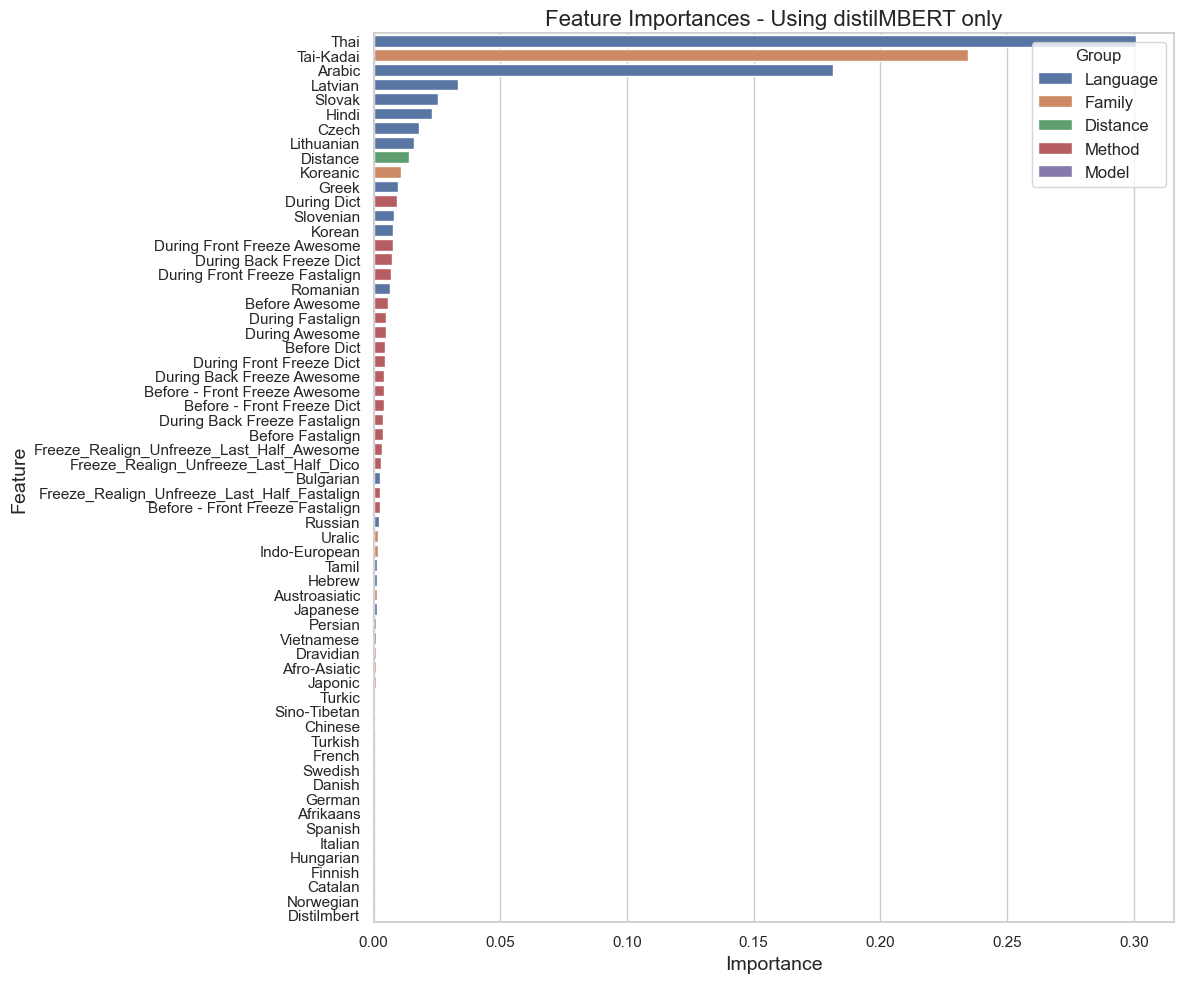

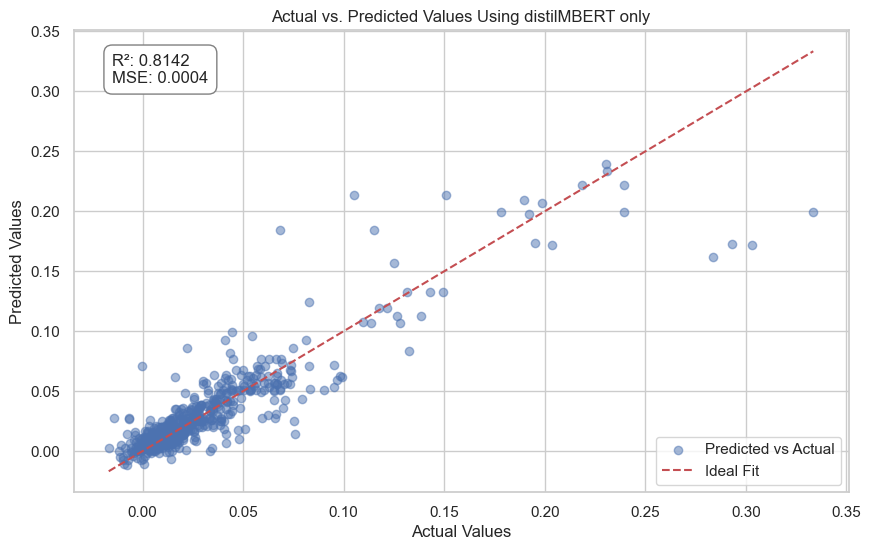

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


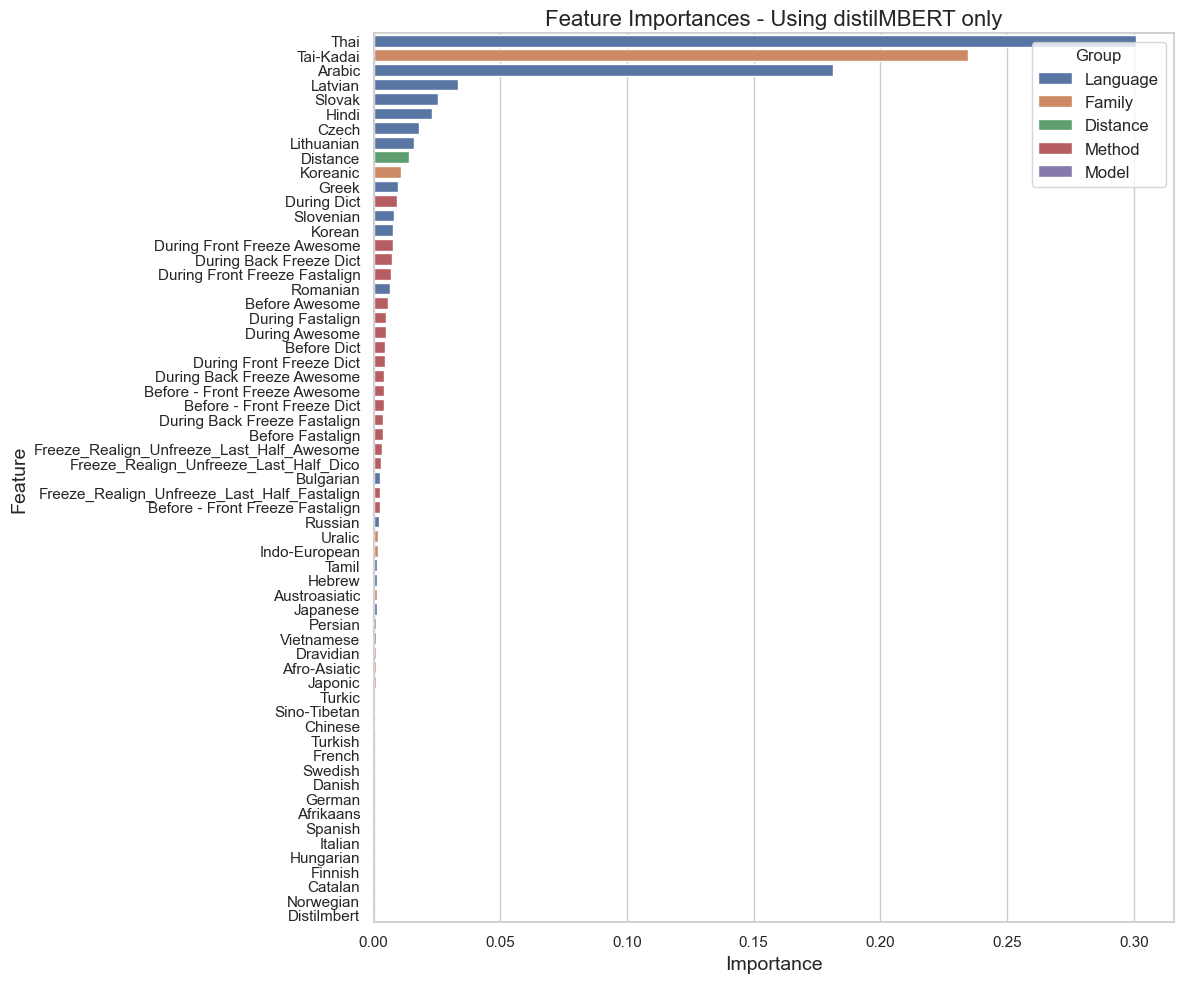

Using distilMBERT freeze methods only



100%|██████████| 59/59 [00:00<00:00, 207.25it/s]


Final Test MSE for Using distilMBERT freeze methods only (Random Forest): 0.00040111120713377053


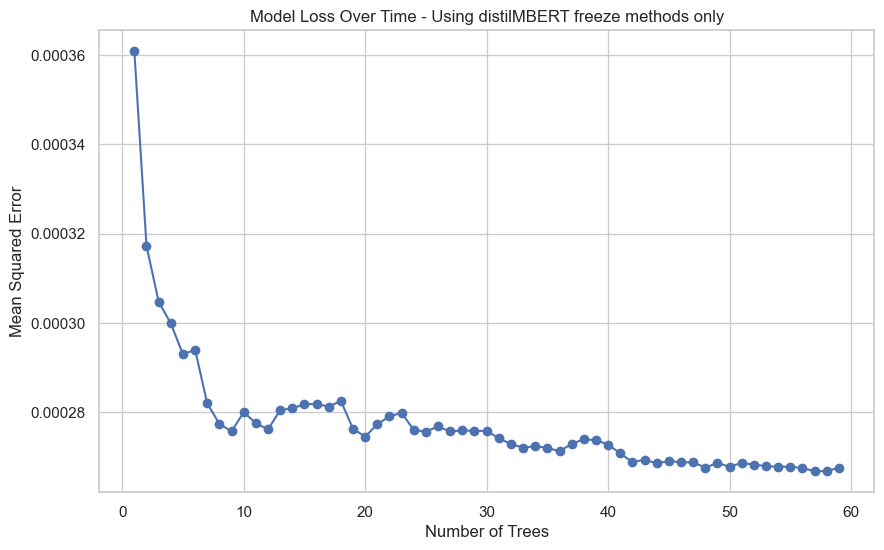

Calculating SHAP values: 100%|██████████| 1301/1301 [00:04<00:00, 304.46it/s]


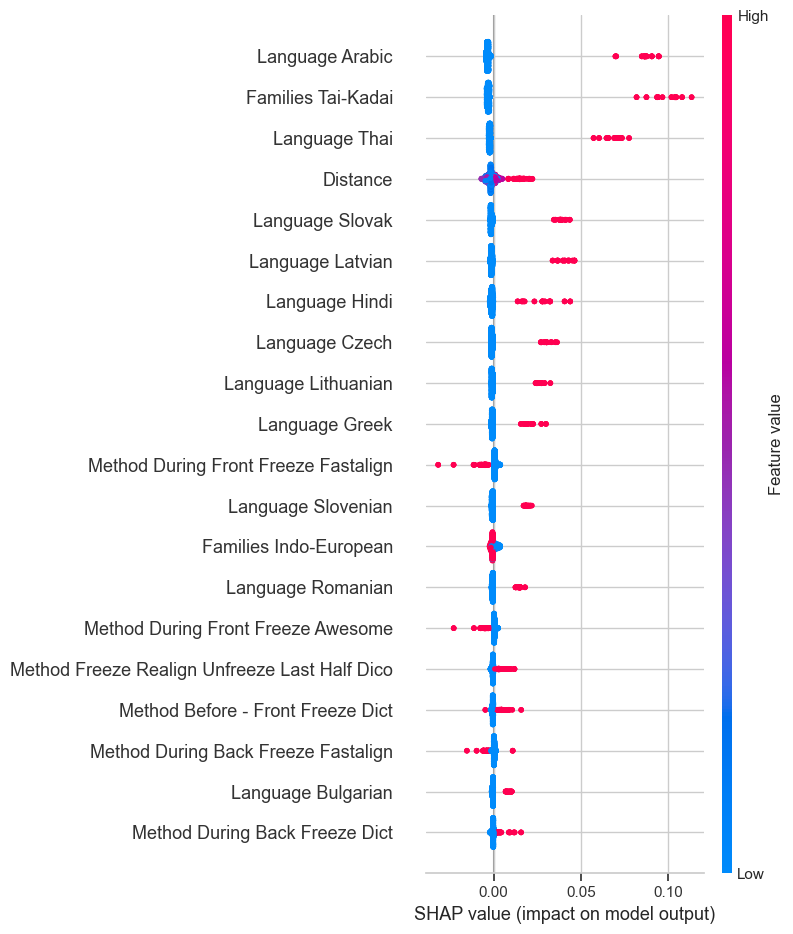

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


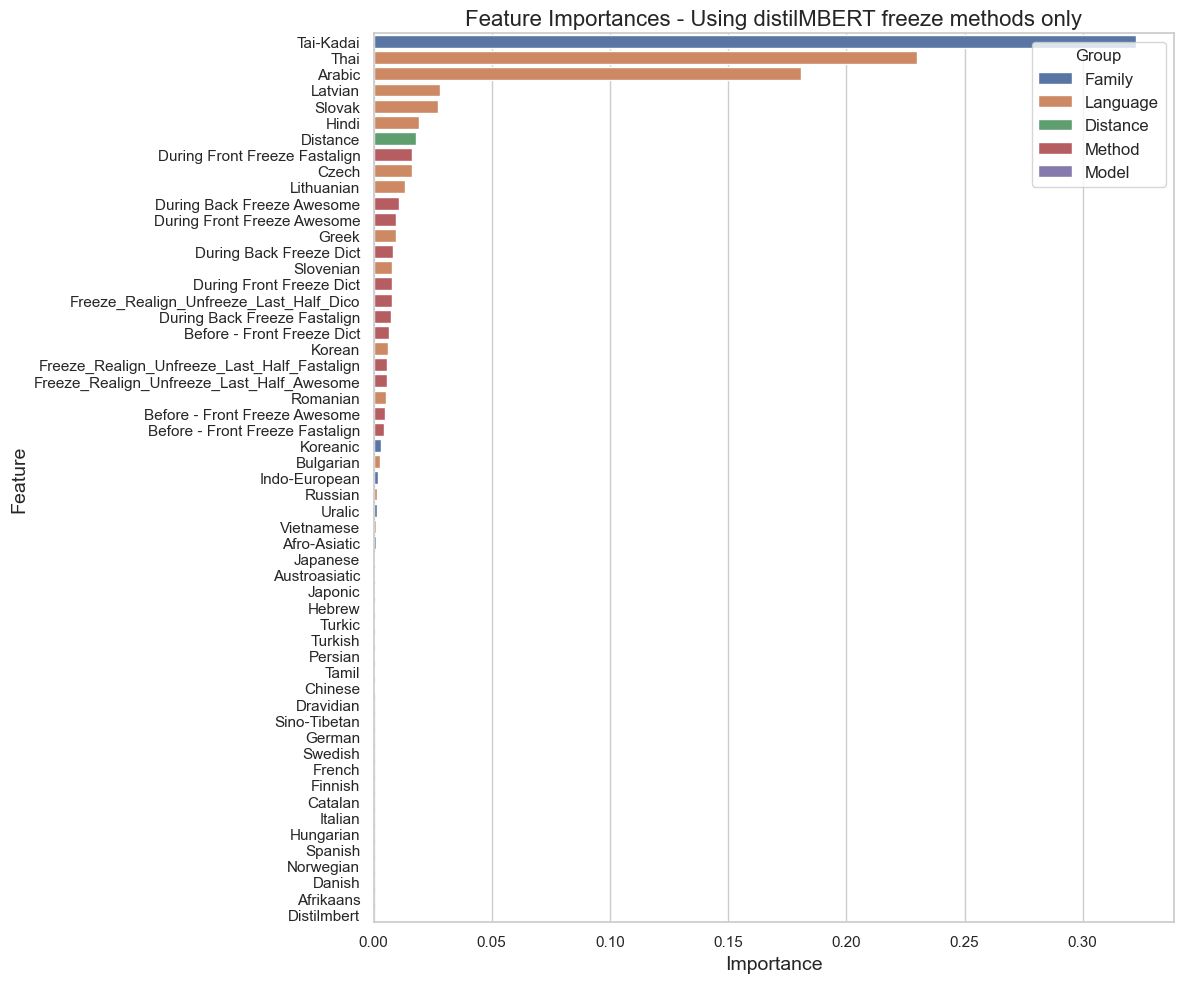

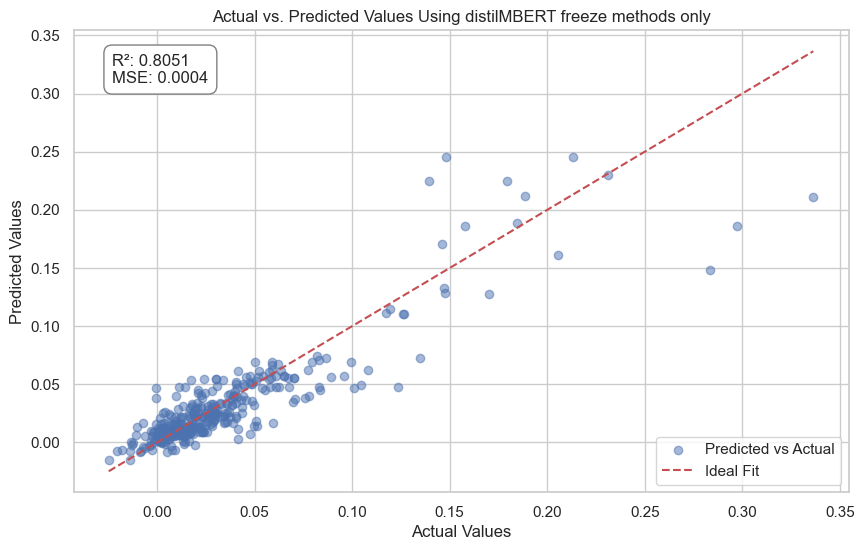

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


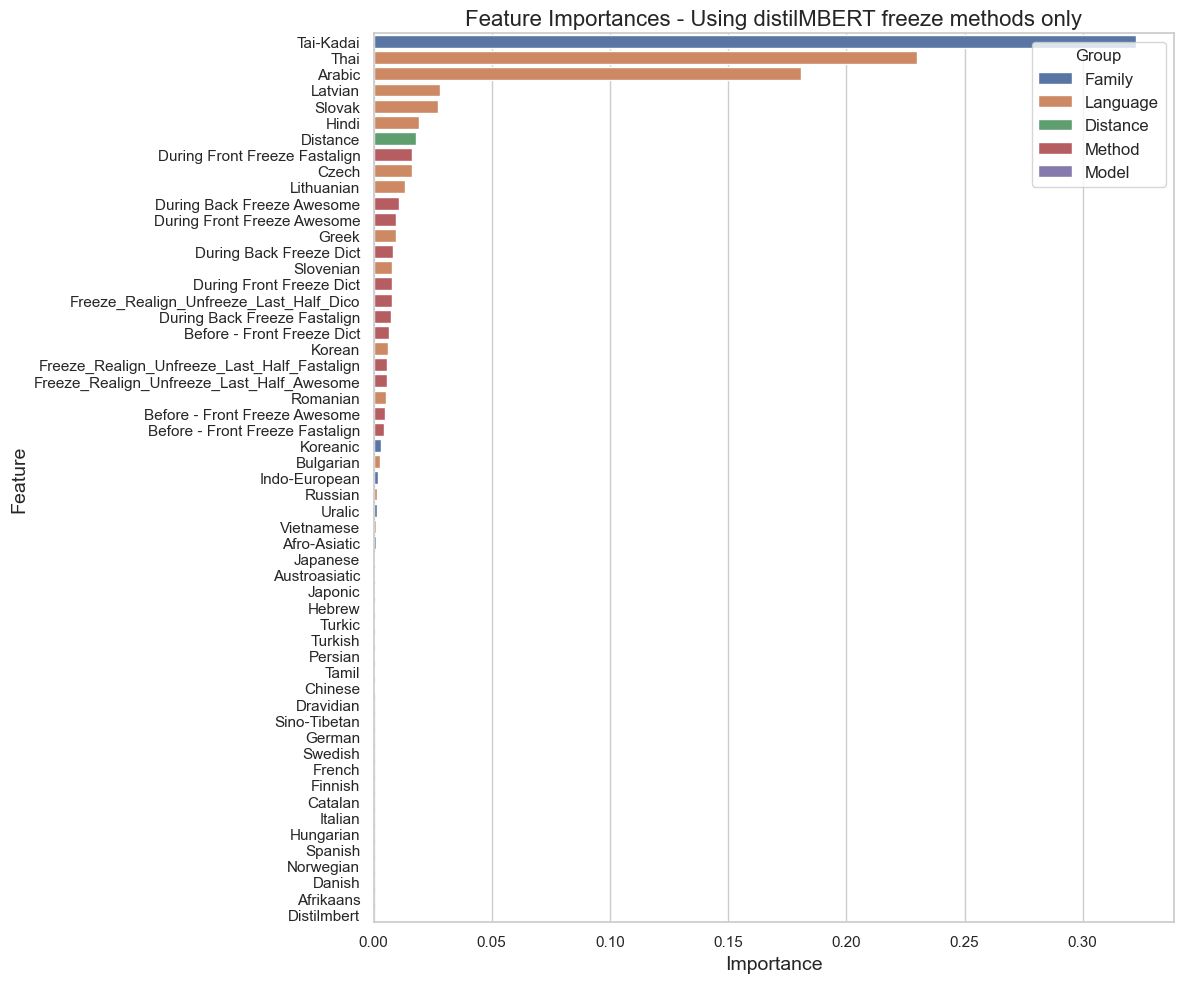

Using distilMBERT vanilla methods only



100%|██████████| 59/59 [00:00<00:00, 287.80it/s]


Final Test MSE for Using distilMBERT vanilla methods only (Random Forest): 0.0003041592415965496


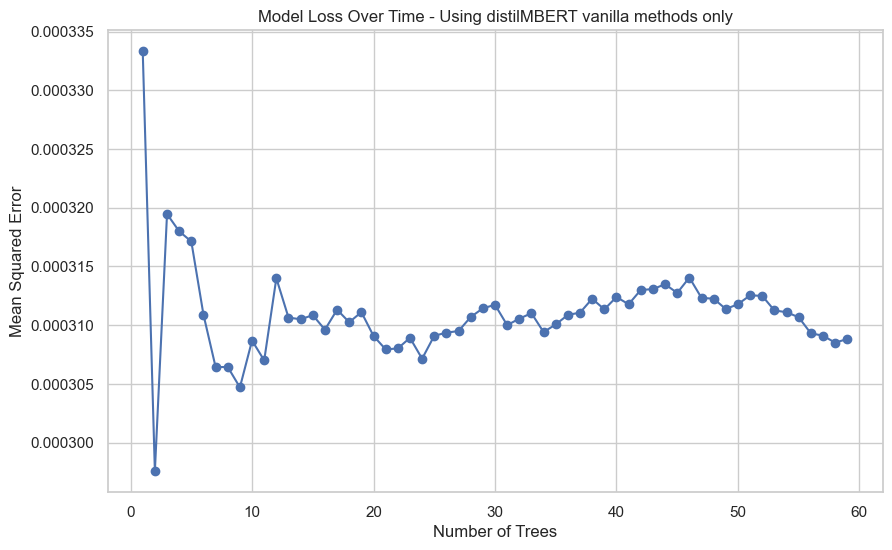

Calculating SHAP values: 100%|██████████| 650/650 [00:01<00:00, 470.08it/s]


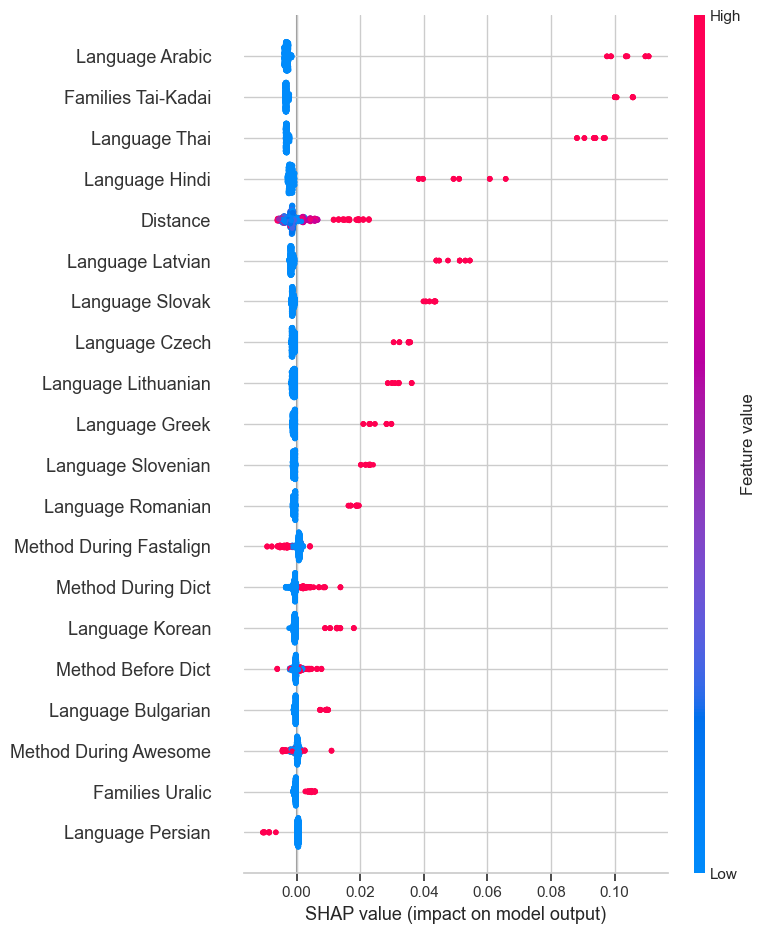

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


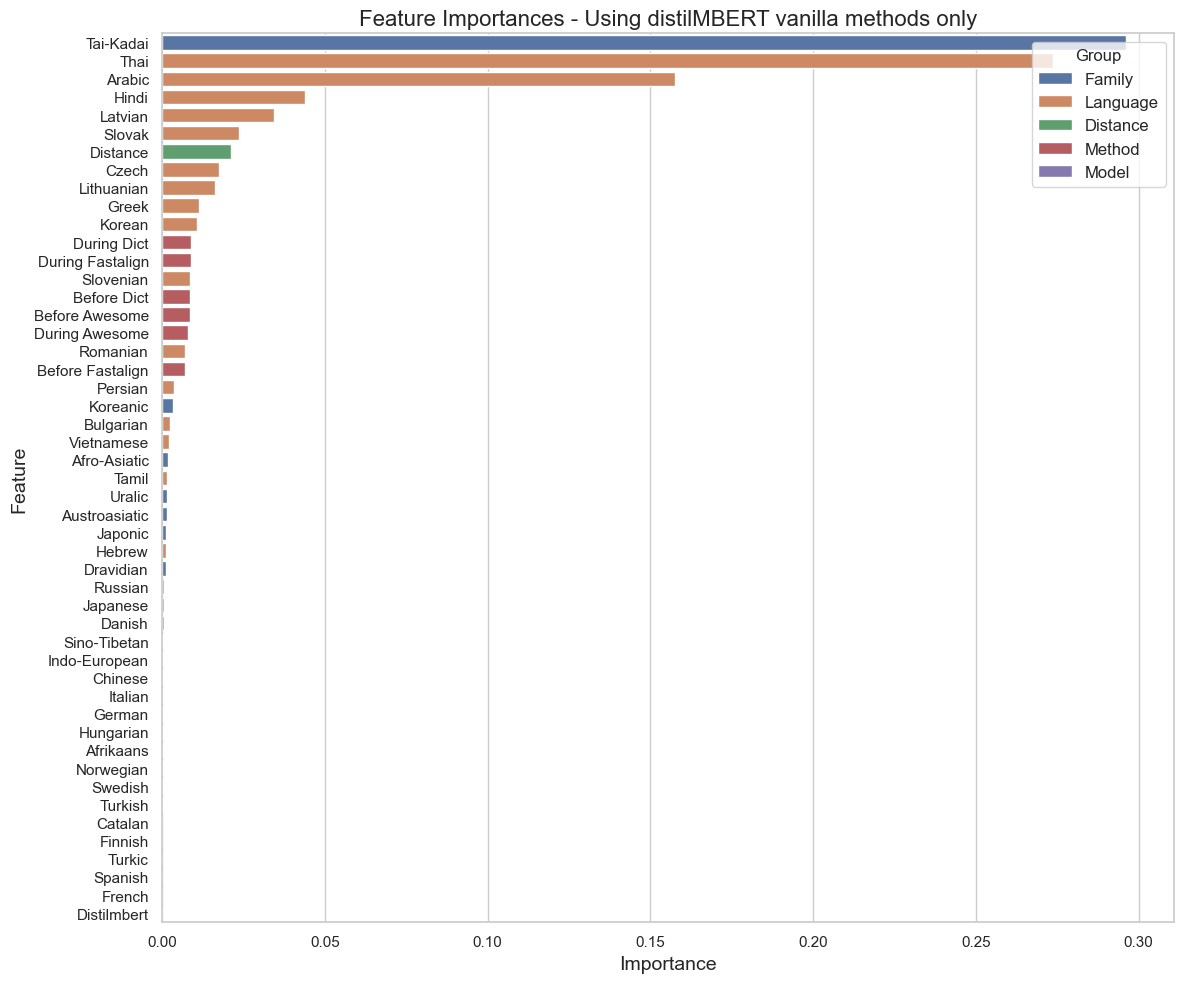

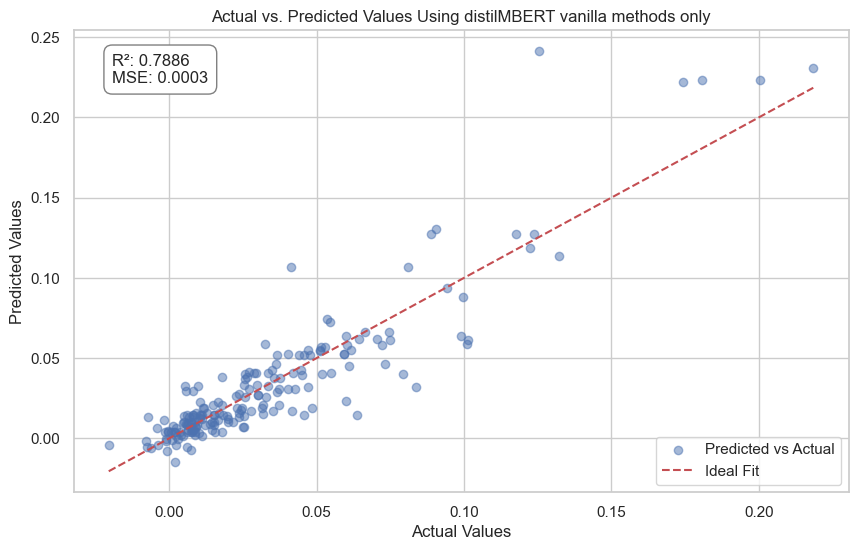

C:\Users\alith\AppData\Local\Temp\ipykernel_97092\1107467708.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


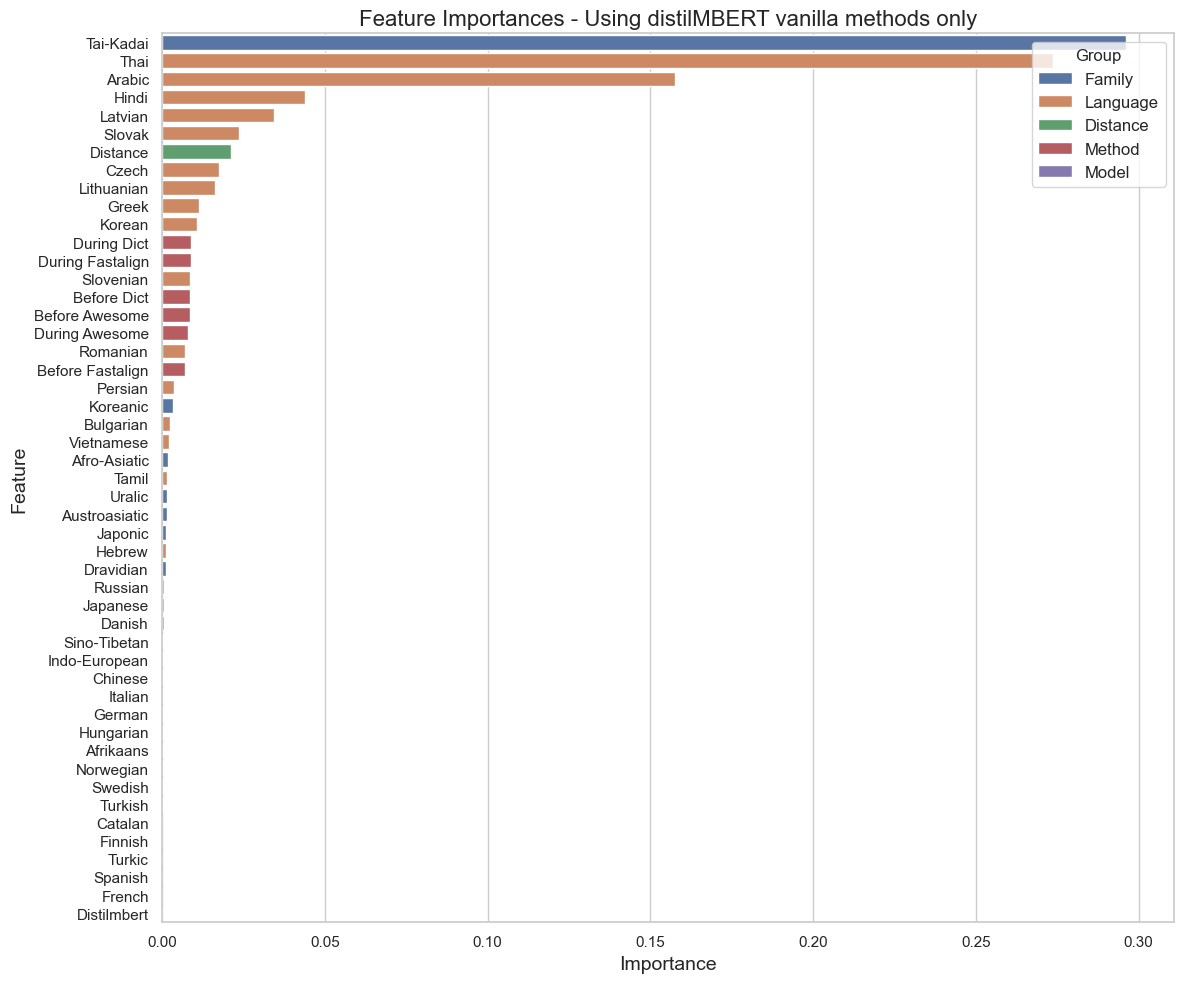

In [90]:
def run_regression_and_plot(df, description):
    train_data, val_data, test_data = split_train_val_test(df, use_standard_split=True)
    train_data = train_data.drop(columns=['method_type'])
    val_data = val_data.drop(columns=['method_type'])
    test_data = test_data.drop(columns=['method_type'])
    
    print(description)
    print()
    
    coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title=description)
    plot_feature_importances(coefficients, encoded_columns, group_by_distance=True, title=description)

# Aggregate
run_regression_and_plot(combined_df_with_flags, "Using all data")

# Freeze methods only
freeze_df = combined_df_with_flags[combined_df_with_flags['method_type'] == 'freeze']
run_regression_and_plot(freeze_df, "Using freeze methods only")

# Vanilla methods only
vanilla_df = combined_df_with_flags[combined_df_with_flags['method_type'] == 'vanilla']
run_regression_and_plot(vanilla_df, "Using vanilla methods only")

# XLM-R only
xlmr_df = combined_df_with_flags[combined_df_with_flags['model'] == 'XLM-R']
run_regression_and_plot(xlmr_df, "Using XLM-R only")

# XLM-R freeze methods only
xlmr_freeze_df = xlmr_df[xlmr_df['method_type'] == 'freeze']
run_regression_and_plot(xlmr_freeze_df, "Using XLM-R freeze methods only")

# XLM-R vanilla methods only
xlmr_vanilla_df = xlmr_df[xlmr_df['method_type'] == 'vanilla']
run_regression_and_plot(xlmr_vanilla_df, "Using XLM-R vanilla methods only")

# distilMBERT only
distilbert_df = combined_df_with_flags[combined_df_with_flags['model'] == 'distilMBERT']
run_regression_and_plot(distilbert_df, "Using distilMBERT only")

# distilMBERT freeze methods only
distilbert_freeze_df = distilbert_df[distilbert_df['method_type'] == 'freeze']
run_regression_and_plot(distilbert_freeze_df, "Using distilMBERT freeze methods only")

# distilMBERT vanilla methods only
distilbert_vanilla_df = distilbert_df[distilbert_df['method_type'] == 'vanilla']
run_regression_and_plot(distilbert_vanilla_df, "Using distilMBERT vanilla methods only")

In [91]:
combined_df_with_flags[combined_df_with_flags['language'] == 'Slovak'].head(25).sort_values(by='delta_accuracy', ascending=False)

model            method language  seed  accuracy  delta_accuracy  \
387  XLM-R       Before Dict   Slovak    17  0.870552        0.019018   
207  XLM-R    Before Awesome   Slovak    17  0.864340        0.012807   
27   XLM-R  Before FastAlign   Slovak    17  0.859433        0.007899   
135  XLM-R  Before FastAlign   Slovak    42  0.867408        0.005368   
423  XLM-R       Before Dict   Slovak    23  0.862883        0.004985   
495  XLM-R       Before Dict   Slovak    42  0.865874        0.003834   
315  XLM-R    Before Awesome   Slovak    42  0.865798        0.003758   
243  XLM-R    Before Awesome   Slovak    23  0.860276        0.002377   
63   XLM-R  Before FastAlign   Slovak    23  0.858282        0.000383   
567  XLM-R  During FastAlign   Slovak    17  0.848236       -0.003298   
459  XLM-R       Before Dict   Slovak    66  0.861426       -0.006442   
747  XLM-R    During Awesome   Slovak    17  0.844632       -0.006902   
351  XLM-R    Before Awesome   Slovak    31  0.864724       -0.008512   
531  XLM-R       Before Dict   Slovak    31  0.863650       -0.009586   
99   XLM-R  Before FastAlign   Slovak    66  0.857975       -0.009893   
675  XLM-R  During FastAlign   Slovak    42  0.850920       -0.011120   
279  XLM-R    Before Awesome   Slovak    66  0.855291       -0.012577   
783  XLM-R    During Awesome   Slovak    23  0.844172       -0.013727   
855  XLM-R    During Awesome   Slovak    42  0.846242       -0.015798   
603  XLM-R  During FastAlign   Slovak    23  0.841948       -0.015951   
171  XLM-R  Before FastAlign   Slovak    31  0.853144       -0.020092   
639  XLM-R  During FastAlign   Slovak    66  0.842485       -0.025383   
819  XLM-R    During Awesome   Slovak    66  0.842178       -0.025690   
891  XLM-R    During Awesome   Slovak    31  0.846779       -0.026457   
711  XLM-R  During FastAlign   Slovak    31  0.845552       -0.027684   

      Distance       Families method_type  
387  20.615528  Indo-European     vanilla  
207  20.615528  Indo-European     vanilla  
27   20.615528  Indo-European     vanilla  
135  20.615528  Indo-European     vanilla  
423  20.615528  Indo-European     vanilla  
495  20.615528  Indo-European     vanilla  
315  20.615528  Indo-European     vanilla  
243  20.615528  Indo-European     vanilla  
63   20.615528  Indo-European     vanilla  
567  20.615528  Indo-European     vanilla  
459  20.615528  Indo-European     vanilla  
747  20.615528  Indo-European     vanilla  
351  20.615528  Indo-European     vanilla  
531  20.615528  Indo-European     vanilla  
99   20.615528  Indo-European     vanilla  
675  20.615528  Indo-European     vanilla  
279  20.615528  Indo-European     vanilla  
783  20.615528  Indo-European     vanilla  
855  20.615528  Indo-European     vanilla  
603  20.615528  Indo-European     vanilla  
171  20.615528  Indo-European     vanilla  
639  20.615528  Indo-European     vanilla  
819  20.615528  Indo-European     vanilla  
891  20.615528  Indo-European     vanilla  
711  20.615528  Indo-European     vanilla

In [92]:
combined_df_with_flags[(combined_df_with_flags['model'] == 'distilMBERT') & (combined_df_with_flags['language'] == 'Thai')].head(25).sort_values(by='delta_accuracy', ascending=False)

model                                       method language  seed  \
3833  distilMBERT       freeze_realign_unfreeze_last_half_dico     Thai    17   
3820  distilMBERT                               During Awesome     Thai    17   
3818  distilMBERT                                  Before Dict     Thai    17   
3829  distilMBERT                   During Back Freeze Awesome     Thai    17   
3830  distilMBERT                      During Back Freeze Dict     Thai    17   
3821  distilMBERT                                  During Dict     Thai    17   
3817  distilMBERT                               Before Awesome     Thai    17   
3816  distilMBERT                             Before FastAlign     Thai    17   
3823  distilMBERT                Before - Front Freeze Awesome     Thai    17   
3832  distilMBERT    freeze_realign_unfreeze_last_half_awesome     Thai    17   
3831  distilMBERT  freeze_realign_unfreeze_last_half_fastalign     Thai    17   
3828  distilMBERT                 During Back Freeze FastAlign     Thai    17   
3824  distilMBERT                   Before - Front Freeze Dict     Thai    17   
3819  distilMBERT                             During FastAlign     Thai    17   
3822  distilMBERT              Before - Front Freeze FastAlign     Thai    17   
3826  distilMBERT                  During Front Freeze Awesome     Thai    17   
3827  distilMBERT                     During Front Freeze Dict     Thai    17   
4466  distilMBERT                                  Before Dict     Thai    23   
4469  distilMBERT                                  During Dict     Thai    23   
3825  distilMBERT                During Front Freeze FastAlign     Thai    17   
4468  distilMBERT                               During Awesome     Thai    23   
4464  distilMBERT                             Before FastAlign     Thai    23   
4467  distilMBERT                             During FastAlign     Thai    23   
4465  distilMBERT                               Before Awesome     Thai    23   
4470  distilMBERT              Before - Front Freeze FastAlign     Thai    23   

      accuracy  delta_accuracy    Distance   Families method_type  
3833  0.544291        0.241395  112.924754  Tai-Kadai      freeze  
3820  0.542456        0.239560  112.924754  Tai-Kadai     vanilla  
3818  0.542277        0.239381  112.924754  Tai-Kadai     vanilla  
3829  0.537487        0.234591  112.924754  Tai-Kadai      freeze  
3830  0.533906        0.231010  112.924754  Tai-Kadai      freeze  
3821  0.533280        0.230384  112.924754  Tai-Kadai     vanilla  
3817  0.530012        0.227116  112.924754  Tai-Kadai     vanilla  
3816  0.524327        0.221431  112.924754  Tai-Kadai     vanilla  
3823  0.520926        0.218030  112.924754  Tai-Kadai      freeze  
3832  0.520478        0.217582  112.924754  Tai-Kadai      freeze  
3831  0.511436        0.208540  112.924754  Tai-Kadai      freeze  
3828  0.508616        0.205720  112.924754  Tai-Kadai      freeze  
3824  0.507229        0.204333  112.924754  Tai-Kadai      freeze  
3819  0.506602        0.203706  112.924754  Tai-Kadai     vanilla  
3822  0.502842        0.199946  112.924754  Tai-Kadai      freeze  
3826  0.486863        0.183967  112.924754  Tai-Kadai      freeze  
3827  0.482163        0.179267  112.924754  Tai-Kadai      freeze  
4466  0.559420        0.178461  112.924754  Tai-Kadai     vanilla  
4469  0.555168        0.174209  112.924754  Tai-Kadai     vanilla  
3825  0.473255        0.170359  112.924754  Tai-Kadai      freeze  
4468  0.541516        0.160557  112.924754  Tai-Kadai     vanilla  
4464  0.523119        0.142160  112.924754  Tai-Kadai     vanilla  
4467  0.519449        0.138490  112.924754  Tai-Kadai     vanilla  
4465  0.506557        0.125599  112.924754  Tai-Kadai     vanilla  
4470  0.486281        0.105322  112.924754  Tai-Kadai      freeze

In [93]:
combined_df_with_flags[combined_df_with_flags['language'] == 'Arabic'].head(25).sort_values(by='delta_accuracy', ascending=False)

model            method language  seed  accuracy  delta_accuracy  \
363  XLM-R       Before Dict   Arabic    17  0.687372        0.065038   
471  XLM-R       Before Dict   Arabic    42  0.682646        0.050208   
3    XLM-R  Before FastAlign   Arabic    17  0.667102        0.044768   
507  XLM-R       Before Dict   Arabic    31  0.672138        0.043244   
183  XLM-R    Before Awesome   Arabic    17  0.664024        0.041690   
399  XLM-R       Before Dict   Arabic    23  0.677237        0.032736   
435  XLM-R       Before Dict   Arabic    66  0.659205        0.026892   
291  XLM-R    Before Awesome   Arabic    42  0.657993        0.025555   
327  XLM-R    Before Awesome   Arabic    31  0.653081        0.024187   
111  XLM-R  Before FastAlign   Arabic    42  0.656532        0.024094   
543  XLM-R  During FastAlign   Arabic    17  0.644252        0.021918   
867  XLM-R    During Awesome   Arabic    31  0.649257        0.020363   
723  XLM-R    During Awesome   Arabic    17  0.642511        0.020177   
147  XLM-R  Before FastAlign   Arabic    31  0.649008        0.020114   
651  XLM-R  During FastAlign   Arabic    42  0.650998        0.018560   
687  XLM-R  During FastAlign   Arabic    31  0.647081        0.018187   
831  XLM-R    During Awesome   Arabic    42  0.648728        0.016290   
39   XLM-R  Before FastAlign   Arabic    23  0.656470        0.011969   
75   XLM-R  Before FastAlign   Arabic    66  0.643754        0.011441   
219  XLM-R    Before Awesome   Arabic    23  0.655755        0.011254   
615  XLM-R  During FastAlign   Arabic    66  0.638283        0.005969   
255  XLM-R    Before Awesome   Arabic    66  0.634956        0.002643   
795  XLM-R    During Awesome   Arabic    66  0.634707        0.002394   
579  XLM-R  During FastAlign   Arabic    23  0.640863       -0.003637   
759  XLM-R    During Awesome   Arabic    23  0.639153       -0.005347   

      Distance      Families method_type  
363  43.829214  Afro-Asiatic     vanilla  
471  43.829214  Afro-Asiatic     vanilla  
3    43.829214  Afro-Asiatic     vanilla  
507  43.829214  Afro-Asiatic     vanilla  
183  43.829214  Afro-Asiatic     vanilla  
399  43.829214  Afro-Asiatic     vanilla  
435  43.829214  Afro-Asiatic     vanilla  
291  43.829214  Afro-Asiatic     vanilla  
327  43.829214  Afro-Asiatic     vanilla  
111  43.829214  Afro-Asiatic     vanilla  
543  43.829214  Afro-Asiatic     vanilla  
867  43.829214  Afro-Asiatic     vanilla  
723  43.829214  Afro-Asiatic     vanilla  
147  43.829214  Afro-Asiatic     vanilla  
651  43.829214  Afro-Asiatic     vanilla  
687  43.829214  Afro-Asiatic     vanilla  
831  43.829214  Afro-Asiatic     vanilla  
39   43.829214  Afro-Asiatic     vanilla  
75   43.829214  Afro-Asiatic     vanilla  
219  43.829214  Afro-Asiatic     vanilla  
615  43.829214  Afro-Asiatic     vanilla  
255  43.829214  Afro-Asiatic     vanilla  
795  43.829214  Afro-Asiatic     vanilla  
579  43.829214  Afro-Asiatic     vanilla  
759  43.829214  Afro-Asiatic     vanilla

In [94]:
combined_df_with_flags[(combined_df_with_flags['model'] == 'distilMBERT') & (combined_df_with_flags['language'] == 'Arabic')].head(25).sort_values(by='delta_accuracy', ascending=False)

model                                       method language  seed  \
3263  distilMBERT                                  During Dict   Arabic    17   
3260  distilMBERT                                  Before Dict   Arabic    17   
3275  distilMBERT       freeze_realign_unfreeze_last_half_dico   Arabic    17   
3272  distilMBERT                      During Back Freeze Dict   Arabic    17   
3266  distilMBERT                   Before - Front Freeze Dict   Arabic    17   
3258  distilMBERT                             Before FastAlign   Arabic    17   
3273  distilMBERT  freeze_realign_unfreeze_last_half_fastalign   Arabic    17   
3259  distilMBERT                               Before Awesome   Arabic    17   
3264  distilMBERT              Before - Front Freeze FastAlign   Arabic    17   
3274  distilMBERT    freeze_realign_unfreeze_last_half_awesome   Arabic    17   
3908  distilMBERT                                  Before Dict   Arabic    23   
3265  distilMBERT                Before - Front Freeze Awesome   Arabic    17   
3911  distilMBERT                                  During Dict   Arabic    23   
3262  distilMBERT                               During Awesome   Arabic    17   
3261  distilMBERT                             During FastAlign   Arabic    17   
3271  distilMBERT                   During Back Freeze Awesome   Arabic    17   
3269  distilMBERT                     During Front Freeze Dict   Arabic    17   
3270  distilMBERT                 During Back Freeze FastAlign   Arabic    17   
3909  distilMBERT                             During FastAlign   Arabic    23   
3906  distilMBERT                             Before FastAlign   Arabic    23   
3910  distilMBERT                               During Awesome   Arabic    23   
3907  distilMBERT                               Before Awesome   Arabic    23   
3267  distilMBERT                During Front Freeze FastAlign   Arabic    17   
3912  distilMBERT              Before - Front Freeze FastAlign   Arabic    23   
3268  distilMBERT                  During Front Freeze Awesome   Arabic    17   

      accuracy  delta_accuracy   Distance      Families method_type  
3263  0.665394        0.157305  43.829214  Afro-Asiatic     vanilla  
3260  0.663562        0.155473  43.829214  Afro-Asiatic     vanilla  
3275  0.655240        0.147151  43.829214  Afro-Asiatic      freeze  
3272  0.651079        0.142990  43.829214  Afro-Asiatic      freeze  
3266  0.650675        0.142587  43.829214  Afro-Asiatic      freeze  
3258  0.646639        0.138550  43.829214  Afro-Asiatic     vanilla  
3273  0.643968        0.135880  43.829214  Afro-Asiatic      freeze  
3259  0.640460        0.132371  43.829214  Afro-Asiatic     vanilla  
3264  0.638845        0.130756  43.829214  Afro-Asiatic      freeze  
3274  0.637758        0.129669  43.829214  Afro-Asiatic      freeze  
3908  0.673405        0.126378  43.829214  Afro-Asiatic     vanilla  
3265  0.634125        0.126036  43.829214  Afro-Asiatic      freeze  
3911  0.671883        0.124856  43.829214  Afro-Asiatic     vanilla  
3262  0.631921        0.123832  43.829214  Afro-Asiatic     vanilla  
3261  0.630275        0.122186  43.829214  Afro-Asiatic     vanilla  
3271  0.623599        0.115510  43.829214  Afro-Asiatic      freeze  
3269  0.621767        0.113678  43.829214  Afro-Asiatic      freeze  
3270  0.617513        0.109424  43.829214  Afro-Asiatic      freeze  
3909  0.644372        0.097345  43.829214  Afro-Asiatic     vanilla  
3906  0.637665        0.090638  43.829214  Afro-Asiatic     vanilla  
3910  0.635678        0.088651  43.829214  Afro-Asiatic     vanilla  
3907  0.635026        0.087999  43.829214  Afro-Asiatic     vanilla  
3267  0.591337        0.083248  43.829214  Afro-Asiatic      freeze  
3912  0.629623        0.082596  43.829214  Afro-Asiatic      freeze  
3268  0.585530        0.077441  43.829214  Afro-Asiatic      freeze

In [106]:
# Filter for distilMBERT model
distilbert_df = combined_df_with_flags[combined_df_with_flags['model'] == 'distilMBERT']

# Calculate the nearest neighbors to Thai
nearest_neighbors_df = find_nearest_neighbors('Thai', uri_data, n_neighbors=10)

# Get the list of similar languages to Thai (including Thai itself for reference)
similar_language_names = nearest_neighbors_df['language'].tolist() + ['Thai']

# Filter the original dataframe for these languages to get their Delta accuracy
delta_accuracy_df = distilbert_df[distilbert_df['language'].isin(similar_language_names)]
average_delta_accuracy = delta_accuracy_df.groupby('language')['delta_accuracy'].mean().reset_index()

# Get the coordinates for Thai
thai_coordinates = find_closest_coordinates(uri_data, gc_columns)['Thai']
thai_lat, thai_lon = extract_coordinates(thai_coordinates)

# Create a DataFrame for Thai's coordinates
thai_df = pd.DataFrame([{
    'language': 'Thai',
    'Distance': 0.0,
    'Nearest_Coordinate_Column': thai_coordinates,
    'Latitude': thai_lat,
    'Longitude': thai_lon
}])

# Add Thai's coordinates to the nearest_neighbors_df
nearest_neighbors_df = pd.concat([nearest_neighbors_df, thai_df], ignore_index=True)

# Merge the distances with average delta accuracy
average_delta_accuracy = average_delta_accuracy.merge(nearest_neighbors_df, on='language', how='left')

# Ensure the average_delta_accuracy dataframe maintains the same order
average_delta_accuracy = average_delta_accuracy.sort_values(by='Distance')

# Display the results
average_delta_accuracy


language  delta_accuracy   Distance Nearest_Coordinate_Column  Latitude  \
9         Thai        0.204766   0.000000                  GC_10_99      10.0   
10  Vietnamese        0.000720  13.000000                 GC_15_111      15.0   
8        Tamil        0.024663  20.223748                  GC_13_79      13.0   
3        Hindi        0.054232  23.345235                  GC_27_83      27.0   
1      Chinese        0.017340  30.364453                 GC_39_108      39.0   
4     Japanese        0.032754  38.288379                 GC_35_128      35.0   
5       Korean        0.056096  38.288379                 GC_35_128      35.0   
6      Persian        0.000413  41.677332                  GC_31_63      31.0   
7      Russian        0.021109  49.769469                  GC_56_80      56.0   
0       Arabic        0.116583  70.604532                  GC_29_31      29.0   
2       Hebrew        0.023836  70.604532                  GC_29_31      29.0   

    Longitude  
9        99.0  
10      111.0  
8        79.0  
3        83.0  
1       108.0  
4       128.0  
5       128.0  
6        63.0  
7        80.0  
0        31.0  
2        31.0

In [107]:
import folium

def create_map(data, language_of_interest):
    # Create a map centered around the first coordinate
    m = folium.Map(location=[data.iloc[0]['Latitude'], data.iloc[0]['Longitude']], zoom_start=2)

    # Add the language of interest
    folium.Marker(
        [data[data['language'] == language_of_interest]['Latitude'].values[0], 
         data[data['language'] == language_of_interest]['Longitude'].values[0]], 
         popup=f"{language_of_interest} (Target)",
         icon=folium.Icon(color='red')
    ).add_to(m)

    # Add the other languages
    for i, row in data.iterrows():
        if row['language'] != language_of_interest:
            folium.Marker(
                [row['Latitude'], row['Longitude']],
                popup=f"{row['language']} ({row['Distance']:.2f})",
                icon=folium.Icon(color='blue')
            ).add_to(m)
    
    return m

# Assuming average_delta_accuracy is your DataFrame
create_map(average_delta_accuracy, 'Thai')


In [ ]:
# Combine the distance and delta accuracy data into a single dataframe
heatmap_data = pd.merge(similar_languages[['language', 'distance_to_thai']], average_delta_accuracy[['language', 'delta_accuracy']], on='language')

# Add language family information to the heatmap_data dataframe
language_families = {
    'Thai': 'Tai-Kadai',
    'Vietnamese': 'Austroasiatic',
    'Finnish': 'Uralic',
    'English': 'Indo-European',
    'Polish': 'Indo-European',
    'Catalan': 'Indo-European',
    'Bulgarian': 'Indo-European',
    'Romanian': 'Indo-European',
    'Hungarian': 'Uralic',
    'Norwegian': 'Indo-European',
    'Chinese': 'Sino-Tibetan'
}
heatmap_data['language_family'] = heatmap_data['language'].map(language_families)

# Get Thai's delta accuracy
thai_delta_accuracy = heatmap_data[heatmap_data['language'] == 'Thai']['delta_accuracy'].values[0]

# Remove Thai from the heatmap data
heatmap_data = heatmap_data[heatmap_data['language'] != 'Thai']

# Sort the dataframe by language family and distance to Thai
heatmap_data = heatmap_data.sort_values(['language_family', 'distance_to_thai'])

# Create a pivot table with language families as rows and languages as columns
heatmap_pivot = heatmap_data.pivot(index='language_family', columns='language', values='distance_to_thai')

# Create a custom colormap with a simple blue to red color scheme
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad('lightgray')

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, annot=False, cmap=cmap, cbar_kws={'label': 'Euclidean Distance'}, square=True,
            linewidths=0.5, linecolor='black', mask=heatmap_pivot.isnull())

# Add delta accuracy values as percentages inside each square
for i in range(heatmap_pivot.shape[0]):
    for j in range(heatmap_pivot.shape[1]):
        language = heatmap_pivot.columns[j]
        if not pd.isnull(heatmap_pivot.iloc[i, j]):
            delta_accuracy = heatmap_data[heatmap_data['language'] == language]['delta_accuracy'].values[0]
            plt.text(j + 0.5, i + 0.5, f'{delta_accuracy*100:.2f}%', ha='center', va='center', color='black', fontsize=12)

# Adjust the plot layout
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.title('10 Nearest Neighbors to Thai: Euclidean Distance of Lang2Vec Distance Features')
plt.xlabel('Language')
plt.ylabel('Language Family')

# Add Thai's delta accuracy below the title with reduced vertical gap
plt.suptitle(f"Thai (Tai-Kadai)\nDelta Accuracy: {thai_delta_accuracy*100:.2f}%", fontsize=12, y=0.99)

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust the top spacing to minimize the gap
plt.show()

In [ ]:
delta_accuracy_df

In [ ]:
nli_csv_path = './distilMBERT_nli_data/distilbert-base-multilingual-cased__xnli__opus100.csv'

nli_df = read_and_process_csv(nli_csv_path, model_name='distilMBERT')
nli_df = nli_df[~nli_df.isna().any(axis=1)]

In [ ]:
nli_df

In [ ]:
nli_df['method'].value_counts()

In [ ]:
processed_nli_df = process_dataframe(nli_df, group_by_columns=['model', 'seed', 'language'])

In [ ]:
processed_nli_df

In [ ]:
processed_nli_df[(processed_nli_df['language'] == 'Chinese') & (processed_nli_df['seed'] == 17)]

In [ ]:
processed_nli_df = processed_nli_df[~processed_nli_df.isna().any(axis=1)]

In [ ]:
# Calculate average and standard error of delta accuracy grouped by method
average_delta_accuracy = processed_nli_df.groupby('method')['delta_accuracy'].agg(['mean', 'sem']).reset_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create the x-axis positions
x_pos = np.arange(len(average_delta_accuracy))

# Define the color for distilMBERT
distilMBERT_color = '#ff7f0e'

# Plot bars for each method
ax.bar(x_pos, average_delta_accuracy['mean'], yerr=average_delta_accuracy['sem'], align='center', alpha=0.7, ecolor='black', capsize=10, color=distilMBERT_color)

# Set the x-axis tick positions and labels
ax.set_xticks(x_pos)
ax.set_xticklabels([method.replace('_', ' ') for method in average_delta_accuracy['method']], rotation=45, ha='right')

# Set the plot title and labels
ax.set_title('Average Delta Accuracy by Method for distilMBERT on NLI')
ax.set_xlabel('Method')
ax.set_ylabel('Average Delta Accuracy')

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
nli_train_data, nli_val_data, nli_test_data = split_train_val_test(processed_nli_df, use_standard_split=True)

In [ ]:
nli_train_data

In [ ]:
nli_val_data

In [ ]:
nli_test_data

In [ ]:
nli_coefficients, nli_encoded_columns = perform_regression(nli_train_data, nli_val_data, nli_test_data)

plot_feature_importances(nli_coefficients, nli_encoded_columns)

In [ ]:
processed_nli_df_with_distances = add_language_distances_to_df(processed_nli_df)

In [ ]:
processed_nli_df_with_distances

In [ ]:
processed_nli_df_with_distances = processed_nli_df_with_distances[~processed_nli_df_with_distances.isna().any(axis=1)]

In [ ]:
nli_train_data, nli_val_data, nli_test_data = split_train_val_test(processed_nli_df_with_distances, use_standard_split=True)

In [ ]:
nli_train_data

In [ ]:
nli_val_data

In [ ]:
nli_test_data

In [ ]:
nli_dist_coefficients, nli_dist_encoded_columns = perform_regression(nli_train_data, nli_val_data, nli_test_data)

plot_feature_importances(nli_dist_coefficients, nli_dist_encoded_columns, group_by_distance=True)

In [ ]:
nli_df_flagged = flag_freeze_methods(processed_nli_df_with_distances)

In [ ]:
nli_df_flagged = nli_df_flagged[~nli_df_flagged.isna().any(axis=1)]
nli_df_flagged

In [ ]:
run_regression_and_plot(nli_df_flagged, "Using all data")

# Freeze methods only
freeze_df = nli_df_flagged[nli_df_flagged['method_type'] == 'freeze']
run_regression_and_plot(freeze_df, "Using freeze methods only")

# Vanilla methods only
vanilla_df = nli_df_flagged[nli_df_flagged['method_type'] == 'vanilla']
run_regression_and_plot(vanilla_df, "Using vanilla methods only")

In [ ]:
import pandas as pd

# Load the CSV file
file_path = './distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv'
data = pd.read_csv(file_path)

# Define the shortened method names dictionary
shortened_method_names = {
    'baseline': 'FT Only',
    'before_fastalign': 'Before FA',
    'before_awesome': 'Before AA',
    'before_dico': 'Before BD',
    'during_fastalign': 'During FA',
    'during_awesome': 'During AA',
    'during_dico': 'During BD',
}

# Define the language codes to full names mapping
language_names = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'avg': 'Average',
    'bg': 'Bulgarian',
    'ca': 'Catalan',
    'zh': 'Chinese',
    'cs': 'Czech',
    'da': 'Danish',
    'fi': 'Finnish',
    'fr': 'French',
    'de': 'German',
    'el': 'Greek',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hu': 'Hungarian',
    'it': 'Italian',
    'ja': 'Japanese',
    'ko': 'Korean',
    'lv': 'Latvian',
    'lt': 'Lithuanian',
    'no': 'Norwegian',
    'fa': 'Persian',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'sk': 'Slovak',
    'sl': 'Slovenian',
    'es': 'Spanish',
    'sv': 'Swedish',
    'ta': 'Tamil',
    'th': 'Thai',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'vi': 'Vietnamese'
}

# Extract accuracy columns
accuracy_cols = [col for col in data.columns if 'final_eval_' in col and 'accuracy' in col]

# Melting the dataframe to get a long format
long_data = data.melt(id_vars=['method'], value_vars=accuracy_cols, var_name='language', value_name='accuracy')

# Cleaning up the language column
long_data['language'] = long_data['language'].str.replace('final_eval_', '').str.replace('_accuracy', '')
long_data['language'] = long_data['language'].map(language_names)

# Updating method names with shortened versions
long_data['method'] = long_data['method'].map(shortened_method_names).fillna('FT Only')

# Extracting method components
long_data[['timing', 'aligner']] = long_data['method'].str.extract(r'(FT Only|Before|During)\s*(AA|BD|FA)?')

# Ensure 'FT Only' has empty aligner value
long_data.loc[long_data['timing'] == 'FT Only', 'aligner'] = ''

# Pivot the data to create the table
pivot_data = long_data.pivot_table(index='language', columns=['timing', 'aligner'], values='accuracy', aggfunc='mean')

# Reorder the columns
column_order = [
    ('FT Only', ''),
    ('Before', 'AA'),
    ('Before', 'BD'),
    ('Before', 'FA'),
    ('During', 'AA'),
    ('During', 'BD'),
    ('During', 'FA')
]
pivot_data = pivot_data.reindex(columns=column_order)

# Round the values to 3 decimal places and highlight the maximum in each row
def format_and_highlight(data):
    formatted_data = data.applymap(lambda x: f'{x:.3f}' if pd.notna(x) else '')
    for idx in formatted_data.index:
        max_value = data.loc[idx].max()
        if pd.notna(max_value):
            formatted_data.loc[idx] = formatted_data.loc[idx].apply(lambda x: f'\\textbf{{{x}}}' if x == f'{max_value:.3f}' else x)
    return formatted_data

highlighted_data = format_and_highlight(pivot_data)

# Create the LaTeX table
table_header = r"""
\onecolumn
\begin{table*}[ht]
\centering
\begin{tabular}{|l|c|ccc|ccc|}
\hline
Train. Appr. & FT Only & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{During} \\ \cline{3-8}
Aligner & & AA & BD & FA & AA & BD & FA \\
\hline
"""

table_footer = r"""
\hline
\end{tabular}
\caption{PoS tagging average accuracy results across 5 seeds using distilMBERT for the vanilla methods by language, training approach, and aligner. Aligner names: FA - FastAlign, AA - AwesomeAlign, BD - Bilingual Dictionaries. The highest average accuracy value for each language is highlighted in bold.}
\label{table:vanilla_accuracy_results}
\end{table*}
\twocolumn
"""

# Combine the table data
table_body = ""
for index, row in highlighted_data.iterrows():
    row_data = " & ".join(row)
    table_body += f"{index} & {row_data} \\\\\n"

latex_table = table_header + table_body + table_footer

print(latex_table)


In [ ]:
import pandas as pd

# Load the CSV file
file_path = './distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv'
data = pd.read_csv(file_path)

# Define the shortened method names dictionary including freeze methods
shortened_method_names = {
    'baseline': 'FT Only',
    'before_fastalign': 'Before FA',
    'before_awesome': 'Before AA',
    'before_dico': 'Before BD',
    'during_fastalign': 'During FA',
    'during_awesome': 'During AA',
    'during_dico': 'During BD',
    'freeze_realign_unfreeze_fastalign': 'Front Freeze Before FA',
    'freeze_realign_unfreeze_awesome': 'Front Freeze Before AA',
    'freeze_realign_unfreeze_dico': 'Front Freeze Before BD',
    'freeze_realign_unfreeze_last_half_fastalign': 'Back Freeze Before FA',
    'freeze_realign_unfreeze_last_half_awesome': 'Back Freeze Before AA',
    'freeze_realign_unfreeze_last_half_dico': 'Back Freeze Before BD',
    'during_partial_freeze_front_fastalign': 'Front Freeze During FA',
    'during_partial_freeze_front_awesome': 'Front Freeze During AA',
    'during_partial_freeze_front_dico': 'Front Freeze During BD',
    'during_partial_freeze_back_fastalign': 'Back Freeze During FA',
    'during_partial_freeze_back_awesome': 'Back Freeze During AA',
    'during_partial_freeze_back_dico': 'Back Freeze During BD'
}

# Define the language codes to full names mapping
language_names = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'avg': 'Average',
    'bg': 'Bulgarian',
    'ca': 'Catalan',
    'zh': 'Chinese',
    'cs': 'Czech',
    'da': 'Danish',
    'fi': 'Finnish',
    'fr': 'French',
    'de': 'German',
    'el': 'Greek',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hu': 'Hungarian',
    'it': 'Italian',
    'ja': 'Japanese',
    'ko': 'Korean',
    'lv': 'Latvian',
    'lt': 'Lithuanian',
    'no': 'Norwegian',
    'fa': 'Persian',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'sk': 'Slovak',
    'sl': 'Slovenian',
    'es': 'Spanish',
    'sv': 'Swedish',
    'ta': 'Tamil',
    'th': 'Thai',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'vi': 'Vietnamese'
}

# Extract accuracy columns
accuracy_cols = [col for col in data.columns if 'final_eval_' in col and 'accuracy' in col]

# Melting the dataframe to get a long format
long_data = data.melt(id_vars=['method'], value_vars=accuracy_cols, var_name='language', value_name='accuracy')

# Cleaning up the language column
long_data['language'] = long_data['language'].str.replace('final_eval_', '').str.replace('_accuracy', '')
long_data['language'] = long_data['language'].map(language_names)

# Updating method names with shortened versions
long_data['method'] = long_data['method'].map(shortened_method_names).fillna('FT Only')

# Extracting method components
long_data[['primary_group', 'timing', 'aligner']] = long_data['method'].str.extract(r'(FT Only|Front Freeze|Back Freeze)?\s*(Before|During)?\s*(AA|BD|FA)?')

# Ensure 'FT Only' has empty primary_group, timing, and aligner values
long_data.loc[long_data['method'] == 'FT Only', ['primary_group', 'timing', 'aligner']] = ['FT Only', '', '']

# Pivot the data to create the table
pivot_data = long_data.pivot_table(index='language', columns=['primary_group', 'timing', 'aligner'], values='accuracy', aggfunc='mean')

# Reorder the columns
column_order = [
    ('FT Only', '', ''),
    ('Front Freeze', 'Before', 'AA'),
    ('Front Freeze', 'Before', 'BD'),
    ('Front Freeze', 'Before', 'FA'),
    ('Front Freeze', 'During', 'AA'),
    ('Front Freeze', 'During', 'BD'),
    ('Front Freeze', 'During', 'FA'),
    ('Back Freeze', 'Before', 'AA'),
    ('Back Freeze', 'Before', 'BD'),
    ('Back Freeze', 'Before', 'FA'),
    ('Back Freeze', 'During', 'AA'),
    ('Back Freeze', 'During', 'BD'),
    ('Back Freeze', 'During', 'FA')
]
pivot_data = pivot_data.reindex(columns=column_order)

# Round the values to 3 decimal places and highlight the maximum in each row
def format_and_highlight(data):
    formatted_data = data.applymap(lambda x: f'{x:.3f}' if pd.notna(x) else '')
    for idx in formatted_data.index:
        max_value = data.loc[idx].max()
        if pd.notna(max_value):
            formatted_data.loc[idx] = formatted_data.loc[idx].apply(lambda x: f'\\textbf{{{x}}}' if x == f'{max_value:.3f}' else x)
    return formatted_data

highlighted_data = format_and_highlight(pivot_data)

# Create the LaTeX table using tabularx and centering "Aligner"
table_header = r"""
\usepackage{tabularx}
\onecolumn
\begin{table*}[ht]
\centering
\scriptsize
\begin{tabularx}{\textwidth}{|l|c|X|X|X|X|X|X|X|X|X|X|X|X|X|}
\hline
Train. Appr. & FT Only & \multicolumn{6}{c|}{Front Freeze} & \multicolumn{6}{c|}{Back Freeze} \\ \cline{3-14}
& & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{During} & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{During} \\ \cline{3-14}
Aligner & & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} \\
\hline
"""

table_footer = r"""
\hline
\end{tabularx}
\caption{PoS tagging average accuracy results across 5 seeds using distilMBERT for the freeze methods by language, training approach, and aligner. Aligner names: FA - FastAlign, AA - AwesomeAlign, BD - Bilingual Dictionaries. The highest average accuracy value for each language is highlighted in bold.}
\label{table:vanilla_accuracy_results}
\end{table*}
\twocolumn
"""

# Combine the table data
table_body = ""
for index, row in highlighted_data.iterrows():
    row_data = " & ".join(row)
    table_body += f"{index} & {row_data} \\\\\n"

latex_table = table_header + table_body + table_footer

print(latex_table)
